In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import random
random.seed(10)
import pycountry
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from keras import regularizers
from tqdm.keras import TqdmCallback
from tensorflow.keras import metrics
import category_encoders as ce
from scipy import stats


## Load Data

In [2]:
dfolder = '../data/'

In [3]:
df = pd.read_csv(dfolder + 'preprocessed_df.csv')

In [4]:
df['deaths_all_pc']

0        0.276314
1        0.777290
2        1.620053
3        2.706927
4        0.418548
           ...   
54910    0.000000
54911    0.000000
54912    0.000000
54913    0.000000
54914    0.000000
Name: deaths_all_pc, Length: 54915, dtype: float64

## Preprocessing

In [5]:
def get_country_name(isocode):
    try:
        return pycountry.countries.get(alpha_3=isocode).name
    except AttributeError:
        if isocode == 'XKX':  # isocode for Kosovo
            return 'Kosovo'
        else:
            print(f"Error for isocode: {isocode}")
            return np.nan

df['country'] = df['isocode'].apply(get_country_name)


In [6]:
df['country'].dropna(inplace=True)

In [7]:
df = df.drop(columns=['month_year','isocode_0','isocode_1','isocode_2','isocode_3','isocode_4','isocode_5',
                       'isocode_6', 'isocode_7', 'f3_target_escl', 'f6_target_escl',
                       'f3_target_clsf', 'f6_target_clsf'])

In [8]:
armedconfdf = df

Here i'm taking the top 10 countries for model interpretability later.

In [9]:
top_10_countries=pd.DataFrame(armedconfdf.groupby('country')['deaths_all_pc'].sum()).sort_values(by='deaths_all_pc',ascending=False).reset_index()
top_10_country_names=top_10_countries.country[:11]

In [10]:
df.country.nunique()

197

In [11]:
df['armedconf'] = df['armedconf'].astype(int)
df['neighbor_conflict'] = df['neighbor_conflict'].astype(int)
df_final = df[df['year'] >= 2000]

These are the variable lists for our combinations we will use later on.

In [12]:
other_vars = ['month_sin', 'month_cos']

In [13]:
# Lists of variables to keep for each model (NB past currently only based on total number of deaths per )
id = ['isocode']

historical_vars = ['deaths_all_pc', 'armedconf', 'escalation', 'armedconf_since', 'deaths_stock', 'past6', 'past12', 'past60', 'past120',
                   'share_state_deaths', 'share_nonstate_deaths', 'share_onesided_deaths', 'share_civilian_deaths',
                   'refugees_in', 'refugees_out', 'neighbor_conflict'] + other_vars + ['country', 'year', 'month']

event_shares = ['share_events_{}'.format(i) for i in range(1, 21)] 
event_share_stock = ['event_share_{}_stock'.format(i) for i in range(1, 21)]
event_share_actor = ['share_events_gov', 'share_events_opp']
event_total = ['norm_total_events']
gdelt_admin1 = ['num_regions', 'Adm1_Max', 'Adm1_Mean', 'Adm1_Median']

clusters = ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3']


text_gdelt_vars = event_shares + event_share_stock + event_share_actor + event_total + gdelt_admin1 + clusters + other_vars + ['country', 'year', 'month']

In [14]:
combination_vars = text_gdelt_vars + historical_vars

In [15]:
historical_vars = set(historical_vars)
text_gdelt_vars = set(text_gdelt_vars)
combination_vars = list(historical_vars.union(text_gdelt_vars))
historical_vars = list(historical_vars)
text_gdelt_vars = list(text_gdelt_vars)

## Preprocessing

In [16]:
def train_test_split_year(data, year, target_variable):
    x_train = data[data.index.get_level_values('year') < year].drop(columns=[target_variable])
    y_train = data[data.index.get_level_values('year') < year][target_variable]
    x_test = data[data.index.get_level_values('year') >= year].drop(columns=[target_variable])
    y_test = data[data.index.get_level_values('year') >= year][target_variable]
    return x_train, x_test, y_train, y_test

def preprocess_data(df, variables, split_year, target_variable):
    # copy the dataframe and set multi-index
    conf = df[variables].copy()
    conf['country'] = list(conf.country)
    print(conf.columns)
    conf = conf.set_index(['isocode', 'year', 'month'])

    # split data for each country and append to lists
    X_train, X_test, Y_train, Y_test = [], [], [], []
    for country in conf['country'].unique():
        data = conf[conf['country'] == country]
        x_train, x_test, y_train, y_test = train_test_split_year(data, split_year, target_variable)
        X_train.append(x_train)
        X_test.append(x_test)
        Y_train.append(y_train)
        Y_test.append(y_test)

    # concatenate train and test data from each country
    X_train = pd.concat(X_train)
    Y_train = pd.concat(Y_train)
    X_test = pd.concat(X_test)
    Y_test = pd.concat(Y_test)

    # concatenate X and Y dataframes
    train = pd.concat([X_train, Y_train], axis=1)
    test = pd.concat([X_test, Y_test], axis=1)

    return train, test


## Normalizing

In [17]:
def normalize_data(train, test, target_variable):

    train_index = train.index
    test_index = test.index
    train_country = train['country']
    test_country = test['country']
    train_target = train[target_variable]
    test_target = test[target_variable]

    scaler = MinMaxScaler(feature_range=(0, 1))

    # scale train and test data, excluding 'country' and target variable column
    scaled_train = scaler.fit_transform(train.drop(columns=['country', target_variable]))
    scaled_test = scaler.transform(test.drop(columns=['country', target_variable]))

    # convert back to DataFrame and add columns and index back
    scaled_train = pd.DataFrame(data=scaled_train, columns=train.drop(columns=['country', target_variable]).columns, index=train_index)
    scaled_test = pd.DataFrame(data=scaled_test, columns=test.drop(columns=['country', target_variable]).columns, index=test_index)

    # add 'country' column back
    scaled_train['country'] = train_country
    scaled_test['country'] = test_country

    # log transform target variable and add it back
    scaled_train[target_variable] = np.log1p(train_target)
    scaled_test[target_variable] = np.log1p(test_target)

    return scaled_train, scaled_test


## Model

In [18]:
def series_to_supervised_modified(data, group_by_level, target_column_index, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        group_by_level: The level name to group by (e.g. 'isocode').
        target_column_index: The index of the target column in data
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t)
    for i in range(n_in, -1, -1):
        shifted = df.drop(columns=df.columns[target_column_index]).groupby(level=group_by_level).shift(i)
        cols.append(shifted)
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars) if j != target_column_index]
    # forecast sequence (t+1)
    shifted_target = df.groupby(level=group_by_level)[df.columns[target_column_index]].shift(-n_out)
    cols.append(shifted_target)
    names += ['var%d(t+%d)' % (target_column_index+1, n_out)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [19]:
def series_to_supervised(data, group_by_level, target_column_index, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        group_by_level: The level name to group by (e.g. 'isocode').
        target_column_index: The index of the target column in data
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t)
    for i in range(n_in, -1, -1):
        shifted = df.groupby(level=group_by_level).shift(i)
        cols.append(shifted)
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t+1)
    shifted_target = df.groupby(level=group_by_level)[df.columns[target_column_index]].shift(-n_out)
    cols.append(shifted_target)
    names += ['var%d(t+%d)' % (target_column_index+1, n_out)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [20]:
def reshape_data(train, test, target, modified=False):
    """
    Reshape 'train' and 'test' dataframes into a format suitable for supervised learning,
    splitting them into input features (X) and target labels (y), and reshaping input 
    features into a 3D format required by LSTM models in Keras.

    Arguments:
        train: Training dataframe, with the last column being the target column.
        test: Test dataframe, with the last column being the target column.
        data_type: String indicating type of data ('text' or 'other').

    Returns:
        x_train: Input features for training data, reshaped into 3D format.
        x_test: Input features for test data, reshaped into 3D format.
        y_train: Target labels for training data.
        y_test: Target labels for test data.
        reframed_train: Training data transformed into a supervised learning format.
        reframed_test: Test data transformed into a supervised learning format.
    """
    
    # get the index of the target column
    target_column_index_train = train.columns.tolist().index(target)
    target_column_index_test = test.columns.tolist().index(target)

    # Frame as supervised learning and drop all time t columns except the target
    if modified == True:
        reframed_train = series_to_supervised_modified(train, 'isocode', target_column_index_train, 1, 1)
        reframed_test = series_to_supervised_modified(test, 'isocode', target_column_index_test, 1, 1)
    else:
        reframed_train = series_to_supervised(train, 'isocode', target_column_index_train, 1, 1)
        reframed_test = series_to_supervised(test, 'isocode', target_column_index_test, 1, 1)

    # split into train and test sets
    train_values = reframed_train.values
    test_values = reframed_test.values

    # split into input and outputs
    train_X, y_train = train_values[:, :-1], train_values[:, -1]
    test_X, y_test = test_values[:, :-1], test_values[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    return x_train, x_test, y_train, y_test, reframed_train, reframed_test


In [21]:
def prepare_data_for_model(scaled_train, scaled_test, target):
    # Define a helper function to prepare a dataframe
    def prepare_df(df, target_encoder=None):
        non_country_cols = [col for col in df.columns if col != 'country' and col != target]
        non_country_data = df[non_country_cols]
        
        if target_encoder is None:
            target_encoder = ce.TargetEncoder(smoothing=2.0)
            country_data = target_encoder.fit_transform(df['country'], df[target])
        else:
            country_data = target_encoder.transform(df['country'])
            
        df_data = pd.concat([non_country_data, country_data, df[[target]]], axis=1)
        
        # ensure the target column is the last one
        cols = list(df_data.columns)
        cols.remove(target)
        df_data = df_data[cols + [target]]
        
        return df_data, target_encoder

    # prepare train and test data
    train_data, encoder = prepare_df(scaled_train, None)
    test_data, _ = prepare_df(scaled_test, encoder)

    return train_data, test_data, encoder


In [22]:
def train_and_evaluate_model(x_train, x_test, y_train, y_test, model, target_name):
    # train the given model
    early_stop = EarlyStopping(monitor='loss', patience=3)
    history = model.fit(x_train, y_train, epochs=25, batch_size=120, verbose=0, shuffle=False, callbacks=[early_stop, TqdmCallback(verbose=2)])

    # plot training history
    plt.plot(history.history['loss'], label='Loss')
    plt.legend()
    plt.show()

    # make predictions
    y_pred = model.predict(x_test)

    # apply inverse transformation to predictions
    y_pred = np.expm1(y_pred)
    y_test= np.expm1(y_test)

    # reshape y_pred and y_test to 2D arrays
    y_pred = y_pred.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # return a dictionary of results
    return {'model': model, 
            'target': target_name,
            'y_test': y_test, 
            'y_pred': y_pred, 
            'mse': mse, 
            'mae': mae, 
            'r2': r2}

## Pipeline 

In [23]:
def run_pipeline(df, target_variable, variables, split_year, modified):

    variables = variables.copy()
    
    if target_variable not in variables: 
        variables.append(target_variable)
        
    if 'isocode' not in variables:
        variables.append('isocode')
    
    if target_variable.startswith(('f3', 'f6')): 
        modified = True

    # preprocess data
    train, test = preprocess_data(df, variables, split_year, target_variable)
    
    # normalize 
    scaled_train, scaled_test = normalize_data(train, test, target_variable)
    
    # prepare data for lstm model
    train_data, test_data, encoder = prepare_data_for_model(scaled_train, scaled_test, target_variable)
    
    # reshape data
    x_train, x_test, y_train, y_test, reframed_train, reframed_test = reshape_data(train_data, test_data, target_variable, modified)
    
    # define model 
    model =Sequential()
    model.add(LSTM(60, input_shape=(x_train.shape[1], x_train.shape[2]), kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))
    
    # train and evaluate model
    results = train_and_evaluate_model(x_train, x_test, y_train, y_test, model, target_variable)
    
    return results , encoder, reframed_train , reframed_test, scaled_test


Running our pipeline to fit everything.

In [24]:
all_results = []

Running pipeline for target variable: deaths_all_pc
Index(['share_events_18', 'share_civilian_deaths', 'event_share_6_stock',
       'refugees_in', 'Adm1_Mean', 'cluster_2', 'share_events_13', 'armedconf',
       'event_share_20_stock', 'event_share_15_stock', 'neighbor_conflict',
       'share_events_1', 'cluster_3', 'num_regions', 'share_events_3',
       'month_cos', 'event_share_17_stock', 'event_share_3_stock',
       'armedconf_since', 'past12', 'share_events_14', 'norm_total_events',
       'share_events_5', 'share_events_19', 'share_nonstate_deaths',
       'share_events_8', 'event_share_18_stock', 'share_events_11',
       'share_events_20', 'year', 'event_share_8_stock', 'share_events_7',
       'share_events_2', 'month', 'share_events_opp', 'event_share_13_stock',
       'country', 'share_events_10', 'share_events_15', 'past120',
       'Adm1_Median', 'refugees_out', 'cluster_0', 'share_events_4',
       'event_share_11_stock', 'event_share_9_stock', 'month_sin',
       'sha

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-07-04 01:55:32.825373: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-04 01:55:32.825512: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


0epoch [00:00, ?epoch/s]

2023-07-04 01:55:33.113883: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-04 01:55:33.656033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 01:55:33.833204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 01:55:34.005102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

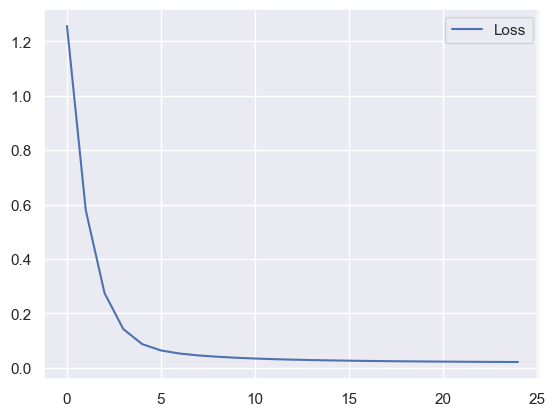

 11/376 [..............................] - ETA: 1s  

2023-07-04 01:56:49.078040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 01:56:49.136748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - 2s 4ms/step
Index(['share_events_18', 'event_share_6_stock', 'Adm1_Median', 'Adm1_Mean',
       'cluster_2', 'share_events_13', 'cluster_0', 'event_share_20_stock',
       'share_events_4', 'event_share_15_stock', 'share_events_1', 'cluster_3',
       'event_share_11_stock', 'event_share_9_stock', 'num_regions',
       'share_events_3', 'month_sin', 'month_cos', 'event_share_17_stock',
       'event_share_3_stock', 'share_events_6', 'event_share_7_stock',
       'share_events_14', 'norm_total_events', 'share_events_5',
       'share_events_19', 'share_events_8', 'event_share_16_stock',
       'share_events_16', 'share_events_11', 'share_events_20',
       'event_share_18_stock', 'share_events_9', 'event_share_5_stock',
       'event_share_8_stock', 'event_share_10_stock', 'share_events_7',
       'event_share_19_stock', 'share_events_gov', 'year', 'share_events_2',
       'month', 'share_events_opp', 'share_events_17', 'cluster_1',
       'eve

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-04 01:56:52.089931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 01:56:52.258192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 01:56:52.373338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

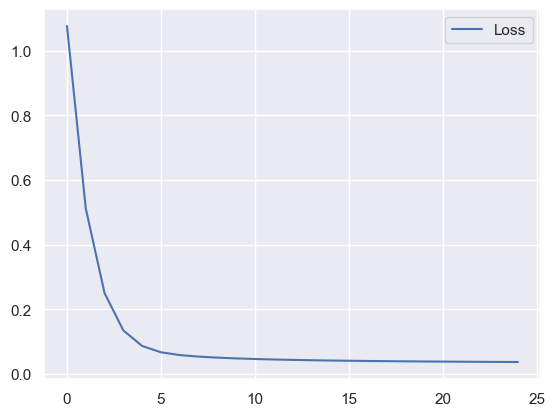

 20/376 [>.............................] - ETA: 0s  

2023-07-04 01:58:19.162235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 01:58:19.225877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - 2s 4ms/step
Index(['share_civilian_deaths', 'past120', 'refugees_in', 'refugees_out',
       'armedconf', 'neighbor_conflict', 'month_sin', 'month_cos',
       'armedconf_since', 'past12', 'share_nonstate_deaths', 'year', 'past6',
       'deaths_stock', 'month', 'past60', 'escalation', 'share_state_deaths',
       'share_onesided_deaths', 'country', 'deaths_all_pc', 'isocode'],
      dtype='object')


0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-04 01:58:21.951475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 01:58:22.117922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 01:58:22.243423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

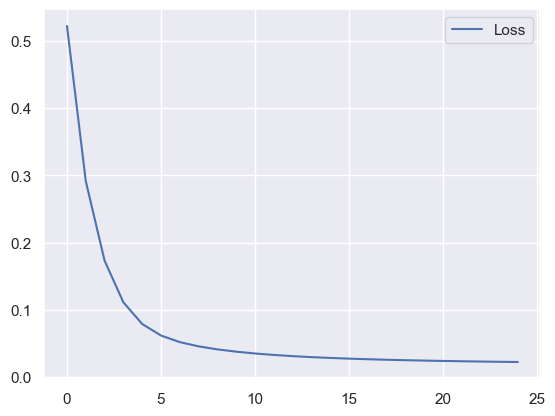

 14/376 [>.............................] - ETA: 1s  

2023-07-04 01:59:42.993880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 01:59:43.067403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - 1s 3ms/step
Running pipeline for target variable: f3_target_regr
Index(['share_events_18', 'share_civilian_deaths', 'event_share_6_stock',
       'refugees_in', 'Adm1_Mean', 'cluster_2', 'share_events_13', 'armedconf',
       'event_share_20_stock', 'event_share_15_stock', 'neighbor_conflict',
       'share_events_1', 'cluster_3', 'num_regions', 'share_events_3',
       'month_cos', 'event_share_17_stock', 'event_share_3_stock',
       'armedconf_since', 'past12', 'share_events_14', 'norm_total_events',
       'share_events_5', 'share_events_19', 'share_nonstate_deaths',
       'share_events_8', 'event_share_18_stock', 'share_events_11',
       'share_events_20', 'year', 'event_share_8_stock', 'share_events_7',
       'share_events_2', 'month', 'share_events_opp', 'event_share_13_stock',
       'country', 'share_events_10', 'share_events_15', 'past120',
       'Adm1_Median', 'refugees_out', 'cluster_0', 'share_events_4',
       'event_share_11

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-04 01:59:46.000545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 01:59:46.187615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 01:59:46.323364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

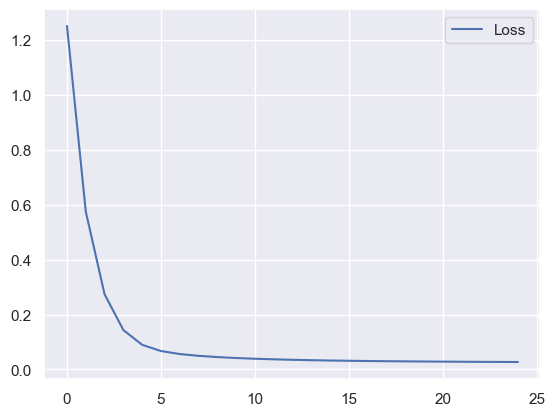

 15/364 [>.............................] - ETA: 1s  

2023-07-04 02:01:00.339522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 02:01:00.414454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


364/364 [==============================] - 1s 2ms/step
Index(['share_events_18', 'event_share_6_stock', 'Adm1_Median', 'Adm1_Mean',
       'cluster_2', 'share_events_13', 'cluster_0', 'event_share_20_stock',
       'share_events_4', 'event_share_15_stock', 'share_events_1', 'cluster_3',
       'event_share_11_stock', 'event_share_9_stock', 'num_regions',
       'share_events_3', 'month_sin', 'month_cos', 'event_share_17_stock',
       'event_share_3_stock', 'share_events_6', 'event_share_7_stock',
       'share_events_14', 'norm_total_events', 'share_events_5',
       'share_events_19', 'share_events_8', 'event_share_16_stock',
       'share_events_16', 'share_events_11', 'share_events_20',
       'event_share_18_stock', 'share_events_9', 'event_share_5_stock',
       'event_share_8_stock', 'event_share_10_stock', 'share_events_7',
       'event_share_19_stock', 'share_events_gov', 'year', 'share_events_2',
       'month', 'share_events_opp', 'share_events_17', 'cluster_1',
       'eve

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-04 02:01:03.074230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 02:01:03.325151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 02:01:03.483696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

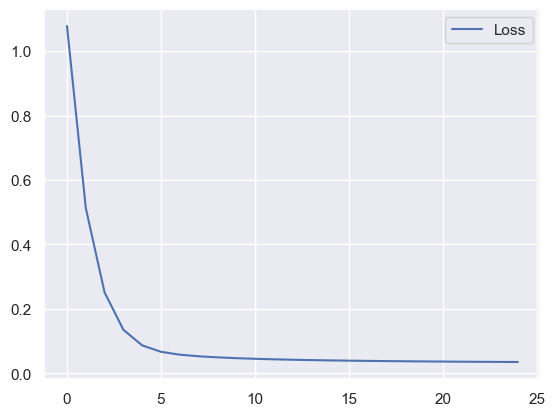

 16/364 [>.............................] - ETA: 1s  

2023-07-04 02:02:19.129327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 02:02:19.199148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


364/364 [==============================] - 1s 2ms/step
Index(['share_civilian_deaths', 'past120', 'refugees_in', 'refugees_out',
       'armedconf', 'neighbor_conflict', 'month_sin', 'month_cos',
       'armedconf_since', 'past12', 'share_nonstate_deaths', 'year', 'past6',
       'deaths_stock', 'month', 'past60', 'escalation', 'share_state_deaths',
       'share_onesided_deaths', 'country', 'deaths_all_pc', 'f3_target_regr',
       'isocode'],
      dtype='object')


0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-04 02:02:21.564113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 02:02:21.728409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 02:02:21.851562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

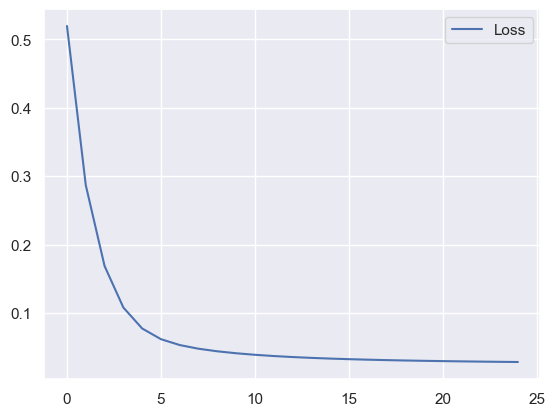

  8/364 [..............................] - ETA: 2s  

2023-07-04 02:03:32.154237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 02:03:32.210114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


364/364 [==============================] - 1s 2ms/step
Running pipeline for target variable: f6_target_regr
Index(['share_events_18', 'share_civilian_deaths', 'event_share_6_stock',
       'refugees_in', 'Adm1_Mean', 'cluster_2', 'share_events_13', 'armedconf',
       'event_share_20_stock', 'event_share_15_stock', 'neighbor_conflict',
       'share_events_1', 'cluster_3', 'num_regions', 'share_events_3',
       'month_cos', 'event_share_17_stock', 'event_share_3_stock',
       'armedconf_since', 'past12', 'share_events_14', 'norm_total_events',
       'share_events_5', 'share_events_19', 'share_nonstate_deaths',
       'share_events_8', 'event_share_18_stock', 'share_events_11',
       'share_events_20', 'year', 'event_share_8_stock', 'share_events_7',
       'share_events_2', 'month', 'share_events_opp', 'event_share_13_stock',
       'country', 'share_events_10', 'share_events_15', 'past120',
       'Adm1_Median', 'refugees_out', 'cluster_0', 'share_events_4',
       'event_share_11

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-04 02:03:34.970060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 02:03:35.138226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 02:03:35.278189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

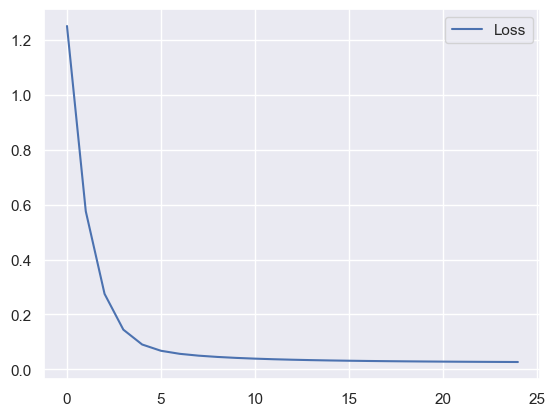

  9/345 [..............................] - ETA: 2s  

2023-07-04 02:04:47.196683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 02:04:47.257009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


345/345 [==============================] - 1s 2ms/step
Index(['share_events_18', 'event_share_6_stock', 'Adm1_Median', 'Adm1_Mean',
       'cluster_2', 'share_events_13', 'cluster_0', 'event_share_20_stock',
       'share_events_4', 'event_share_15_stock', 'share_events_1', 'cluster_3',
       'event_share_11_stock', 'event_share_9_stock', 'num_regions',
       'share_events_3', 'month_sin', 'month_cos', 'event_share_17_stock',
       'event_share_3_stock', 'share_events_6', 'event_share_7_stock',
       'share_events_14', 'norm_total_events', 'share_events_5',
       'share_events_19', 'share_events_8', 'event_share_16_stock',
       'share_events_16', 'share_events_11', 'share_events_20',
       'event_share_18_stock', 'share_events_9', 'event_share_5_stock',
       'event_share_8_stock', 'event_share_10_stock', 'share_events_7',
       'event_share_19_stock', 'share_events_gov', 'year', 'share_events_2',
       'month', 'share_events_opp', 'share_events_17', 'cluster_1',
       'eve

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-04 02:04:49.672693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 02:04:49.845768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 02:04:50.002467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

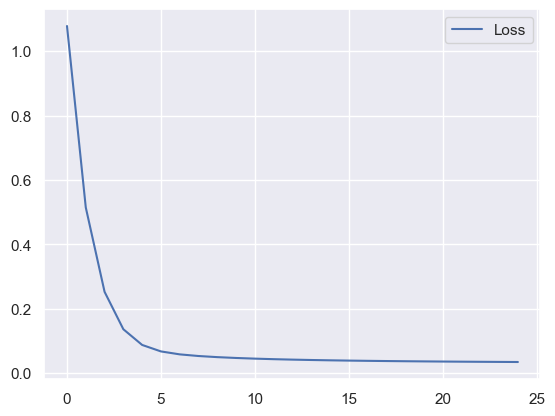

  1/345 [..............................] - ETA: 1:54

2023-07-04 02:06:05.732451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 02:06:05.813036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


345/345 [==============================] - 1s 3ms/step
Index(['share_civilian_deaths', 'past120', 'refugees_in', 'refugees_out',
       'armedconf', 'neighbor_conflict', 'month_sin', 'month_cos',
       'armedconf_since', 'past12', 'share_nonstate_deaths', 'year', 'past6',
       'deaths_stock', 'month', 'past60', 'escalation', 'share_state_deaths',
       'share_onesided_deaths', 'country', 'deaths_all_pc', 'f6_target_regr',
       'isocode'],
      dtype='object')


0epoch [00:00, ?epoch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

2023-07-04 02:06:08.278213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 02:06:08.440038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 02:06:08.605093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

  0%|          | 0.00/351 [00:00<?, ?batch/s]

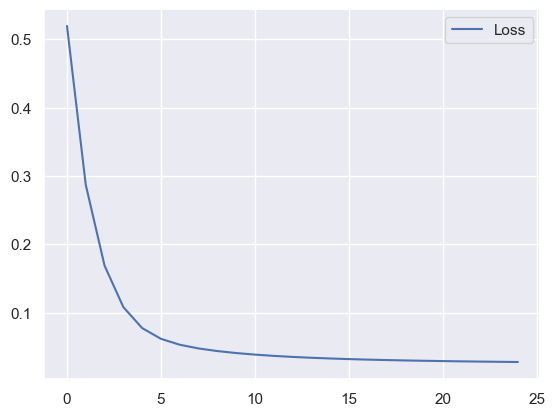

  1/345 [..............................] - ETA: 1:43

2023-07-04 02:07:22.300155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-04 02:07:22.363919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


345/345 [==============================] - 1s 3ms/step


In [25]:
target_variables = ['deaths_all_pc', 'f3_target_regr', 'f6_target_regr']

for target in target_variables:
    print(f"Running pipeline for target variable: {target}")

    result, encoder, reframed_train, reframed_test_comb, sc_comb_test = run_pipeline(df_final, target, combination_vars, 2018, False)
    all_results.append({
        'target': target,
        'reframed_test' : reframed_test_comb,
        'variables': 'combined_vars',
        'y_pred': result['y_pred'],
        'y_test': result['y_test'],
        'mse': result['mse'],
        'mae': result['mae'],
        'r2': result['r2'],
        'trained_model': result['model']
    })

    result, _, _, reframed_test_gdelt, _ = run_pipeline(df_final, target, text_gdelt_vars, 2018, True)
    all_results.append({
        'target': target,
        'reframed_test' : reframed_test_gdelt,
        'variables': 'text_gdelt_vars',
        'y_pred': result['y_pred'],
        'y_test': result['y_test'],
        'mse': result['mse'],
        'mae': result['mae'],
        'r2': result['r2'],
        'trained_model': result['model']
    })

    result, _, _, reframed_test_hist, _ = run_pipeline(df_final, target, historical_vars, 2018, False)
    all_results.append({
        'target': target,
        'reframed_test' : reframed_test_hist,
        'variables': 'historical_vars',
        'y_pred': result['y_pred'],
        'y_test': result['y_test'],
        'mse': result['mse'],
        'mae': result['mae'],
        'r2': result['r2'],
        'trained_model': result['model']
    })


In [26]:
reframed_train  

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  \
isocode year month                                                          
AFG     2000 2       0.010337     0.4815   0.017701   0.084291   0.219366   
             3       0.014597     0.7105   0.032940   0.088323   0.222609   
             4       0.008492     0.1483   0.036678   0.092350   0.220578   
             5       0.013740     0.3774   0.051540   0.096372   0.221291   
             6       0.015287     0.4390   0.057160   0.100389   0.220569   
...                       ...        ...        ...        ...        ...   
ZWE     2017 7       0.019776     0.0000   0.115685   0.002454   0.000978   
             8       0.027355     0.0000   0.111370   0.002474   0.000915   
             9       0.105624     0.0000   0.110174   0.002495   0.000915   
             10      0.040042     0.0000   0.110625   0.002515   0.000915   
             11      0.025945     0.0000   0.115019   0.002536   0.000915   

                    var6(t-1)  var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  \
isocode year month                                                           
AFG     2000 2            0.0   0.017228        1.0   0.000000    0.006141   
             3            0.0   0.020569        1.0   0.003712    0.007923   
             4            0.0   0.028950        1.0   0.002969    0.012342   
             5            0.0   0.032061        1.0   0.002376    0.017294   
             6            0.0   0.038217        1.0   0.004573    0.024980   
...                       ...        ...        ...        ...         ...   
ZWE     2017 7            1.0   0.029176        0.0   0.008019    0.011654   
             8            1.0   0.031544        0.0   0.008483    0.012837   
             9            1.0   0.022569        0.0   0.009853    0.014118   
             10           1.0   0.031259        0.0   0.012579    0.012885   
             11           1.0   0.033374        0.0   0.011713    0.012830   

                    ...  var62(t-0)  var63(t-0)  var64(t-0)  var65(t-0)  \
isocode year month  ...                                                   
AFG     2000 2      ...    0.088092      0.4868    0.059215    0.165397   
             3      ...    0.117626      0.1483    0.078492    0.165397   
             4      ...    0.139459      0.0000    0.092850    0.165397   
             5      ...    0.154871      0.3780    0.105628    0.165397   
             6      ...    0.161489      0.0000    0.135579    0.165397   
...                 ...         ...         ...         ...         ...   
ZWE     2017 7      ...    0.344029      0.0000    0.264825    0.000786   
             8      ...    0.338640      0.0000    0.257201    0.000786   
             9      ...    0.340119      0.0000    0.260575    0.000786   
             10     ...    0.343690      0.0000    0.266281    0.000786   
             11     ...    0.341233      0.0000    0.269839    0.000786   

                    var66(t-0)  var67(t-0)  var68(t-0)  var69(t-0)  \
isocode year month                                                   
AFG     2000 2        0.211404    0.016373    0.014450    0.010130   
             3        0.265996    0.034125    0.014411    0.014964   
             4        0.326449    0.057019    0.023410    0.016211   
             5        0.359973    0.008816    0.030573    0.017921   
             6        0.393195    0.007521    0.014529    0.018511   
...                        ...         ...         ...         ...   
ZWE     2017 7        0.337278    0.000000    0.024425    0.116018   
             8        0.339069    0.000000    0.023675    0.105940   
             9        0.339025    0.000000    0.025776    0.106848   
             10       0.336852    0.000000    0.026836    0.096481   
             11       0.335547    0.000000    0.027389    0.104640   

                    var70(t-0)  var71(t+1)  
isocode year month                          
AFG     2000 2        1.00

In [27]:
test_data_copy = sc_comb_test.copy()

In [28]:
df_results = pd.DataFrame(all_results)

In [29]:
import pickle

with open('lstm_saved_models/all_results.pkl', 'wb') as f:
    pickle.dump(all_results, f)


INFO:tensorflow:Assets written to: ram://34f05fd3-2bc8-4814-97fd-cd8a0fe09e32/assets


INFO:tensorflow:Assets written to: ram://34f05fd3-2bc8-4814-97fd-cd8a0fe09e32/assets


INFO:tensorflow:Assets written to: ram://055e045b-d303-4b12-9387-2afba6b1e74d/assets


INFO:tensorflow:Assets written to: ram://055e045b-d303-4b12-9387-2afba6b1e74d/assets


INFO:tensorflow:Assets written to: ram://fe1ea3f8-c2af-40f5-a3d1-5229dcc7b290/assets


INFO:tensorflow:Assets written to: ram://fe1ea3f8-c2af-40f5-a3d1-5229dcc7b290/assets


INFO:tensorflow:Assets written to: ram://a855b1bd-0404-463f-b744-e9b84933e402/assets


INFO:tensorflow:Assets written to: ram://a855b1bd-0404-463f-b744-e9b84933e402/assets


INFO:tensorflow:Assets written to: ram://5021163e-f9a4-47cf-9f3c-78c2304cf8a4/assets


INFO:tensorflow:Assets written to: ram://5021163e-f9a4-47cf-9f3c-78c2304cf8a4/assets


INFO:tensorflow:Assets written to: ram://134ba04c-19c3-410a-b468-908241801a25/assets


INFO:tensorflow:Assets written to: ram://134ba04c-19c3-410a-b468-908241801a25/assets


INFO:tensorflow:Assets written to: ram://b121b9a5-164b-4376-bc64-2d55ba61f108/assets


INFO:tensorflow:Assets written to: ram://b121b9a5-164b-4376-bc64-2d55ba61f108/assets


INFO:tensorflow:Assets written to: ram://7c3d90aa-e7cb-4214-953b-31ce73f3ee44/assets


INFO:tensorflow:Assets written to: ram://7c3d90aa-e7cb-4214-953b-31ce73f3ee44/assets


INFO:tensorflow:Assets written to: ram://c82a9d0d-64cc-4eec-a876-44f6d074ef47/assets


INFO:tensorflow:Assets written to: ram://c82a9d0d-64cc-4eec-a876-44f6d074ef47/assets


In [30]:
all_results

[{'target': 'deaths_all_pc',
  'reframed_test':                     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  \
  isocode year month                                                          
  AFG     2018 2       0.054644     0.0558   0.094827   0.128995   0.223030   
               3       0.047734     0.0241   0.095627   0.130875   0.223018   
               4       0.058278     0.0721   0.093782   0.132746   0.223018   
               5       0.066459     0.0970   0.094441   0.134608   0.223030   
               6       0.078376     0.0372   0.093966   0.136461   0.223030   
  ...                       ...        ...        ...        ...        ...   
  ZWE     2022 10      0.020400     0.0000   0.127809   0.002957   0.000915   
               11      0.026689     0.0000   0.127694   0.002957   0.000915   
               12      0.026176     0.0000   0.128076   0.002957   0.000915   
          2023 1       0.026705     0.0000   0.135920   0.002957   0.000915   
      

In [31]:
df_results

target                                      reframed_test  \
0   deaths_all_pc                      var1(t-1)  var2(t-1)  var3...   
1   deaths_all_pc                      var1(t-1)  var2(t-1)  var3...   
2   deaths_all_pc                      var1(t-1)  var2(t-1)  var3...   
3  f3_target_regr                      var1(t-1)  var2(t-1)  var3...   
4  f3_target_regr                      var1(t-1)  var2(t-1)  var3...   
5  f3_target_regr                      var1(t-1)  var2(t-1)  var3...   
6  f6_target_regr                      var1(t-1)  var2(t-1)  var3...   
7  f6_target_regr                      var1(t-1)  var2(t-1)  var3...   
8  f6_target_regr                      var1(t-1)  var2(t-1)  var3...   

         variables                                             y_pred  \
0    combined_vars  [[1.9341017], [1.8500348], [2.0333457], [2.298...   
1  text_gdelt_vars  [[0.63057417], [0.6256852], [0.634079], [0.648...   
2  historical_vars  [[1.8778917], [1.8012524], [1.9655277], [2.210...   
3    combined_vars  [[1.0812882], [1.0443722], [1.1004323], [1.150...   
4  text_gdelt_vars  [[0.6867065], [0.67985636], [0.6866591], [0.69...   
5  historical_vars  [[1.0082227], [0.98265254], [1.0283868], [1.06...   
6    combined_vars  [[1.0985596], [1.0595278], [1.1144874], [1.164...   
7  text_gdelt_vars  [[0.72038114], [0.7121368], [0.7183937], [0.73...   
8  historical_vars  [[1.0303385], [1.0026749], [1.0478799], [1.083...   

                                              y_test       mse       mae  \
0  [[3.9140443846394617], [5.273630425292115], [6...  0.655596  0.076431   
1  [[3.9140443846394617], [5.273630425292115], [6...  0.808379  0.104574   
2  [[3.9140443846394617], [5.273630425292115], [6...  0.663537  0.078426   
3  [[5.311911349283525], [5.566283475162089], [6....  0.479977  0.089160   
4  [[5.311911349283525], [5.566283475162089], [6....  0.532581  0.102646   
5  [[5.311911349283525], [5.566283475162089], [6....  0.486893  0.091668   
6  [[5.960913288485983], [6.384082996125188], [6....  0.352108  0.087479   
7  [[5.960913288485983], [6.384082996125188], [6....  0.398962  0.102491   
8  [[5.960913288485983], [6.384082996125188], [6....  0.357141  0.090017   

         r2                                      trained_model  
0  0.247145  <keras.engine.sequential.Sequential object at ...  
1  0.071696  <keras.engine.sequential.Sequential object at ...  
2  0.238026  <keras.engine.sequential.Sequential object at ...  
3  0.196122  <keras.engine.sequential.Sequential object at ...  
4  0.108020  <keras.engine.sequential.Sequential object at ...  
5  0.184539  <keras.engine.sequential.Sequential object at ...  
6  0.243101  <keras.engine.sequential.Sequential object at ...  
7  0.142382  <keras.engine.sequential.Sequential object at ...  
8  0.232281  <keras.engine.sequential.Sequential object at ...

In [32]:
targets_t1 = ['deaths_all_pc']
targets_t3 = ['f3_target_regr']
targets_t6 = ['f6_target_regr']

In [33]:
# Initialize dictionaries to store the final DataFrames for each target
final_dfs_t1 = {}
final_dfs_t3 = {}
final_dfs_t6 = {}

# Iterate over all results
for result in all_results:
    target = result['target']
    reframed_test = result['reframed_test']
    variables = result['variables']

    # Create a DataFrame for the target using the index from reframed_test
    final_df = pd.DataFrame(index=reframed_test.index)

    # Add true value columns
    true_values = result['y_test'].flatten()
    final_df[f"{target}_true"] = true_values

    # Add predicted value columns
    predictions_shifted = pd.Series(result['y_pred'].flatten())
    final_df[f"{target}_{variables}_pred"] = predictions_shifted.values

    # Drop rows with NaN values
    final_df.dropna(inplace=True)

    # Use a tuple of target and variables as the key in the dictionary
    key = (target, variables)

    # Store the final DataFrame for the target in the corresponding dictionary
    if target in targets_t1:
        final_dfs_t1[key] = final_df
    elif target in targets_t3:
        final_dfs_t3[key] = final_df
    elif target in targets_t6:
        final_dfs_t6[key] = final_df



In [34]:
final_dfs_t1

{('deaths_all_pc',
  'combined_vars'):                     deaths_all_pc_true  deaths_all_pc_combined_vars_pred
 isocode year month                                                      
 AFG     2018 2                3.914044                          1.934102
              3                5.273630                          1.850035
              4                6.748059                          2.033346
              5                4.677161                          2.298884
              6                8.531181                          2.146390
 ...                                ...                               ...
 ZWE     2022 10               0.000000                          0.000000
              11               0.000000                          0.000000
              12               0.000000                          0.000000
         2023 1                0.000000                          0.000000
              2                0.000000                          0.000000


In [35]:
final_dfs_t1

{('deaths_all_pc',
  'combined_vars'):                     deaths_all_pc_true  deaths_all_pc_combined_vars_pred
 isocode year month                                                      
 AFG     2018 2                3.914044                          1.934102
              3                5.273630                          1.850035
              4                6.748059                          2.033346
              5                4.677161                          2.298884
              6                8.531181                          2.146390
 ...                                ...                               ...
 ZWE     2022 10               0.000000                          0.000000
              11               0.000000                          0.000000
              12               0.000000                          0.000000
         2023 1                0.000000                          0.000000
              2                0.000000                          0.000000


In [36]:
# Get DataFrames for 'deaths_all_pc' from final_dfs_t1
df_combined = final_dfs_t1[('deaths_all_pc', 'combined_vars')]
df_text_gdelt = final_dfs_t1[('deaths_all_pc', 'text_gdelt_vars')]
df_historical = final_dfs_t1[('deaths_all_pc', 'historical_vars')]

# Merge these DataFrames on index
result_df = pd.DataFrame(df_combined["deaths_all_pc_true"])
result_df["combined_vars_pred"] = df_combined["deaths_all_pc_combined_vars_pred"]
result_df["text_gdelt_vars_pred"] = df_text_gdelt["deaths_all_pc_text_gdelt_vars_pred"]
result_df["historical_vars_pred"] = df_historical["deaths_all_pc_historical_vars_pred"]

result_df.to_csv('lstm_metrics_pred/predictions_reg_deaths.csv')


In [37]:

df_combined = final_dfs_t3[('f3_target_regr', 'combined_vars')]
df_text_gdelt = final_dfs_t3[('f3_target_regr', 'text_gdelt_vars')]
df_historical = final_dfs_t3[('f3_target_regr', 'historical_vars')]

# Merge these DataFrames on index
result_df = pd.DataFrame(df_combined["f3_target_regr_true"])
result_df["combined_vars_pred"] = df_combined["f3_target_regr_combined_vars_pred"]
result_df["text_gdelt_vars_pred"] = df_text_gdelt["f3_target_regr_text_gdelt_vars_pred"]
result_df["historical_vars_pred"] = df_historical["f3_target_regr_historical_vars_pred"]

result_df.to_csv('lstm_metrics_pred/predictions_reg_f3.csv')

In [38]:
df_combined = final_dfs_t6[('f6_target_regr', 'combined_vars')]
df_text_gdelt = final_dfs_t6[('f6_target_regr', 'text_gdelt_vars')]
df_historical = final_dfs_t6[('f6_target_regr', 'historical_vars')]

# Merge these DataFrames on index
result_df = pd.DataFrame(df_combined["f6_target_regr_true"])
result_df["combined_vars_pred"] = df_combined["f6_target_regr_combined_vars_pred"]
result_df["text_gdelt_vars_pred"] = df_text_gdelt["f6_target_regr_text_gdelt_vars_pred"]
result_df["historical_vars_pred"] = df_historical["f6_target_regr_historical_vars_pred"]

result_df.to_csv('lstm_metrics_pred/predictions_reg_f6.csv')

## Interpretation

In [39]:
# Sorting by year, month, and isocode
final_df_sorted = final_dfs_t1[('deaths_all_pc', 'combined_vars')]

y_pred = final_df_sorted['deaths_all_pc_combined_vars_pred']
y_test = final_df_sorted['deaths_all_pc_true']

print(len(y_pred), len(y_test))

# Use the same index as in final_df_sorted
index = final_df_sorted.index
pa = pd.DataFrame(index=index)

pa['Prediction'] = y_pred
pa['Actual Values'] = y_test
pa.head()


12017 12017


Prediction  Actual Values
isocode year month                           
AFG     2018 2        1.934102       3.914044
             3        1.850035       5.273630
             4        2.033346       6.748059
             5        2.298884       4.677161
             6        2.146390       8.531181

In [40]:
pa['Actual Values'].sum()

1218.1690142994494

RMSE:  0.8096885826127815


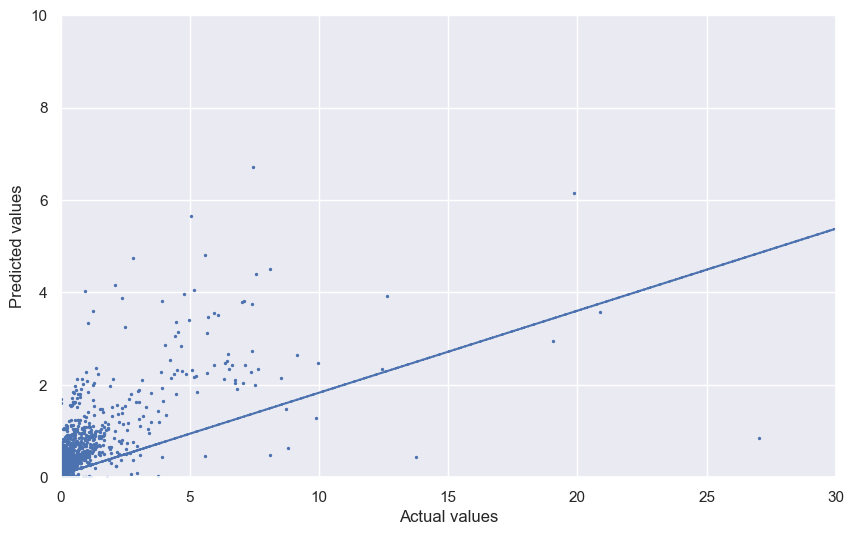

In [41]:
df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

# Sort df
df_sorted = df.sort_index(level=['isocode', 'year', 'month'])

# Extract sorted y_test and y_pred
y_test_sorted = df_sorted['y_test']
y_pred_sorted = df_sorted['y_pred']

rmse = sqrt(mean_squared_error(y_test_sorted, y_pred_sorted))
print('RMSE: ', rmse)

plt.figure(figsize=(10, 6))
plt.scatter(y_test_sorted, y_pred_sorted, s=2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.xlim([0, 30])  # adjust as necessary
plt.ylim([0, 10])  # adjust as necessary

# Fit a line to the predictions
z = np.polyfit(y_test_sorted, y_pred_sorted, 1)
p = np.poly1d(z)
plt.plot(y_test_sorted, p(y_test_sorted), "b--")
plt.show()

Metrics

In [42]:

mse = mean_squared_error(y_test_sorted, y_pred_sorted)
print('Mean Squared Error: ', mse)
rmse = np.sqrt(mse)
print('Root Mean Squared Error: ', rmse)
mae = mean_absolute_error(y_test_sorted, y_pred_sorted)
print('Mean Absolute Error: ', mae)
r2 = r2_score(y_test_sorted, y_pred_sorted)
print('R-squared score: ', r2)


Mean Squared Error:  0.6555956008134952
Root Mean Squared Error:  0.8096885826127815
Mean Absolute Error:  0.07643051736065164
R-squared score:  0.247145246546413


In [43]:
def get_regression_metrics(all_results, target: str, plot=True):
    """Function to return the MSE, RMSE, MAE, and R2 values for a given target"""

    for result in all_results:
        # skip if this result isn't for the target we're interested in
        if result['target'] != target:
            continue

        y_test = np.array(result['y_test']).flatten()
        y_pred = np.array(result['y_pred']).flatten()

        # create DataFrame with y_test and y_pred
        df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

        df_sorted = df.sort_index(level=['isocode', 'year', 'month'])

        # extract sorted y_test and y_pred
        y_test_sorted = df_sorted['y_test']
        y_pred_sorted = df_sorted['y_pred']

        # calculate metrics
        mse = mean_squared_error(y_test_sorted, y_pred_sorted)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_sorted, y_pred_sorted)
        r2 = r2_score(y_test_sorted, y_pred_sorted)
        
        print(f'Model: {result["variables"]}')
        print(f'Mean Squared Error: {mse:.3f}')
        print(f'Root Mean Squared Error: {rmse:.3f}')
        print(f'Mean Absolute Error: {mae:.3f}')
        print(f'R-squared score: {r2:.3f}\n')
        
        if plot:
            plt.figure(figsize=(10, 6))

            # filter out zero values
            non_zero_mask = ~((y_test_sorted == 0) & (y_pred_sorted == 0))
            y_test_filtered = y_test_sorted[non_zero_mask]
            y_pred_filtered = y_pred_sorted[non_zero_mask]

            plt.scatter(y_test_filtered, y_pred_filtered, s=2)
            plt.xlabel('Actual values')
            plt.ylabel('Predicted values')

            # set the limits of the x and y axes
            xlim_low = np.percentile(y_test_filtered, 5)
            xlim_high = np.percentile(y_test_filtered, 95)
            ylim_low = np.percentile(y_pred_filtered, 5)
            ylim_high = np.percentile(y_pred_filtered, 95)
                    
            plt.xlim([xlim_low, xlim_high])
            plt.ylim([ylim_low, ylim_high])

            # fit a line to the predictions
            z = np.polyfit(y_test_filtered, y_pred_filtered, 1)
            p = np.poly1d(z)
            plt.plot(y_test_filtered, p(y_test_filtered), "b--")
            plt.title(f'Predicted vs Actual values for {target} using {result["variables"]}')
            plt.show()



Model: combined_vars
Mean Squared Error: 0.656
Root Mean Squared Error: 0.810
Mean Absolute Error: 0.076
R-squared score: 0.247



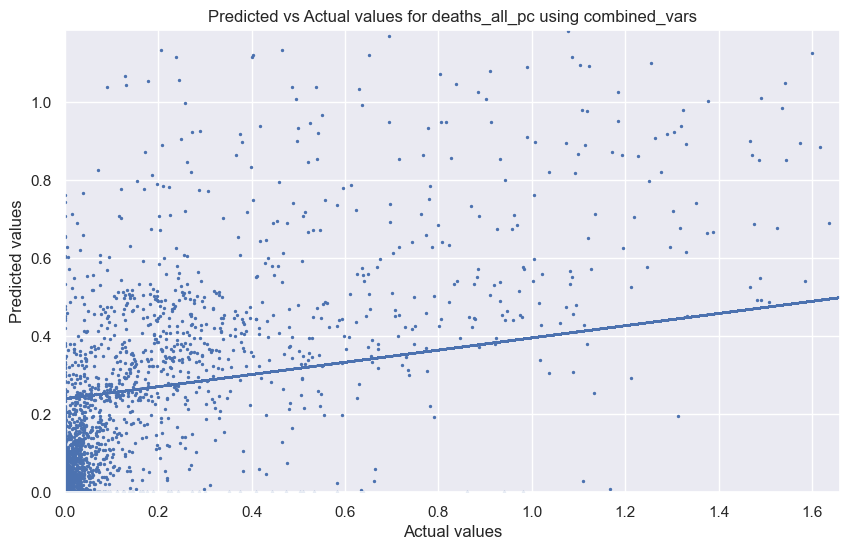

Model: text_gdelt_vars
Mean Squared Error: 0.808
Root Mean Squared Error: 0.899
Mean Absolute Error: 0.105
R-squared score: 0.072



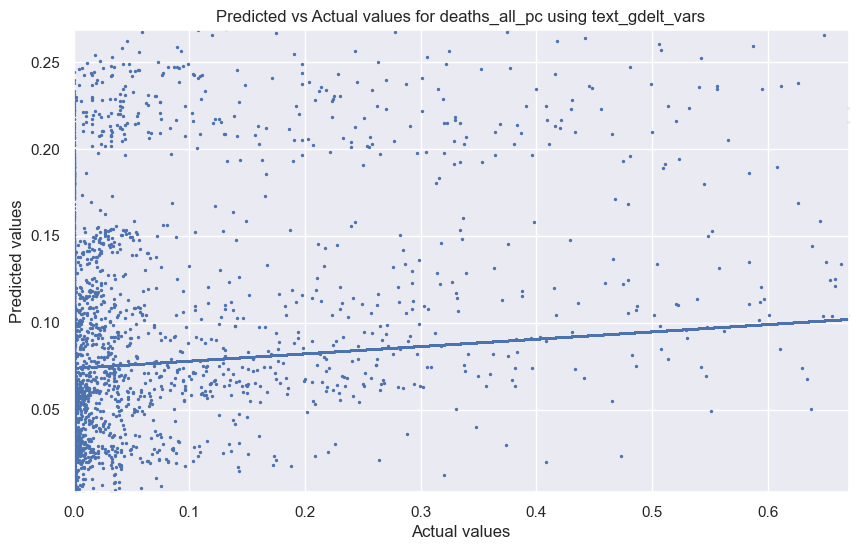

Model: historical_vars
Mean Squared Error: 0.664
Root Mean Squared Error: 0.815
Mean Absolute Error: 0.078
R-squared score: 0.238



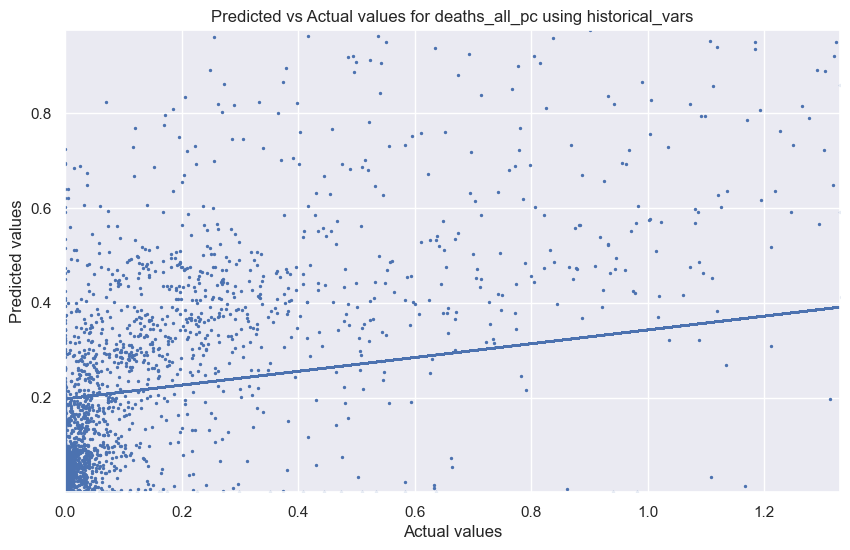

In [44]:
get_regression_metrics(all_results, 'deaths_all_pc')

Model: combined_vars
Mean Squared Error: 0.480
Root Mean Squared Error: 0.693
Mean Absolute Error: 0.089
R-squared score: 0.196



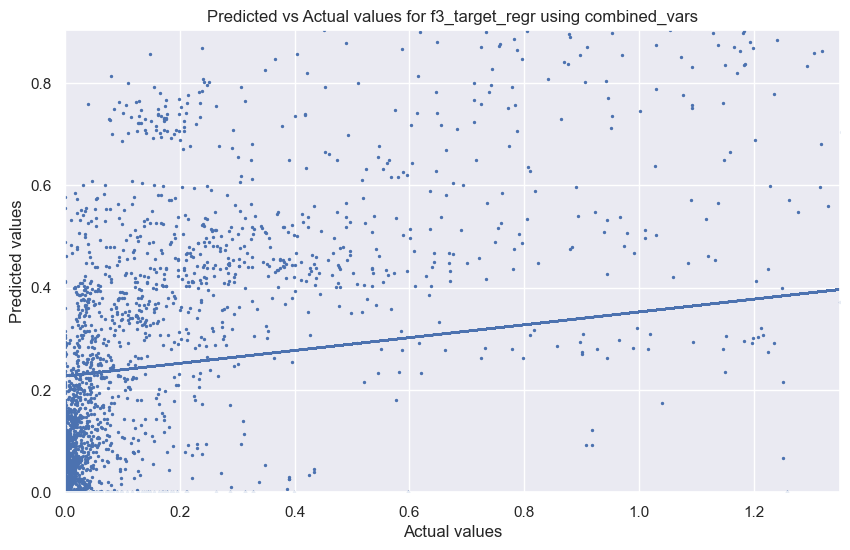

Model: text_gdelt_vars
Mean Squared Error: 0.533
Root Mean Squared Error: 0.730
Mean Absolute Error: 0.103
R-squared score: 0.108



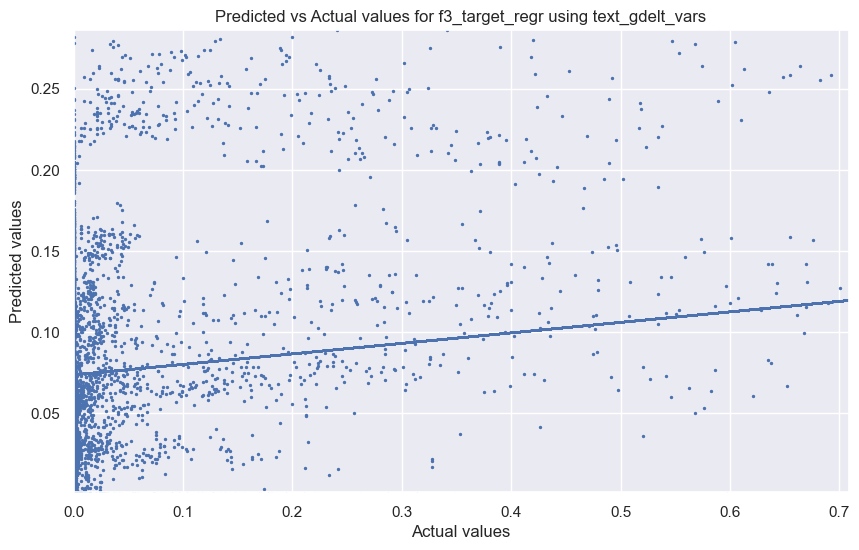

Model: historical_vars
Mean Squared Error: 0.487
Root Mean Squared Error: 0.698
Mean Absolute Error: 0.092
R-squared score: 0.185



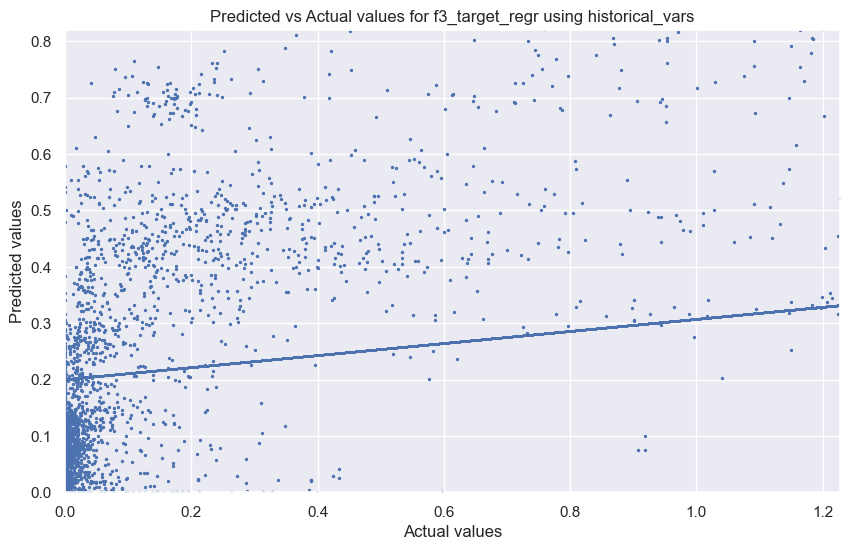

In [45]:
get_regression_metrics(all_results, 'f3_target_regr')

Model: combined_vars
Mean Squared Error: 0.352
Root Mean Squared Error: 0.593
Mean Absolute Error: 0.087
R-squared score: 0.243



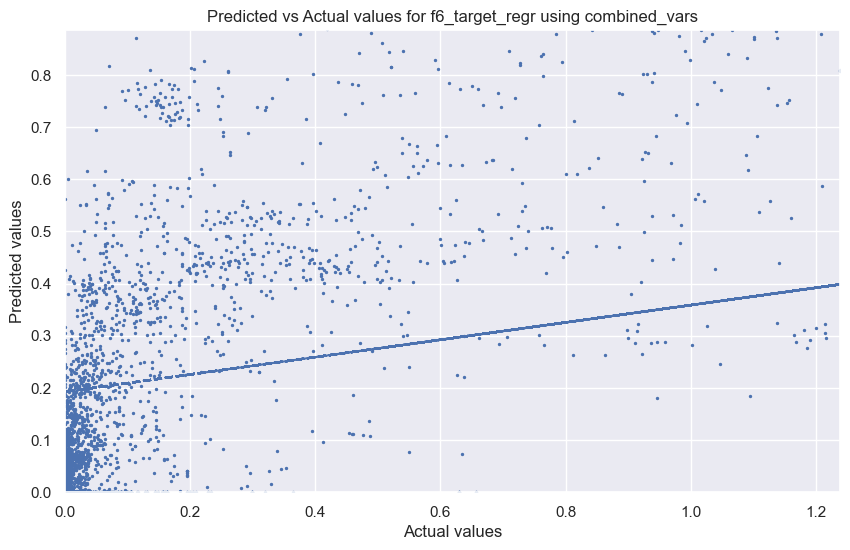

Model: text_gdelt_vars
Mean Squared Error: 0.399
Root Mean Squared Error: 0.632
Mean Absolute Error: 0.102
R-squared score: 0.142



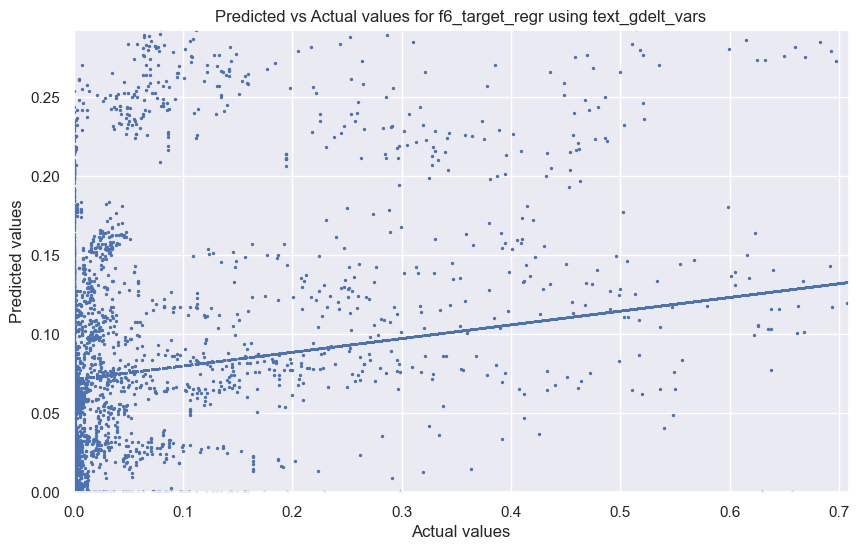

Model: historical_vars
Mean Squared Error: 0.357
Root Mean Squared Error: 0.598
Mean Absolute Error: 0.090
R-squared score: 0.232



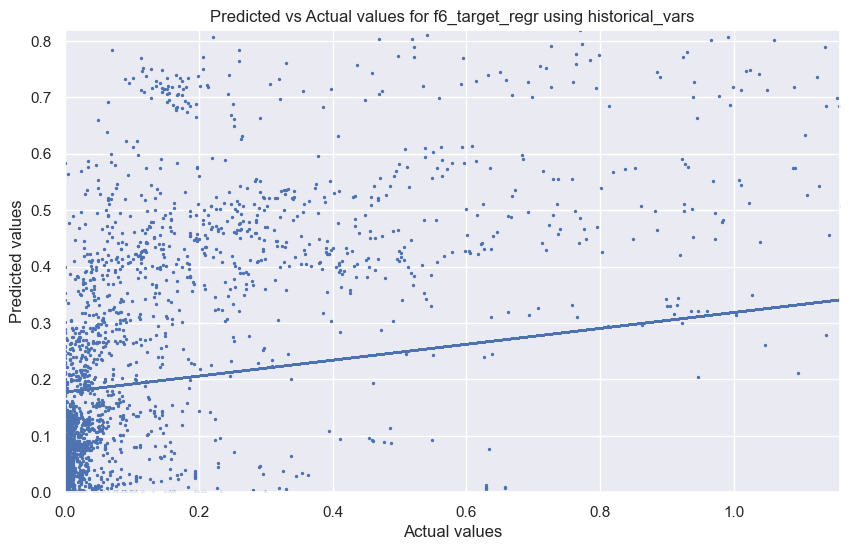

In [46]:
get_regression_metrics(all_results, 'f6_target_regr')

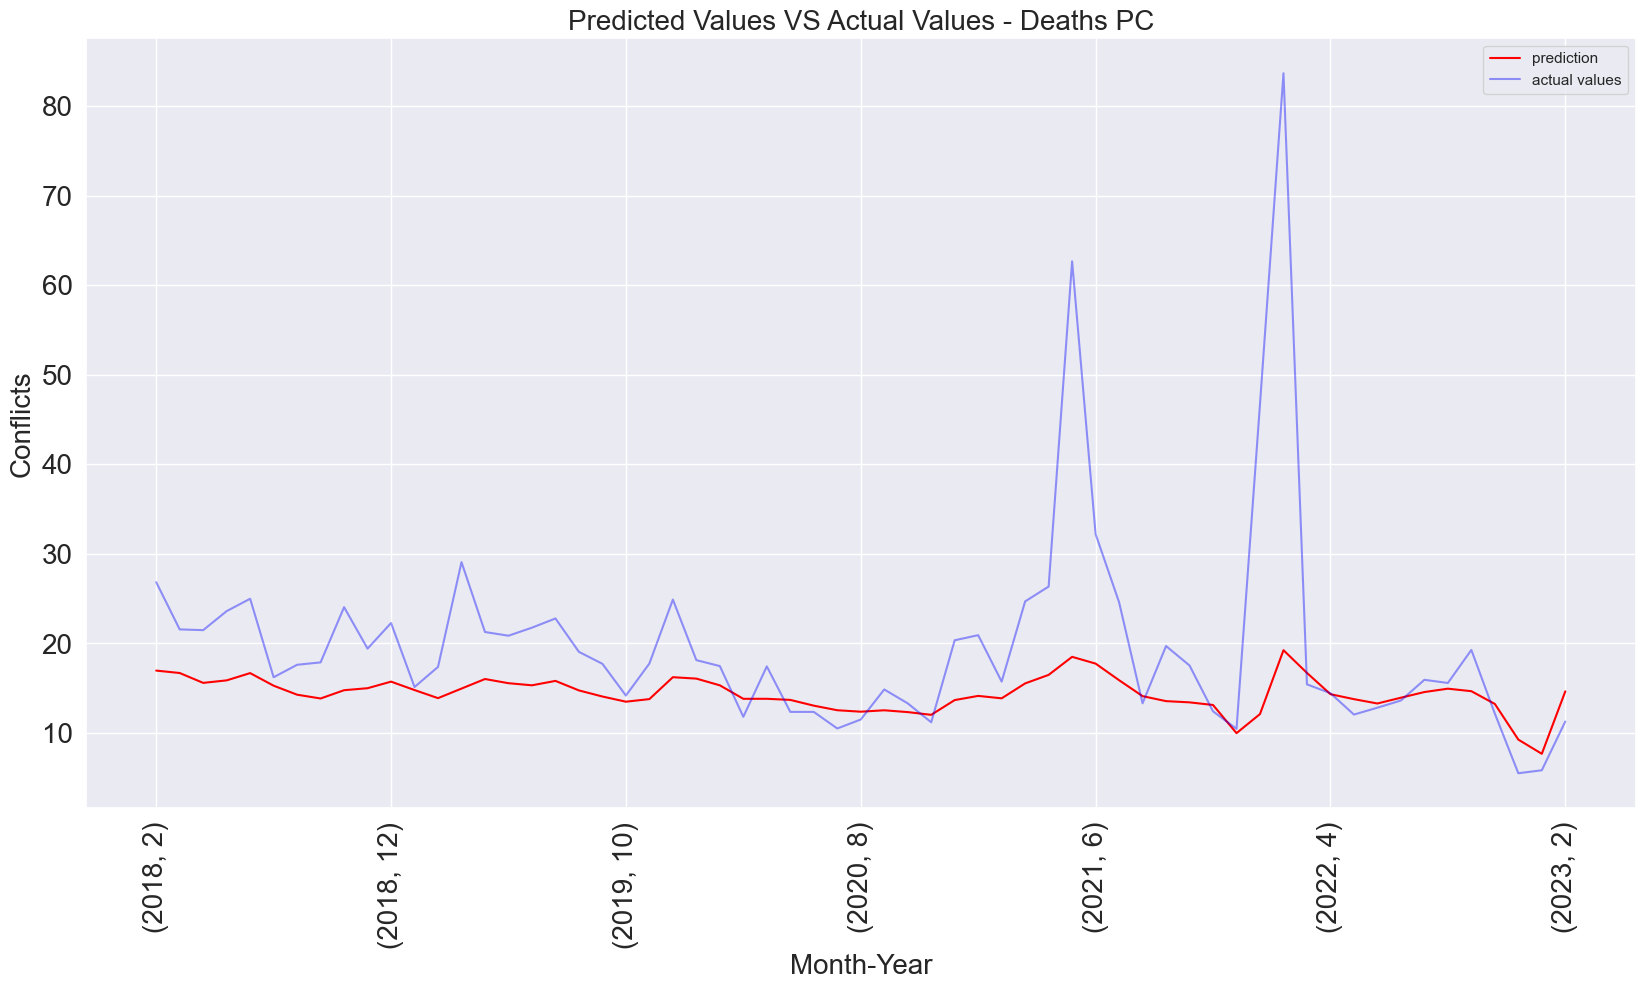

In [47]:
# Shift predictions back by one time step just for the visual representation
pa['Shifted Prediction'] = pa['Prediction'].shift(-1)

plt.figure(figsize=(20,10))
pa['Shifted Prediction'][:-1].groupby(level=['year', 'month']).sum().plot(kind='line', label='prediction', color='red', alpha=1)
pa['Actual Values'][1:].groupby(level=['year', 'month']).sum().plot(kind='line', label='actual values', color='blue', alpha=0.4)

plt.xticks(rotation=90, size=20)
plt.yticks(size=20)

plt.ylabel('Conflicts', fontsize=20)
plt.xlabel('Month-Year', fontsize=20)
plt.title('Predicted Values VS Actual Values - Deaths PC', fontsize=20)
plt.legend()


In [48]:
# initialize an empty DataFrame
metrics_df = pd.DataFrame()

# populate the DataFrame with the metrics for each model
for result in all_results:
    # Extract the model name from the 'target' and 'variables' fields
    model_name = f"{result['target']}_{result['variables']}"

    # create a row for this model in the DataFrame
    metrics_df.loc[model_name, 'mae'] = result['mae']
    metrics_df.loc[model_name, 'mse'] = result['mse']
    metrics_df.loc[model_name, 'r2'] = result['r2']

In [49]:
metrics_df

mae       mse        r2
deaths_all_pc_combined_vars     0.076431  0.655596  0.247145
deaths_all_pc_text_gdelt_vars   0.104574  0.808379  0.071696
deaths_all_pc_historical_vars   0.078426  0.663537  0.238026
f3_target_regr_combined_vars    0.089160  0.479977  0.196122
f3_target_regr_text_gdelt_vars  0.102646  0.532581  0.108020
f3_target_regr_historical_vars  0.091668  0.486893  0.184539
f6_target_regr_combined_vars    0.087479  0.352108  0.243101
f6_target_regr_text_gdelt_vars  0.102491  0.398962  0.142382
f6_target_regr_historical_vars  0.090017  0.357141  0.232281

In [50]:
metrics_df.to_csv('lstm_metrics_pred/metrics_regressor.csv')

Predicting using pretrained model but now for a subset of deadliest countries. 

In [51]:
def get_trained_model(target, variables):
    for result in all_results:
        if result['target'] == target and result['variables'] == variables:
            return result['trained_model']
    return None

# usage
model_combined = get_trained_model('deaths_all_pc', 'combined_vars')

if model_combined is not None:
    print("Model found!")
    # do something with the model here
else:
    print("No model found for this target and variables combination.")


Model found!


In [52]:
def plot_country_data(df_key, top_10_country_names, shift):
    if df_key in final_dfs_t1:
        final_df = final_dfs_t1[df_key]
    elif df_key in final_dfs_t3:
        final_df = final_dfs_t3[df_key]
    elif df_key in final_dfs_t6:
        final_df = final_dfs_t6[df_key]
    else:
        return "DataFrame not found"

    final_df['country_name'] = final_df.index.get_level_values('isocode').map(get_country_name)

    for country_name in top_10_country_names:
        # Get data for this country
        country_data = final_df[final_df['country_name'] == country_name].copy()

        # Generate predictions and true values
        y_pred = country_data[f"{df_key[0]}_{df_key[1]}_pred"]
        y_test = country_data[f"{df_key[0]}_true"]

        # Shift predictions back by one time step
        y_pred_shifted = y_pred.shift(shift)

        # Calculate errors
        mae = mean_absolute_error(y_test[:shift], y_pred_shifted[:shift])
        mse = mean_squared_error(y_test[:shift], y_pred_shifted[:shift])

        print('{} - Mean Absolute Error: {}, Mean Squared Error: {}'.format(country_name, mae, mse))

        pa = pd.DataFrame(index=country_data.index)
        pa['Prediction'] = y_pred_shifted
        pa['Actual Values'] = y_test  # Flatten to get a 1D array for plotting

        # Create 'Date' directly from 'country_data.index'
        pa['Date'] = pd.to_datetime(country_data.index.get_level_values('year').astype(str) + '-' + country_data.index.get_level_values('month').astype(str) + '-01')

        plt.figure(figsize=(20, 10))
        plt.plot(pa['Date'], pa['Prediction'], label='prediction', color='red', alpha=1)
        plt.plot(pa['Date'], pa['Actual Values'], label='actual values', color='blue', alpha=0.4)
        plt.xticks(rotation=90, size=20)
        plt.yticks(size=20)

        plt.ylabel('Deaths', fontsize=20)
        plt.xlabel('Date', fontsize=20)
        plt.title('Predicted Values VS Actual Values - Deaths Per Capita in {}'.format(country_name), fontsize=20)
        plt.legend()
        plt.show()


Syrian Arab Republic - Mean Absolute Error: 1.52301886425358, Mean Squared Error: 5.037944456323075


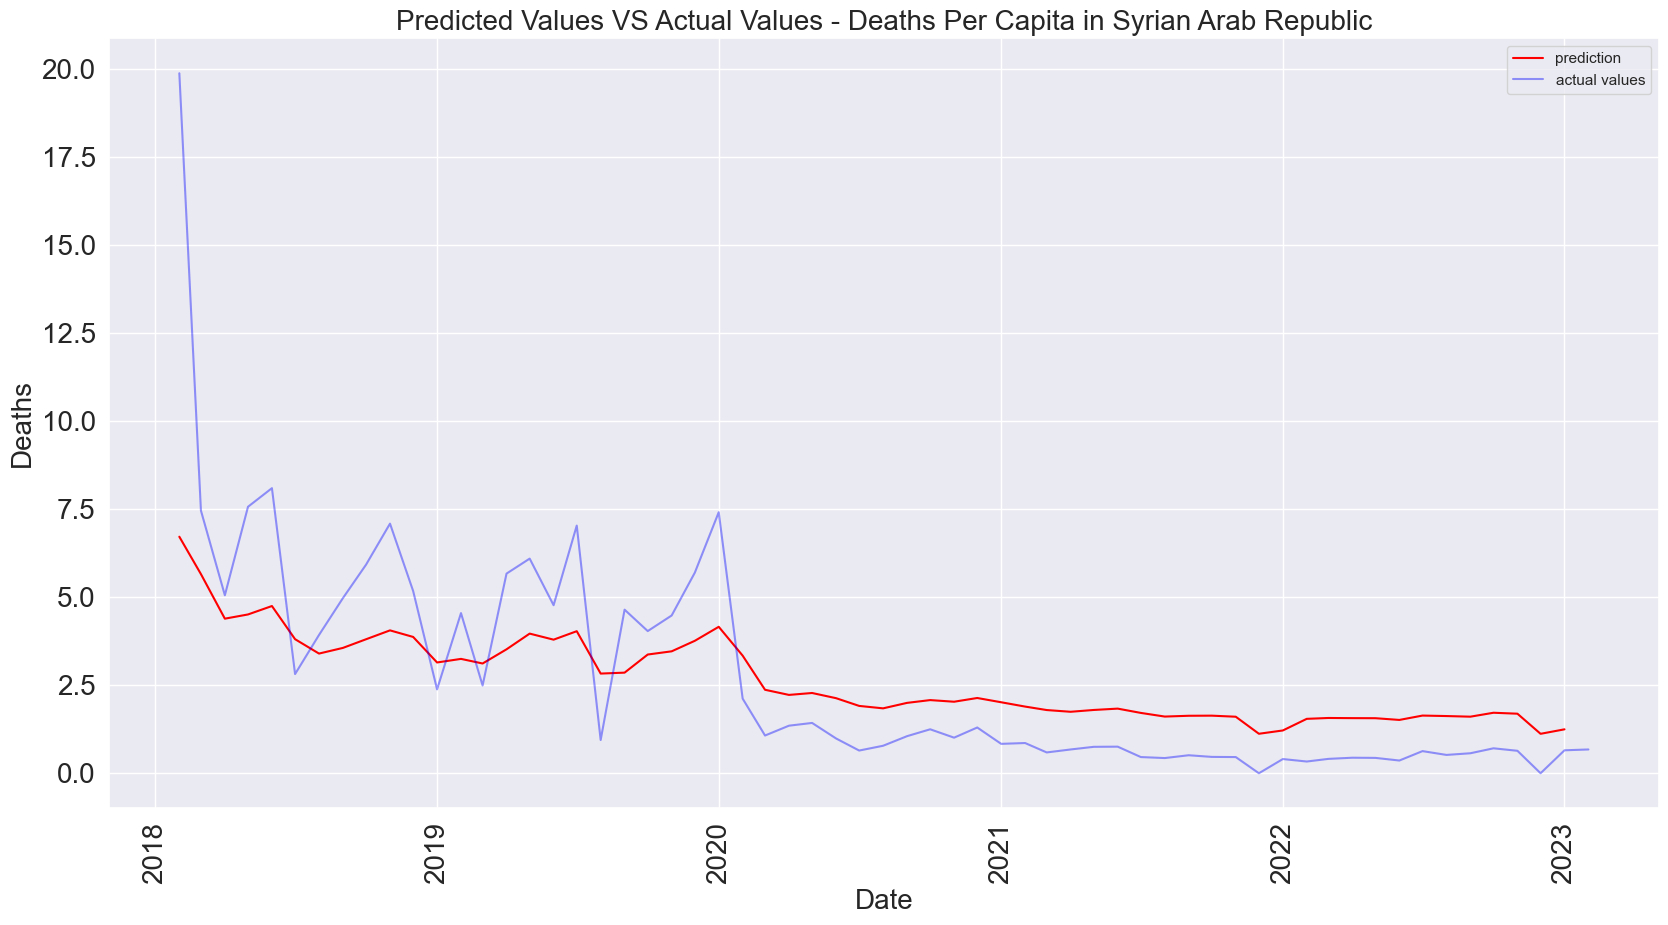

Afghanistan - Mean Absolute Error: 3.137122019592929, Mean Squared Error: 20.495572435185828


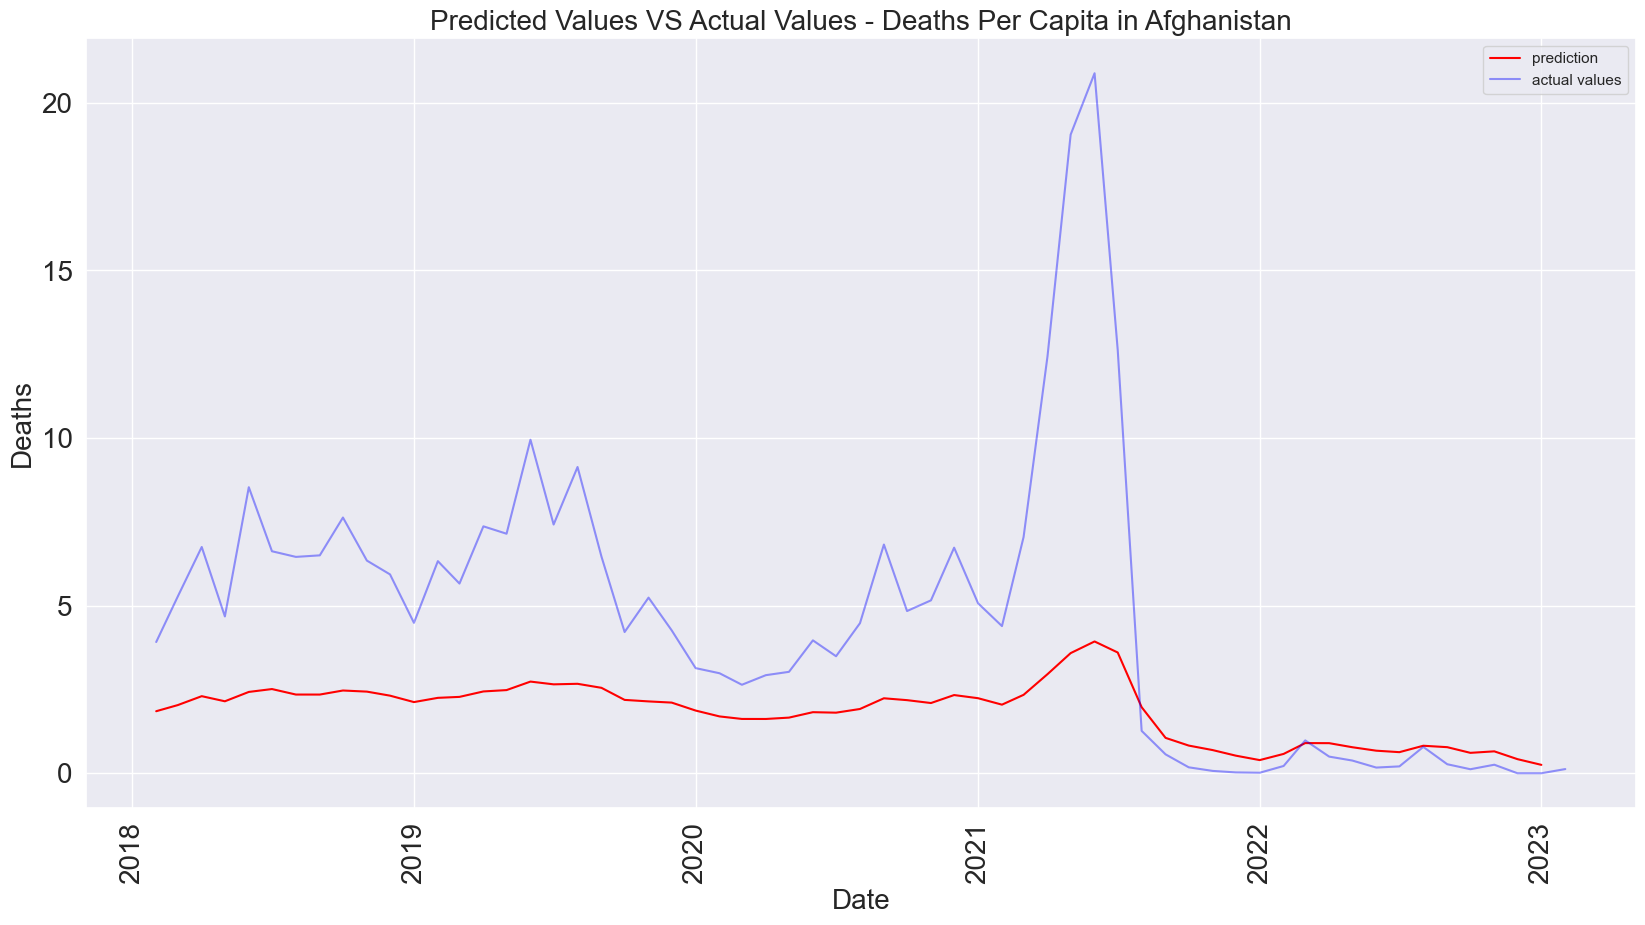

Central African Republic - Mean Absolute Error: 0.532067678018475, Mean Squared Error: 0.5406205930661759


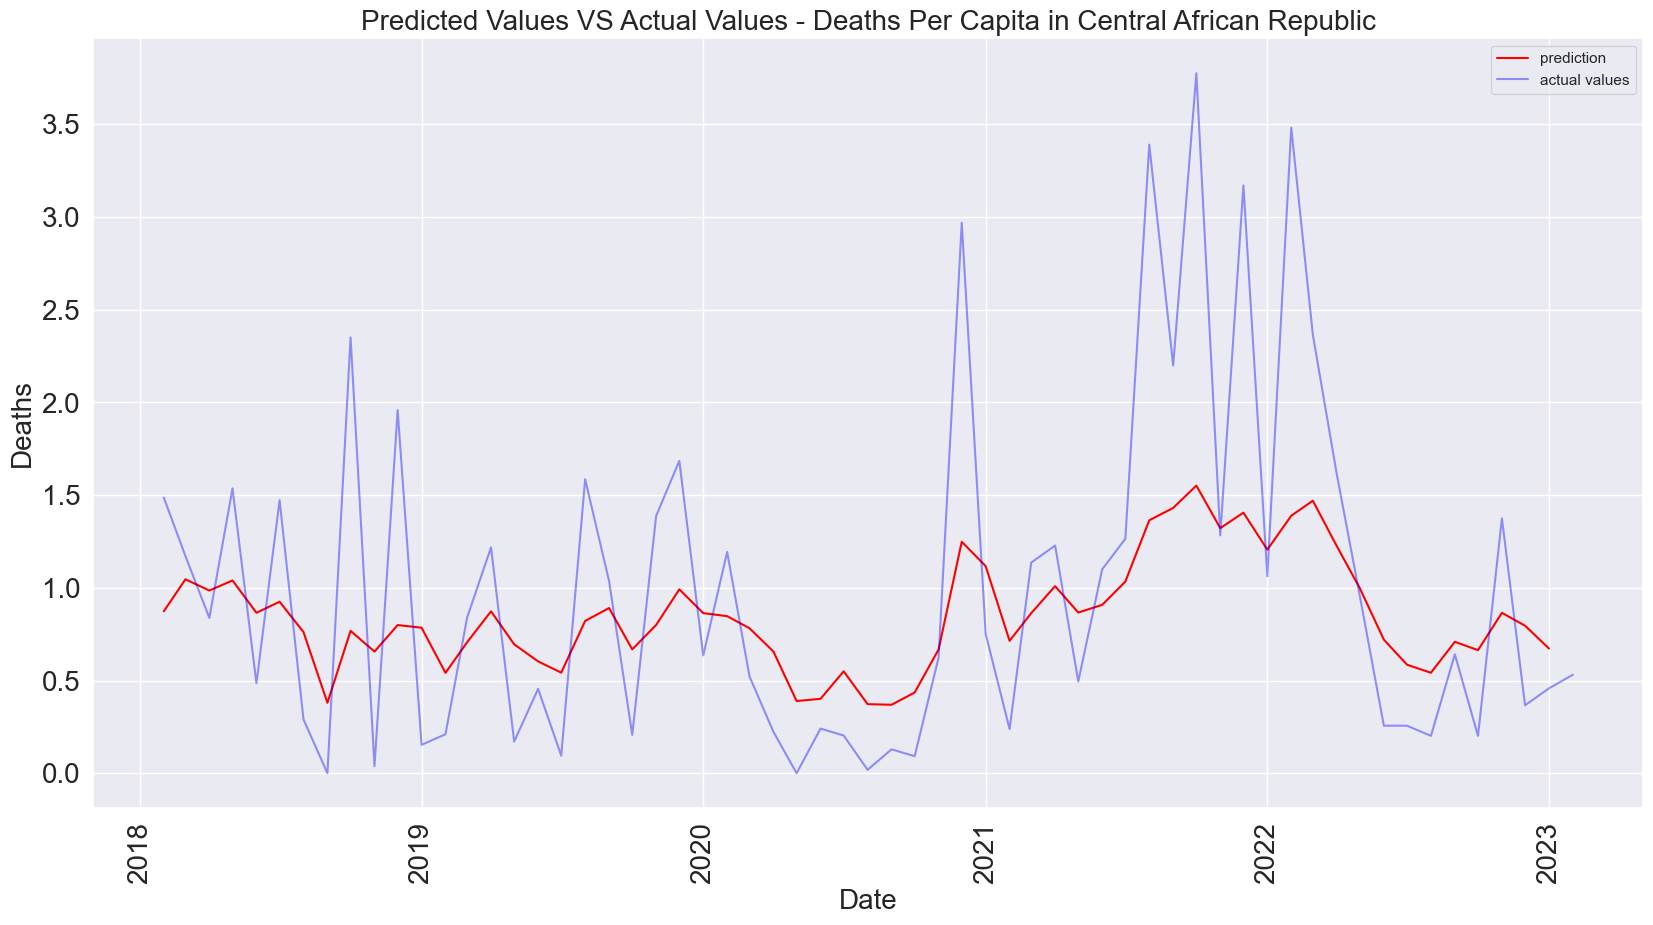

Somalia - Mean Absolute Error: 0.4240833958914024, Mean Squared Error: 0.32377754349252286


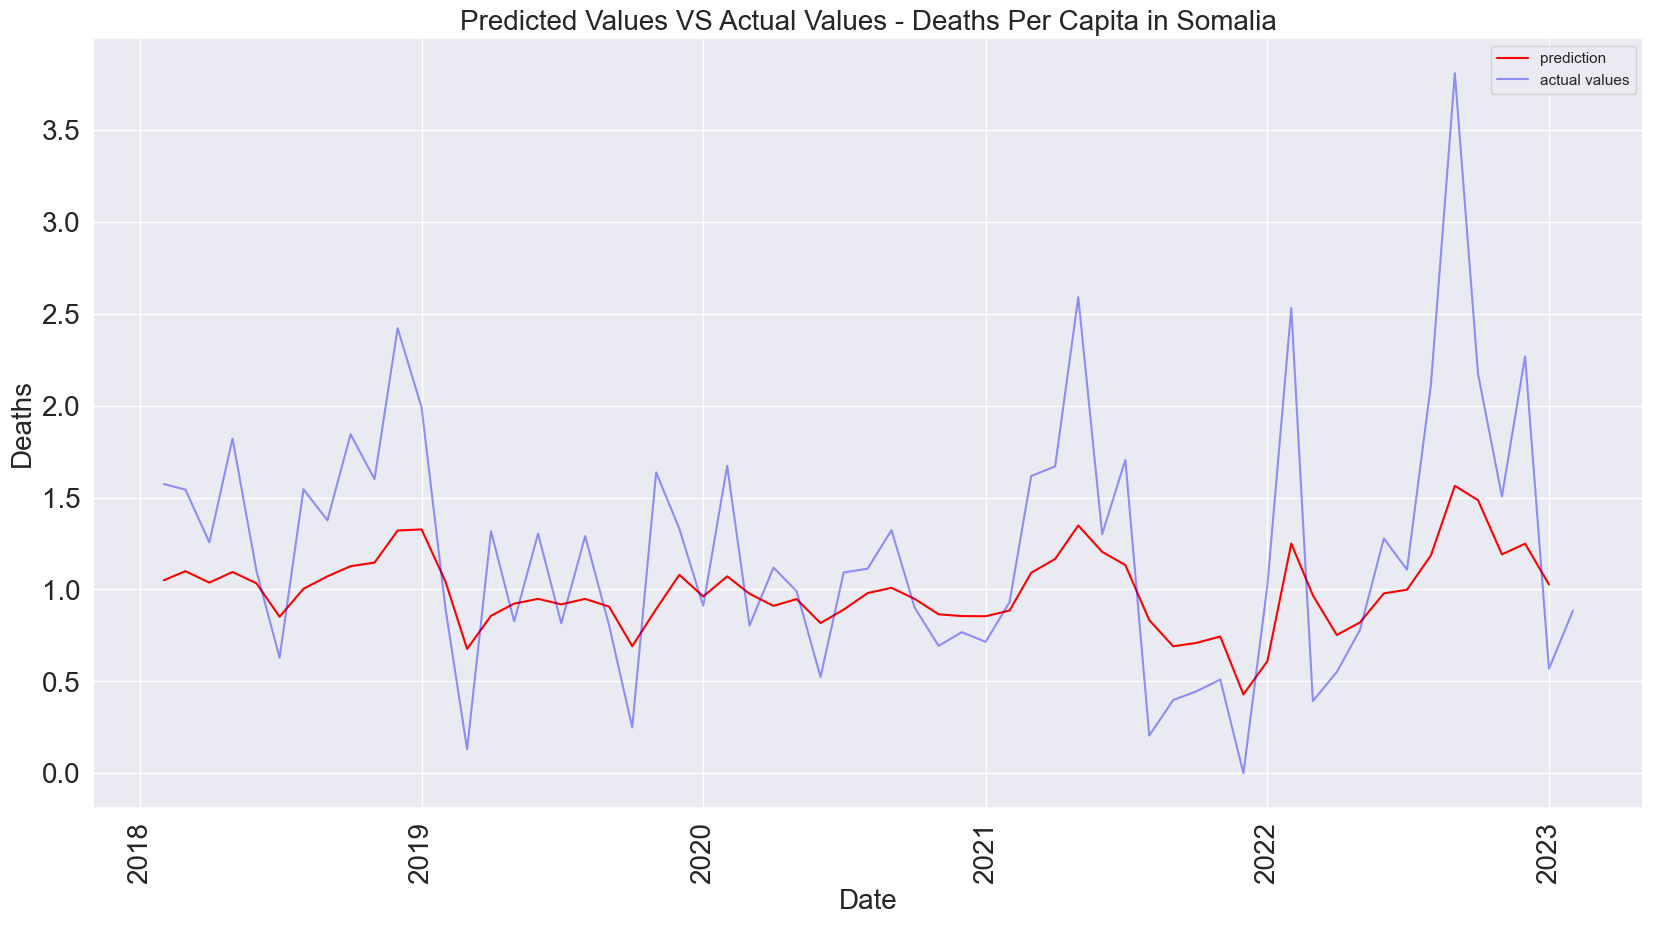

Iraq - Mean Absolute Error: 0.309387255070557, Mean Squared Error: 0.09884858936791224


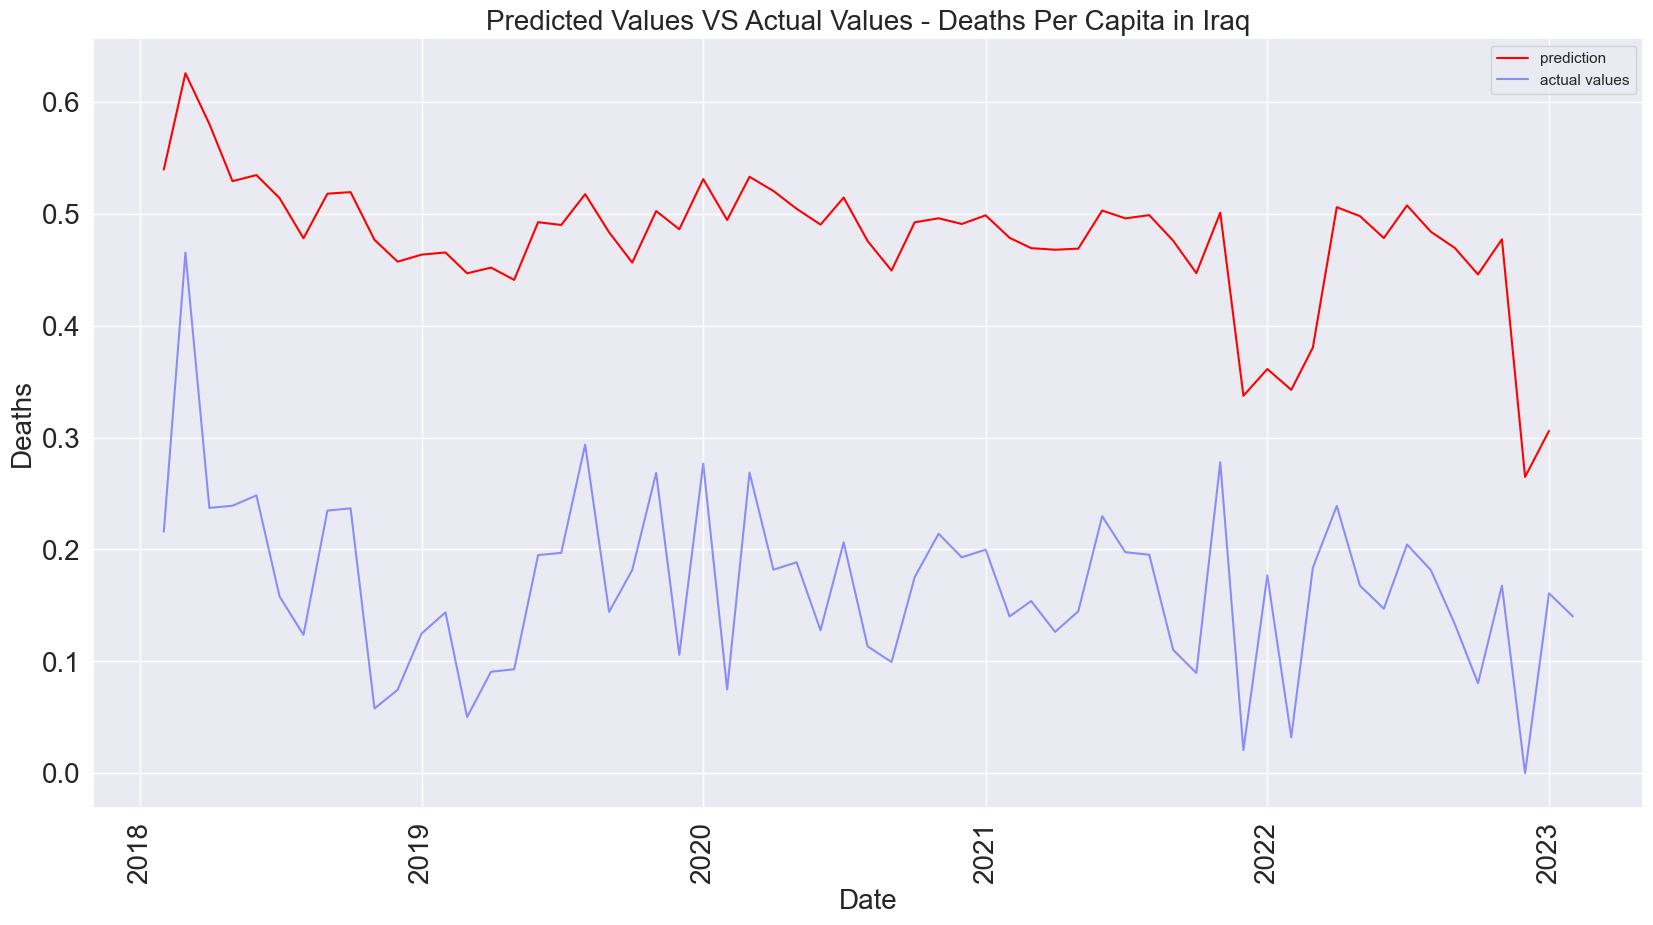

Libya - Mean Absolute Error: 0.5481755247887639, Mean Squared Error: 2.9185432585364315


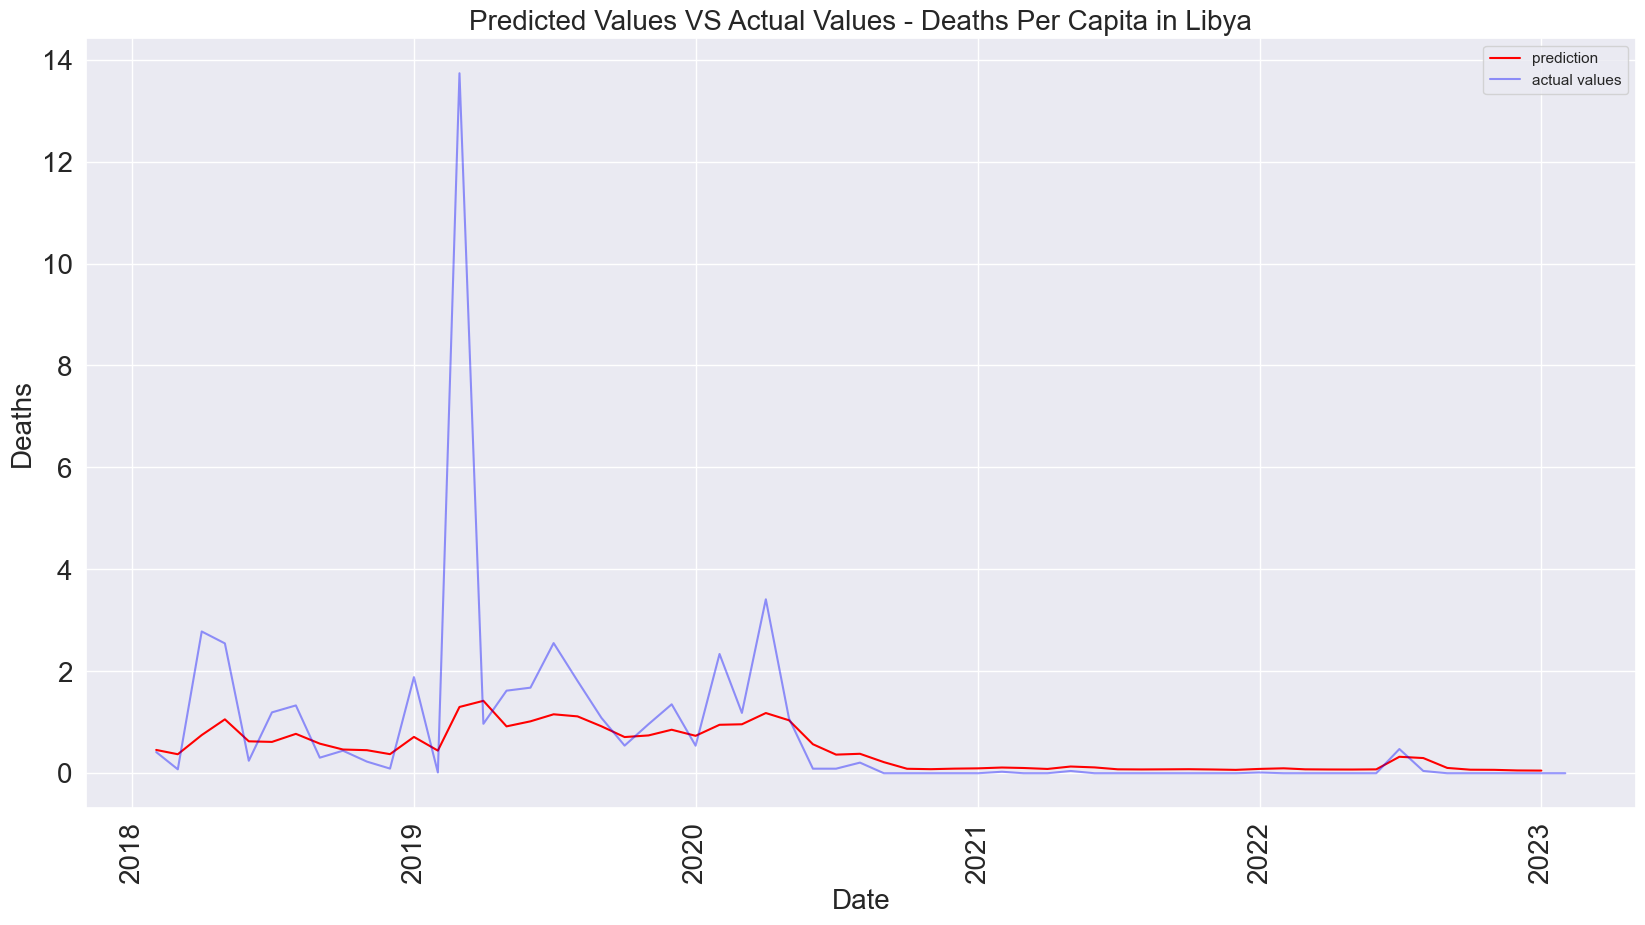

Liberia - Mean Absolute Error: 0.001001683110552924, Mean Squared Error: 1.919812762323479e-05


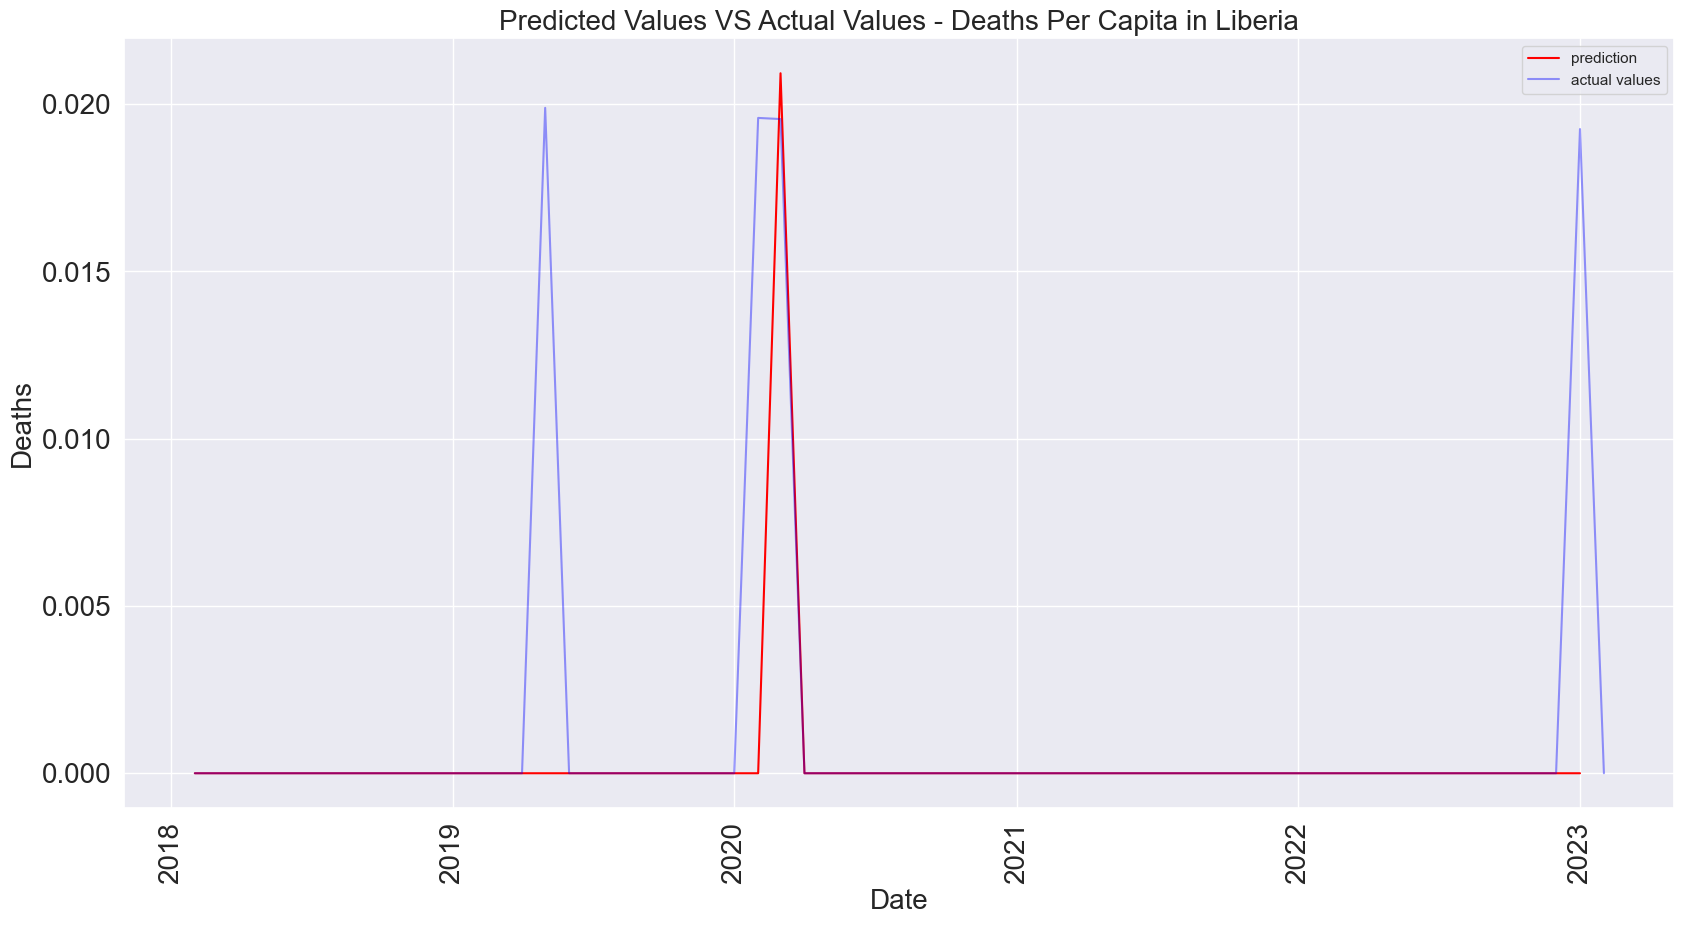

Yemen - Mean Absolute Error: 1.1055735380874547, Mean Squared Error: 13.0358997388353


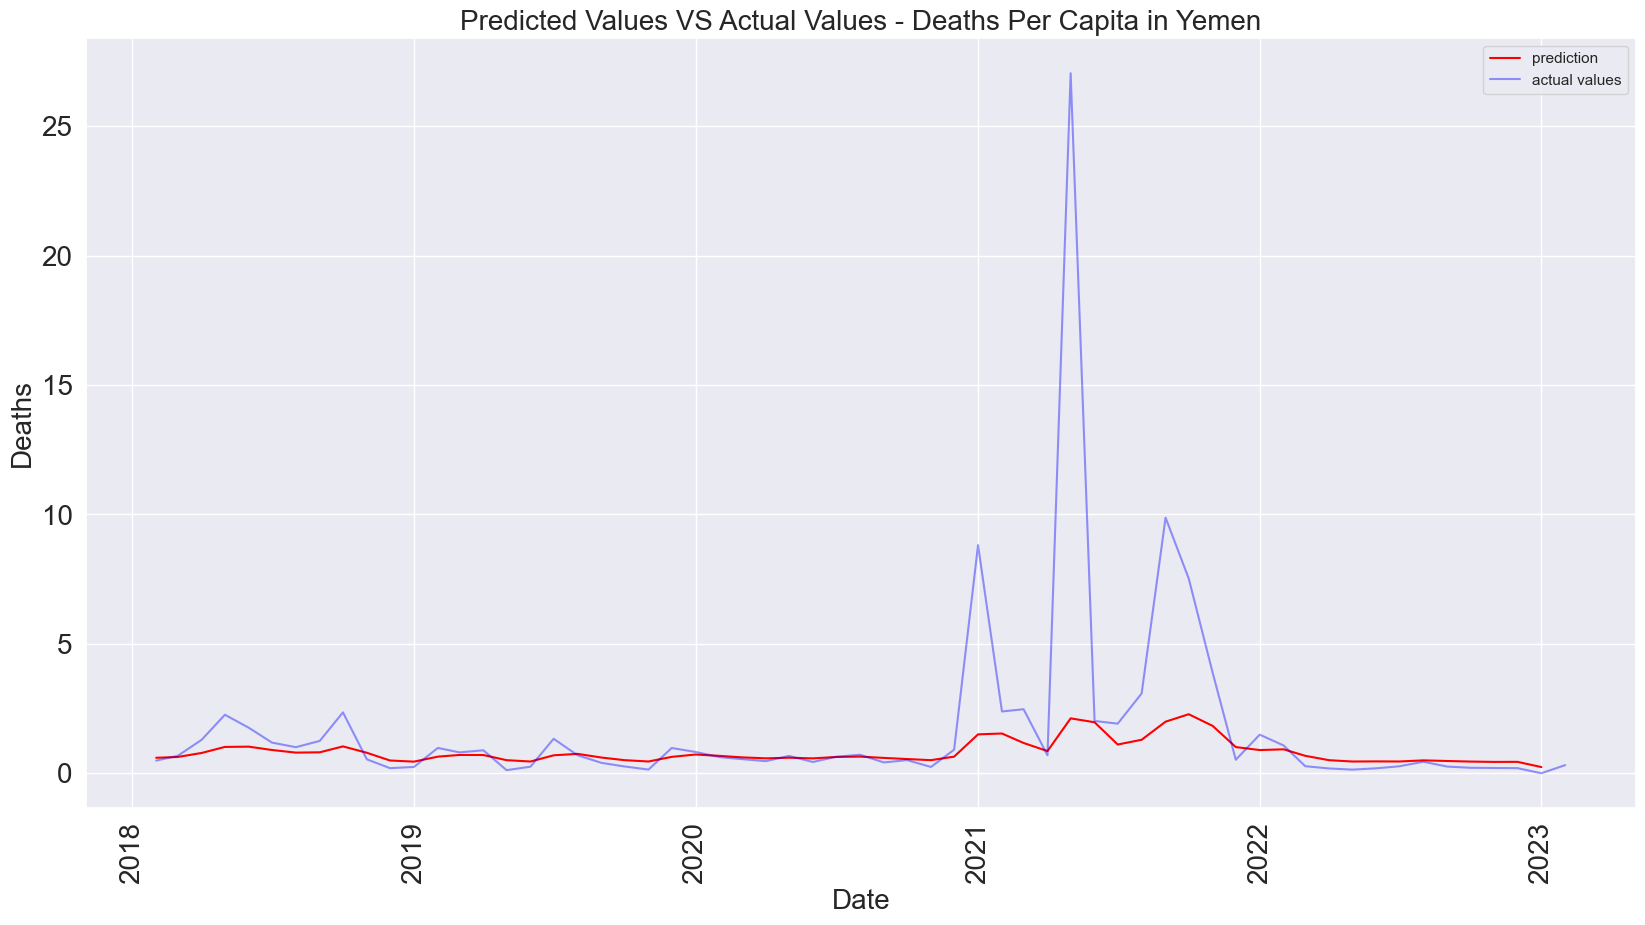

Sudan - Mean Absolute Error: 0.16992973917366797, Mean Squared Error: 0.03611738648418876


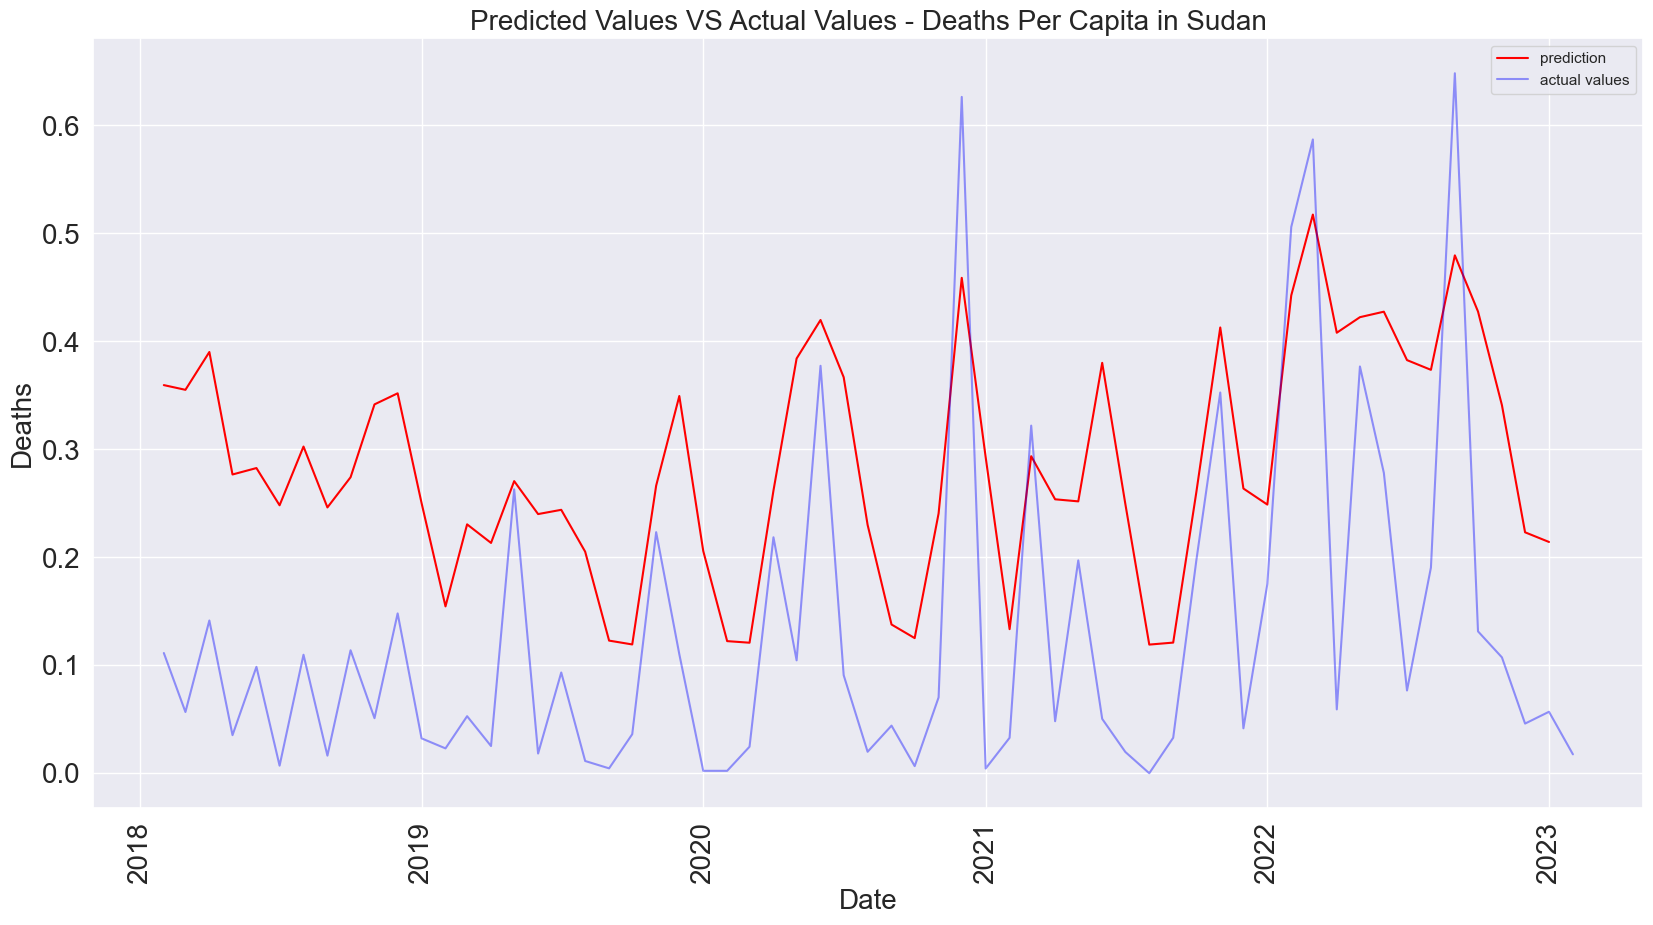

Ukraine - Mean Absolute Error: 1.9397101159632384, Mean Squared Error: 72.50514111948108


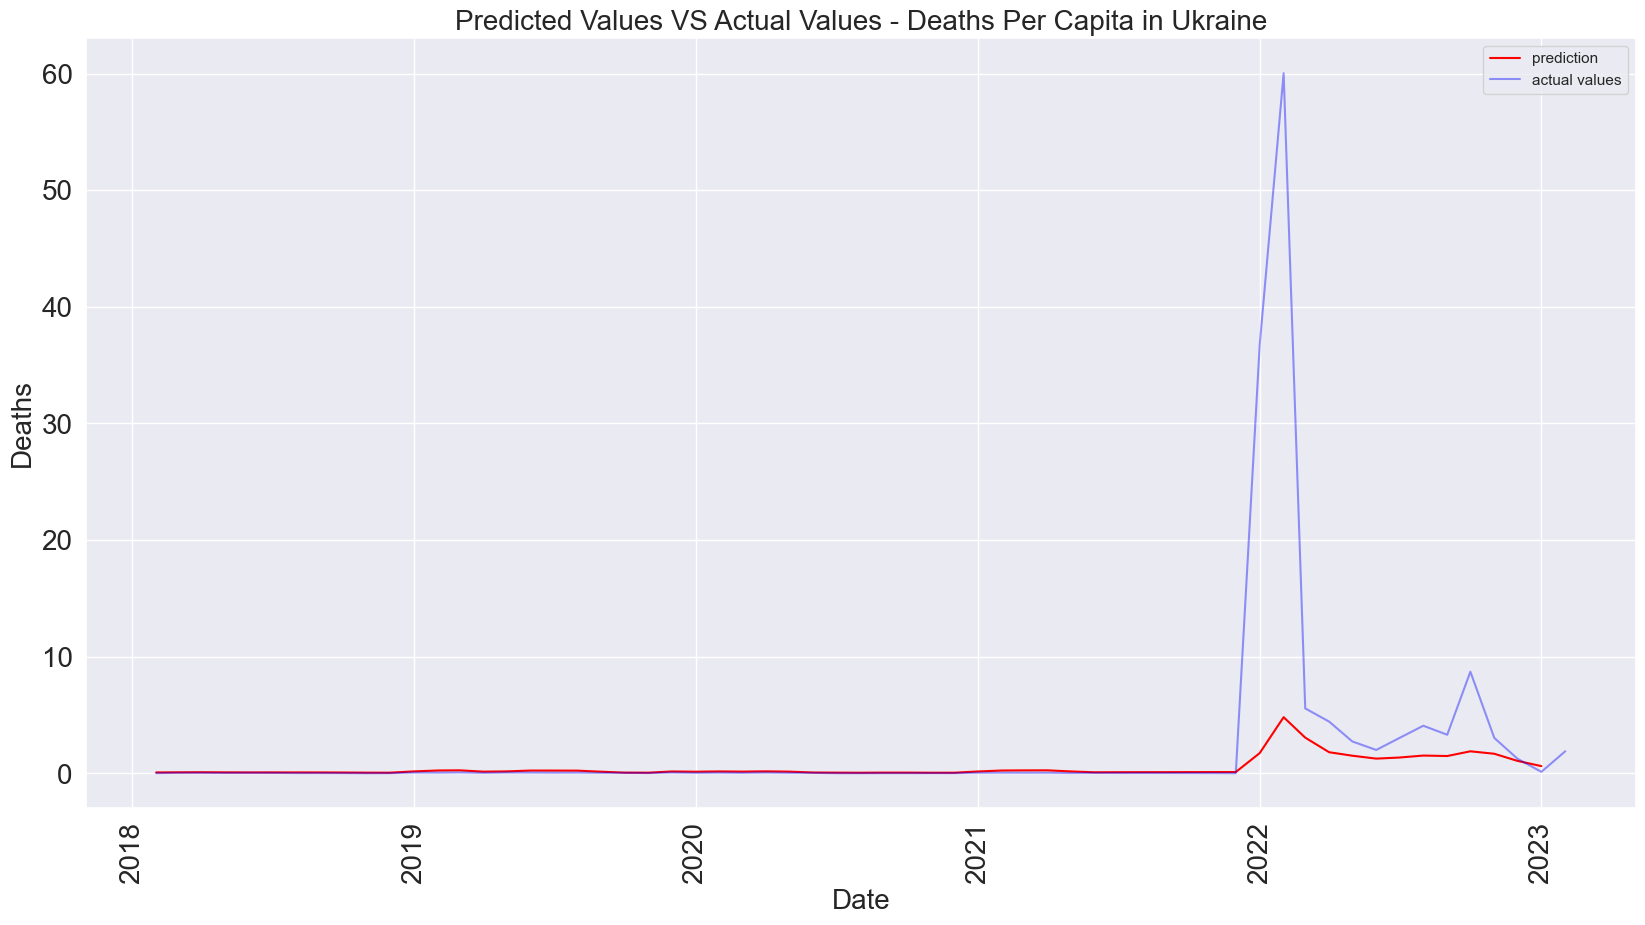

Sri Lanka - Mean Absolute Error: 0.03534056214001192, Mean Squared Error: 0.01319801631100115


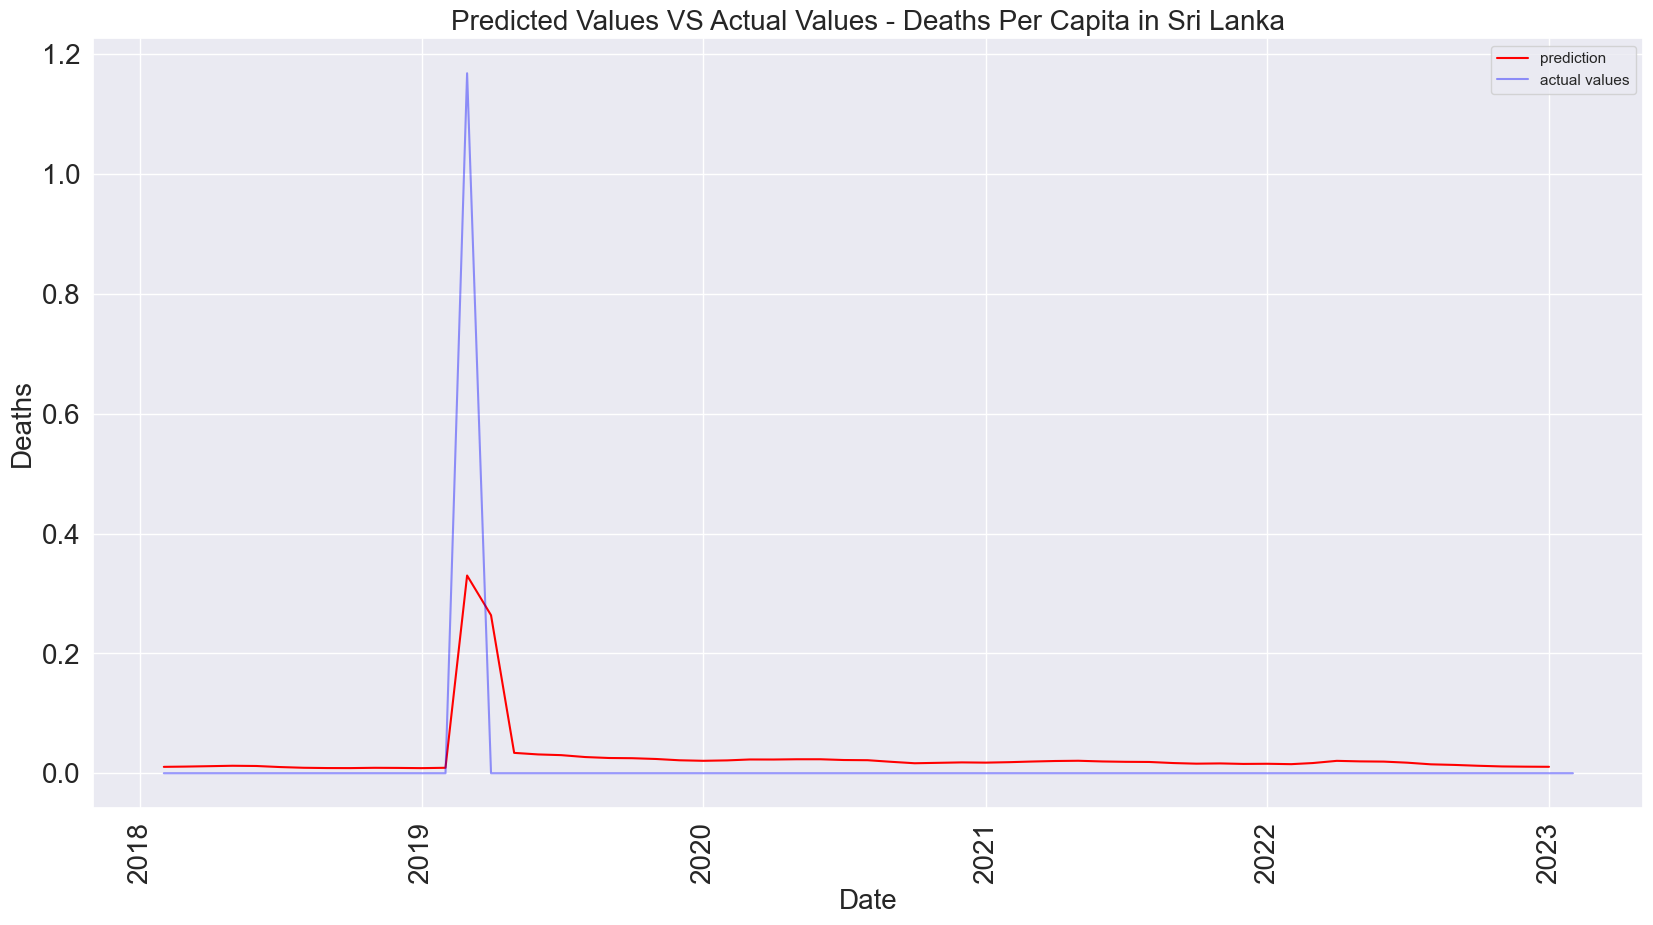

In [53]:
plot_country_data(('deaths_all_pc', 'combined_vars'), top_10_country_names, -1)


Syrian Arab Republic - Mean Absolute Error: 1.9686707280909452, Mean Squared Error: 4.878941641708501


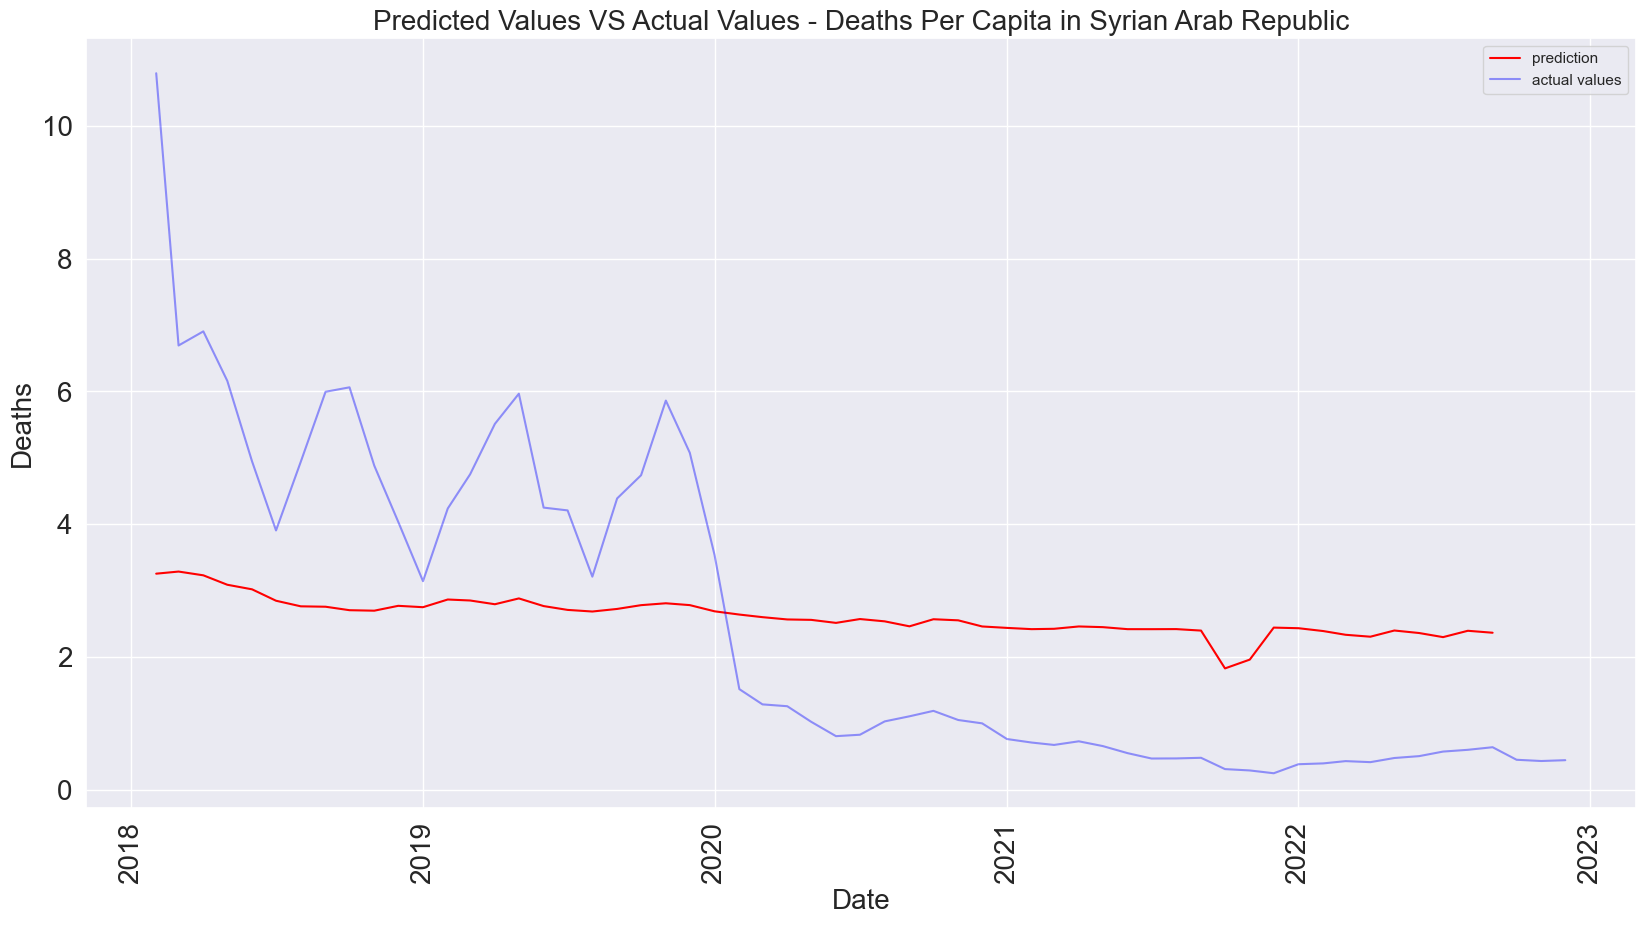

Afghanistan - Mean Absolute Error: 4.191404378288639, Mean Squared Error: 29.132617924531466


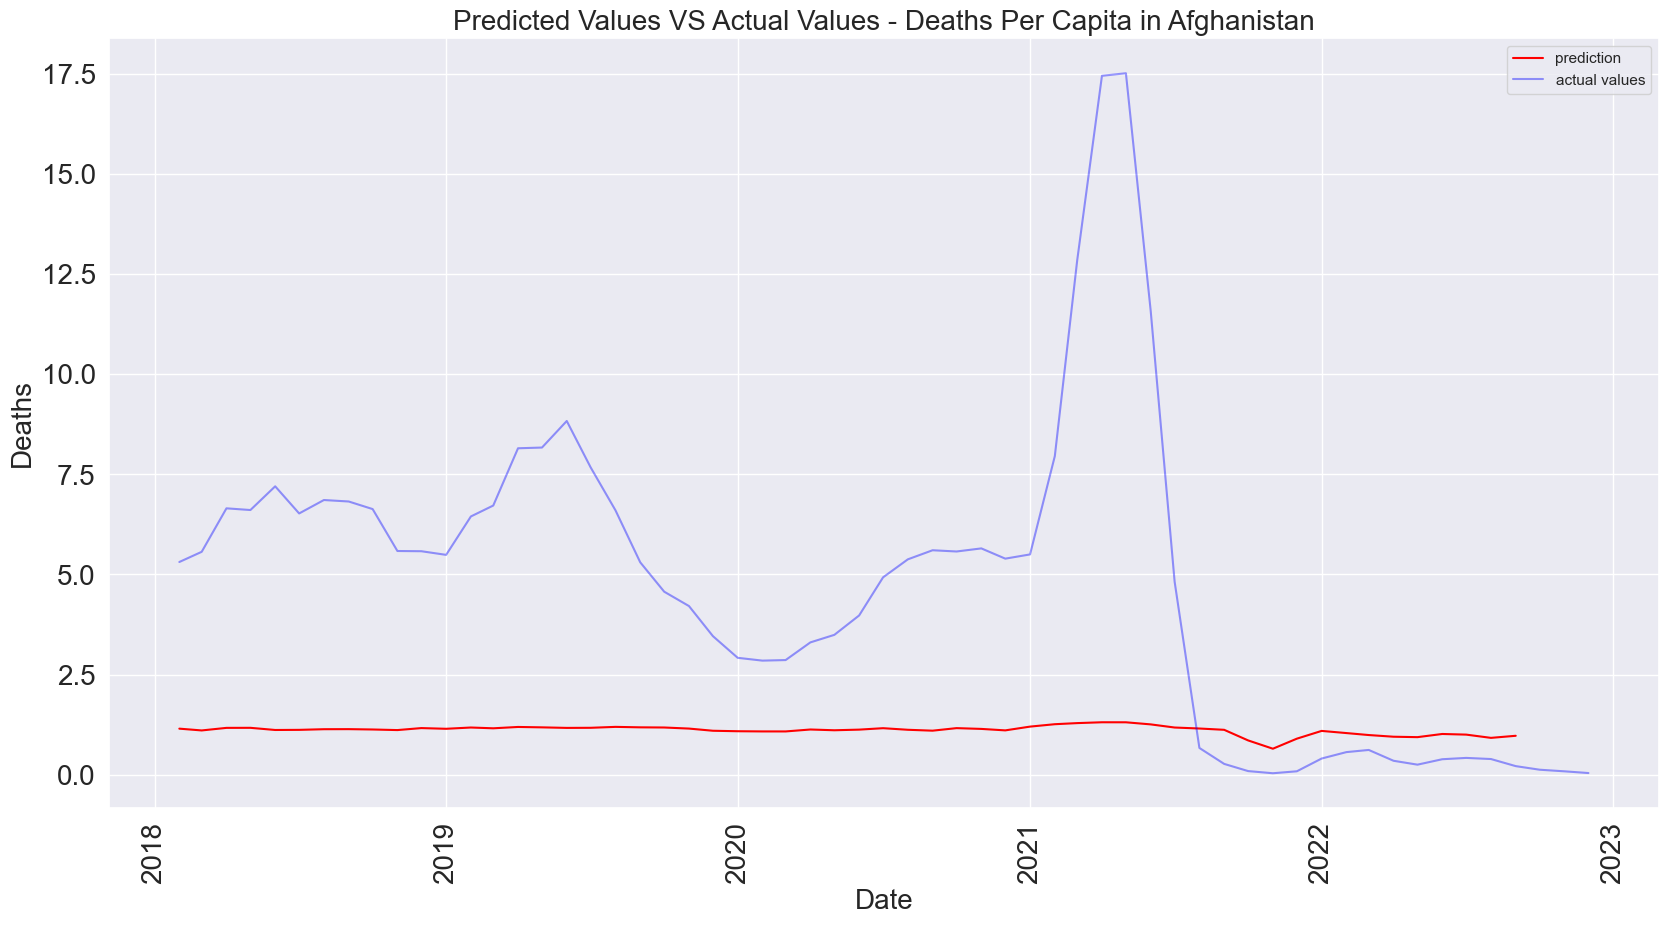

Central African Republic - Mean Absolute Error: 0.4770559430409553, Mean Squared Error: 0.4793020047328177


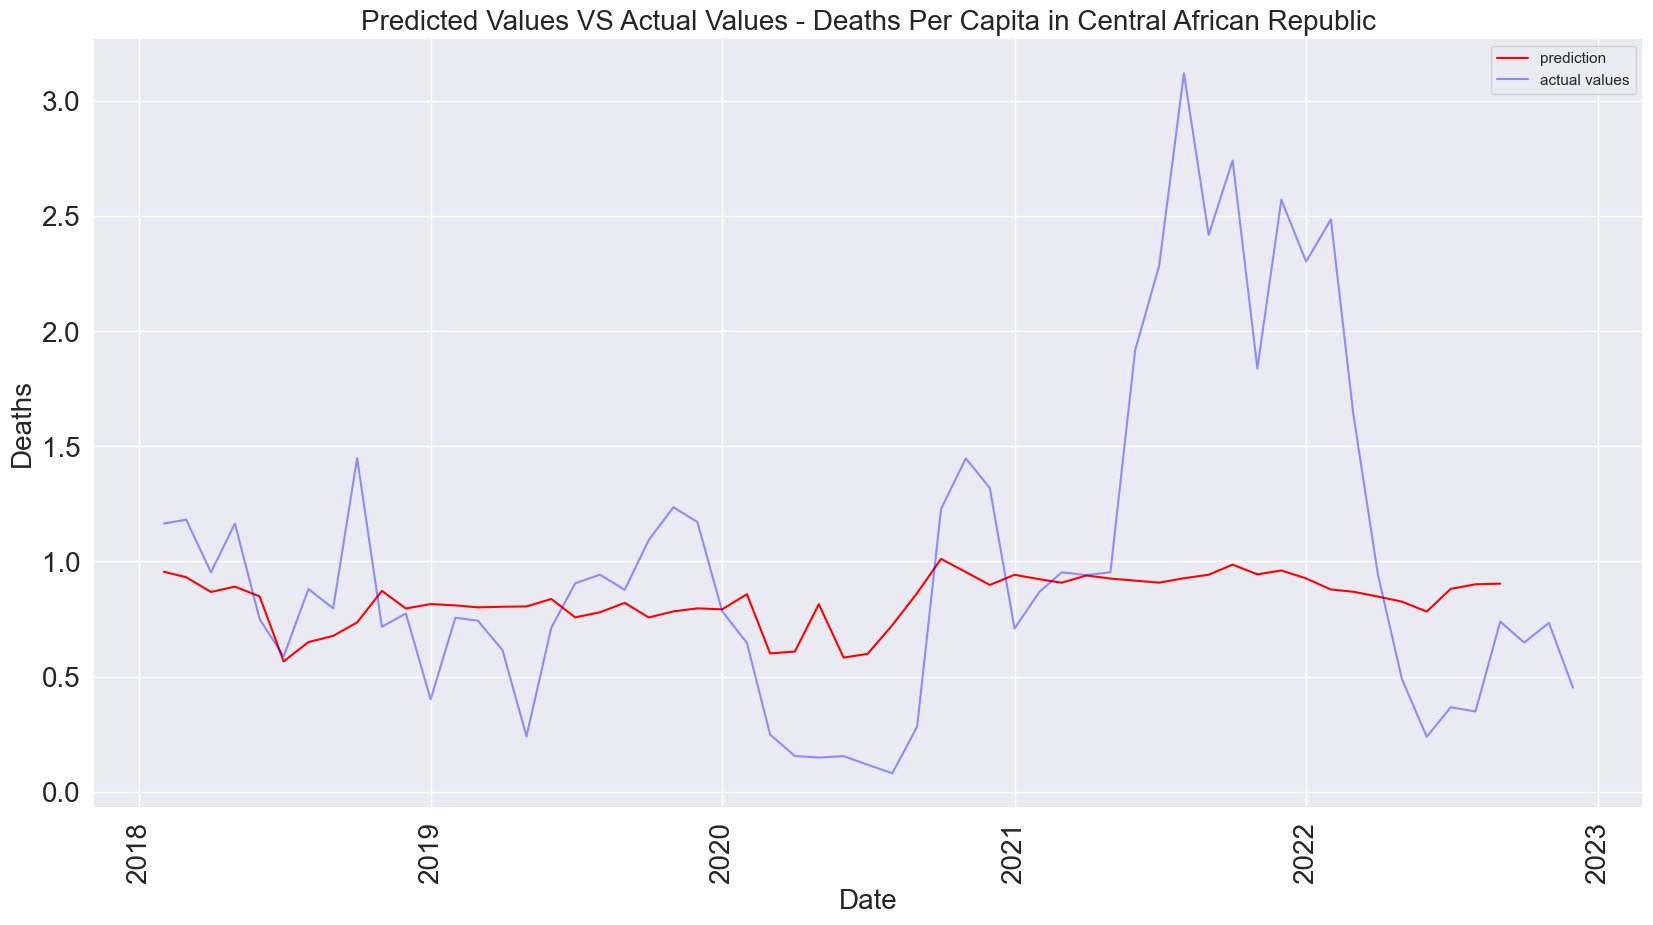

Somalia - Mean Absolute Error: 0.41380574509568696, Mean Squared Error: 0.32899746430269083


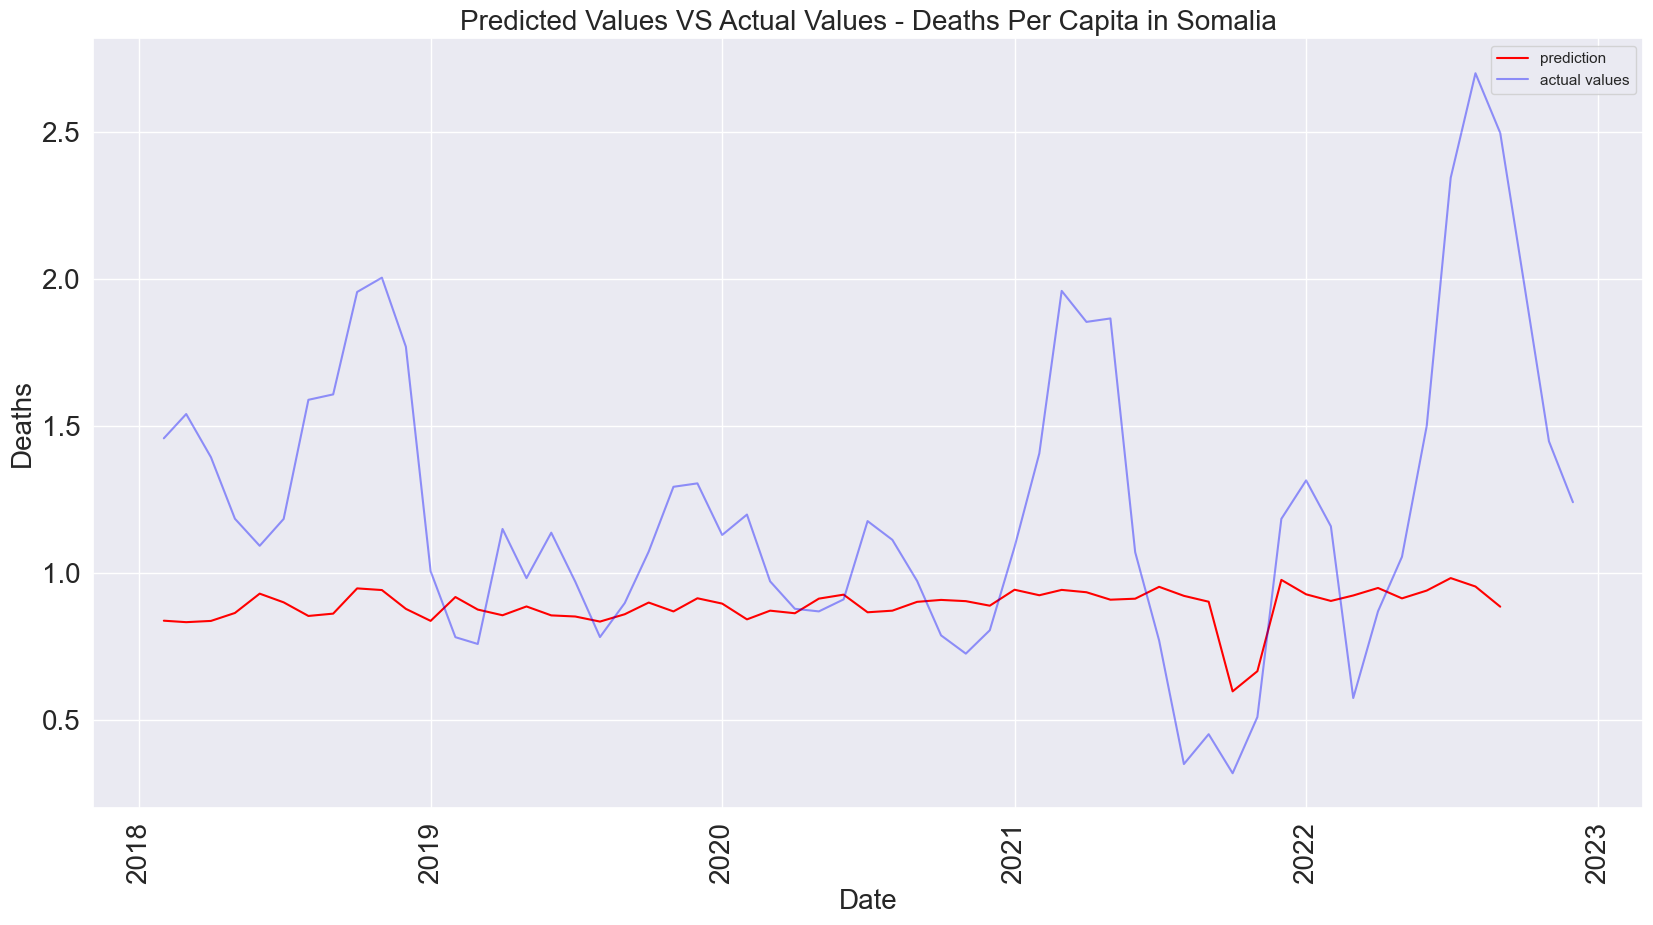

Iraq - Mean Absolute Error: 0.5458591653259149, Mean Squared Error: 0.30172590424664253


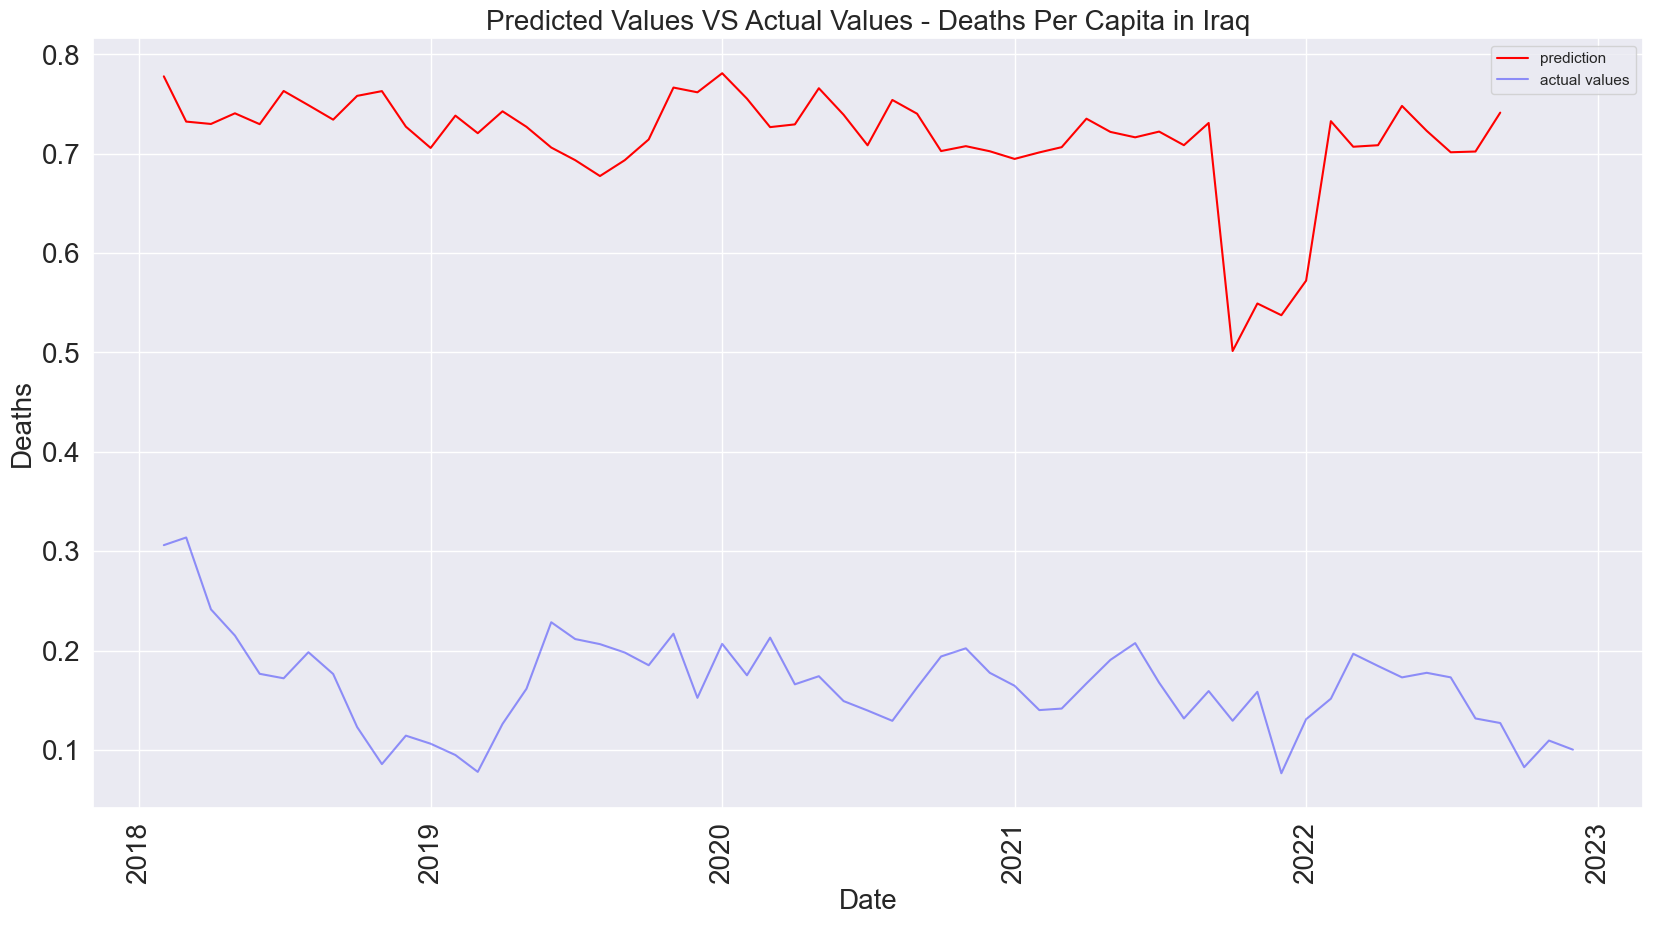

Libya - Mean Absolute Error: 0.6090464182645626, Mean Squared Error: 1.37650061691208


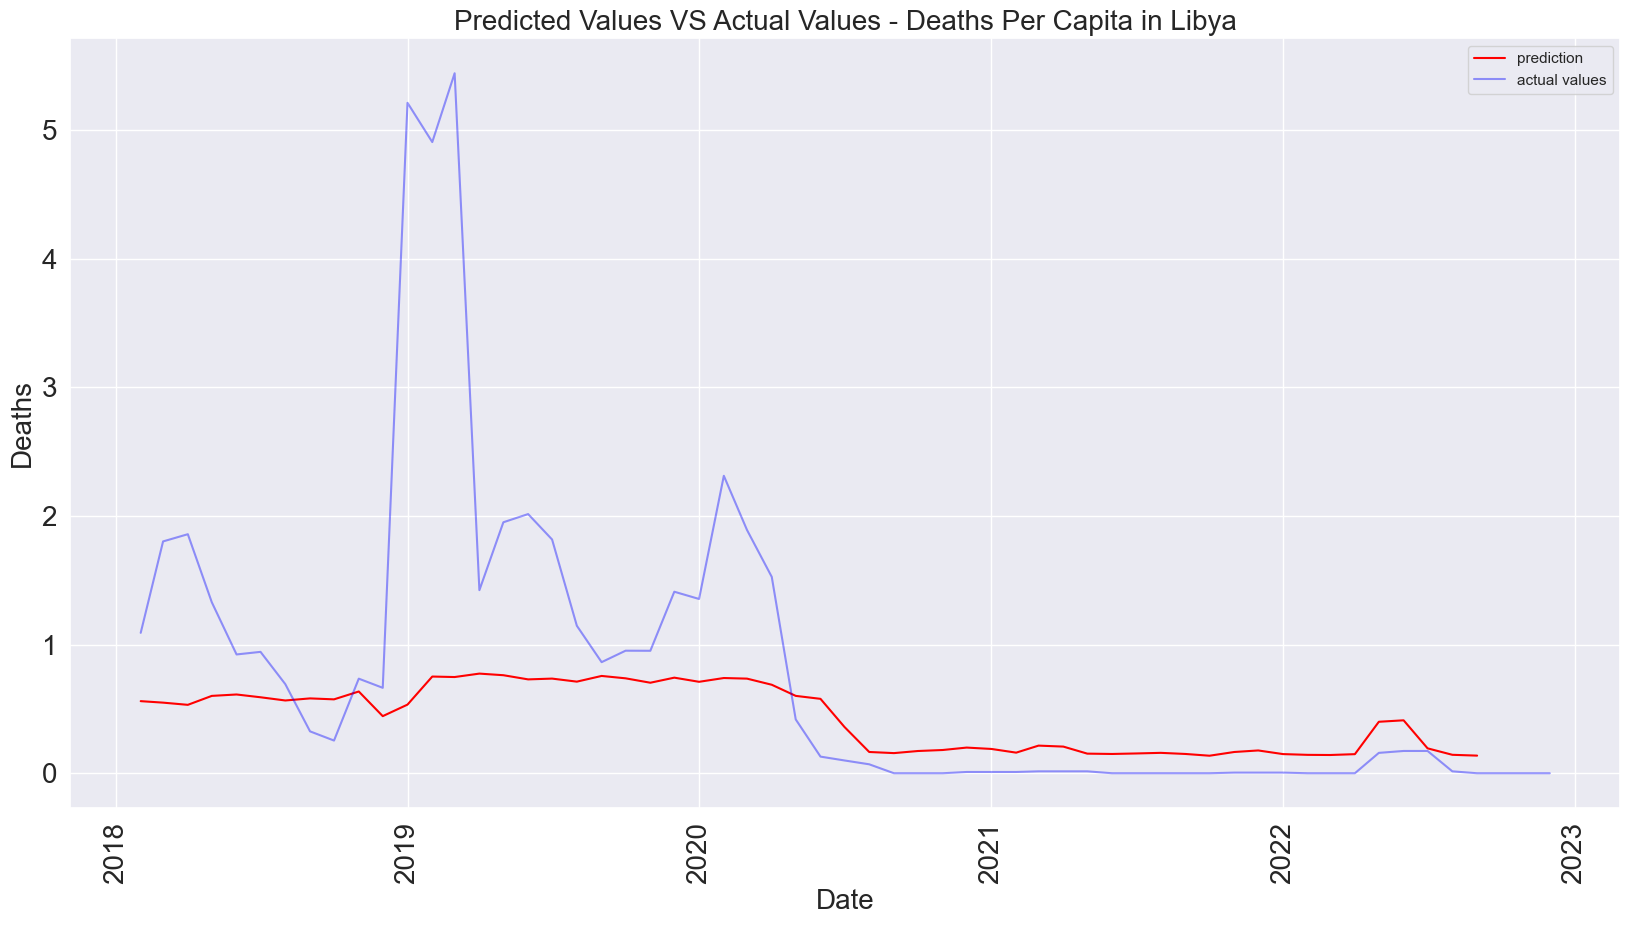

Liberia - Mean Absolute Error: 0.001959416688022768, Mean Squared Error: 4.272900724434599e-05


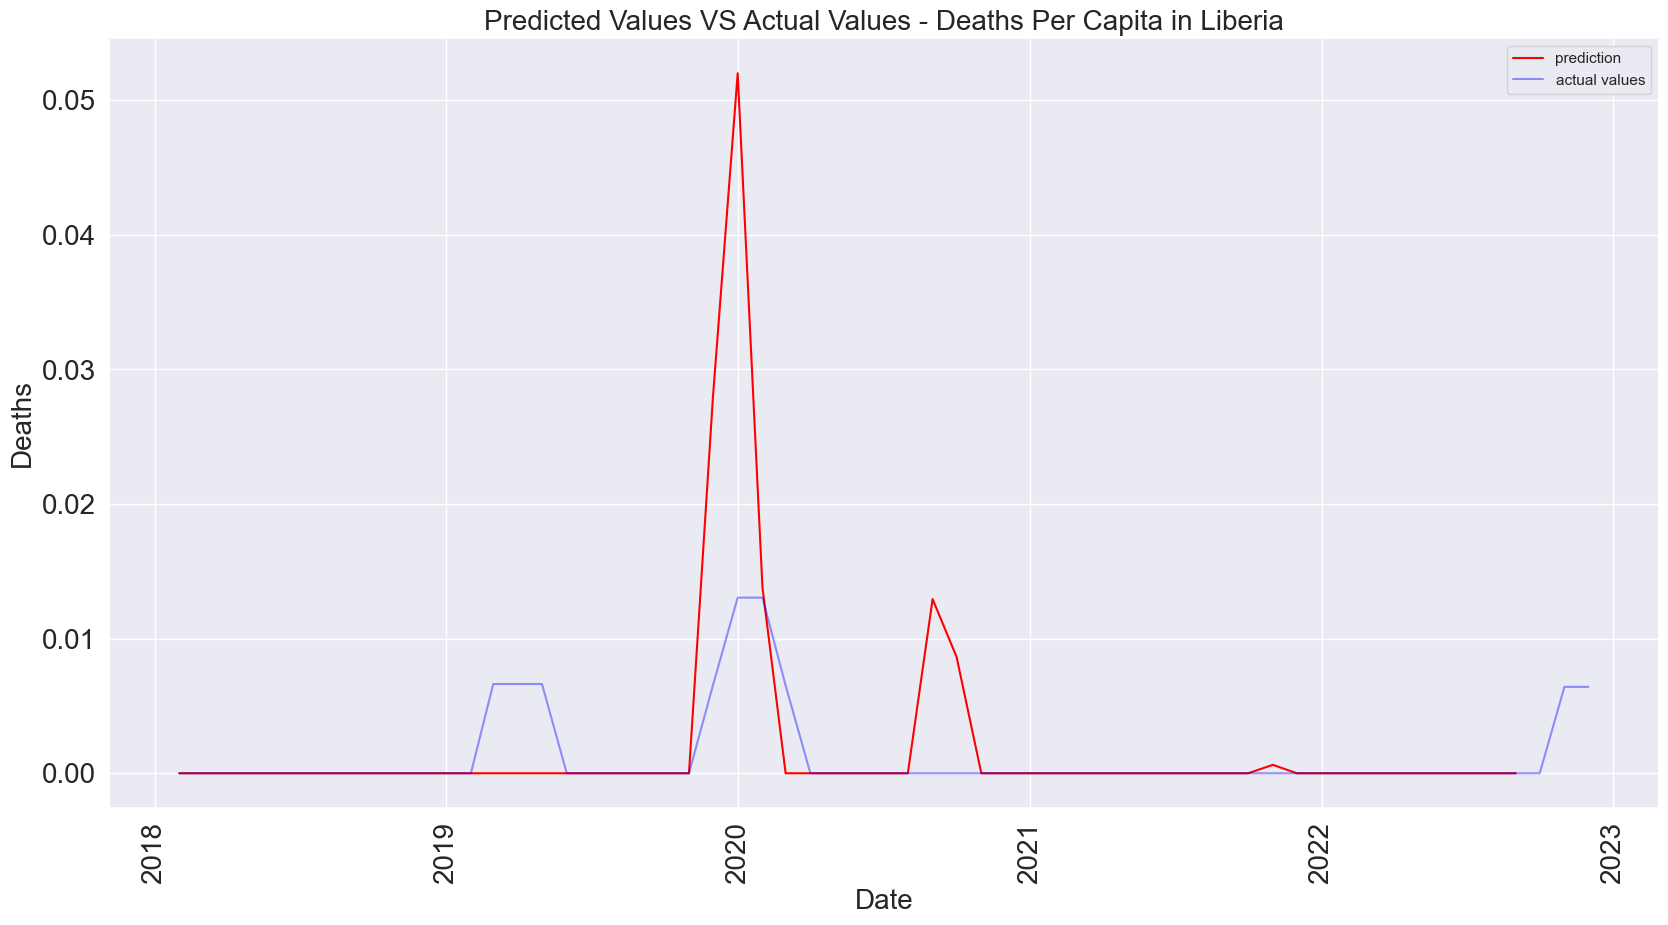

Yemen - Mean Absolute Error: 1.3245157610627776, Mean Squared Error: 7.352341281169951


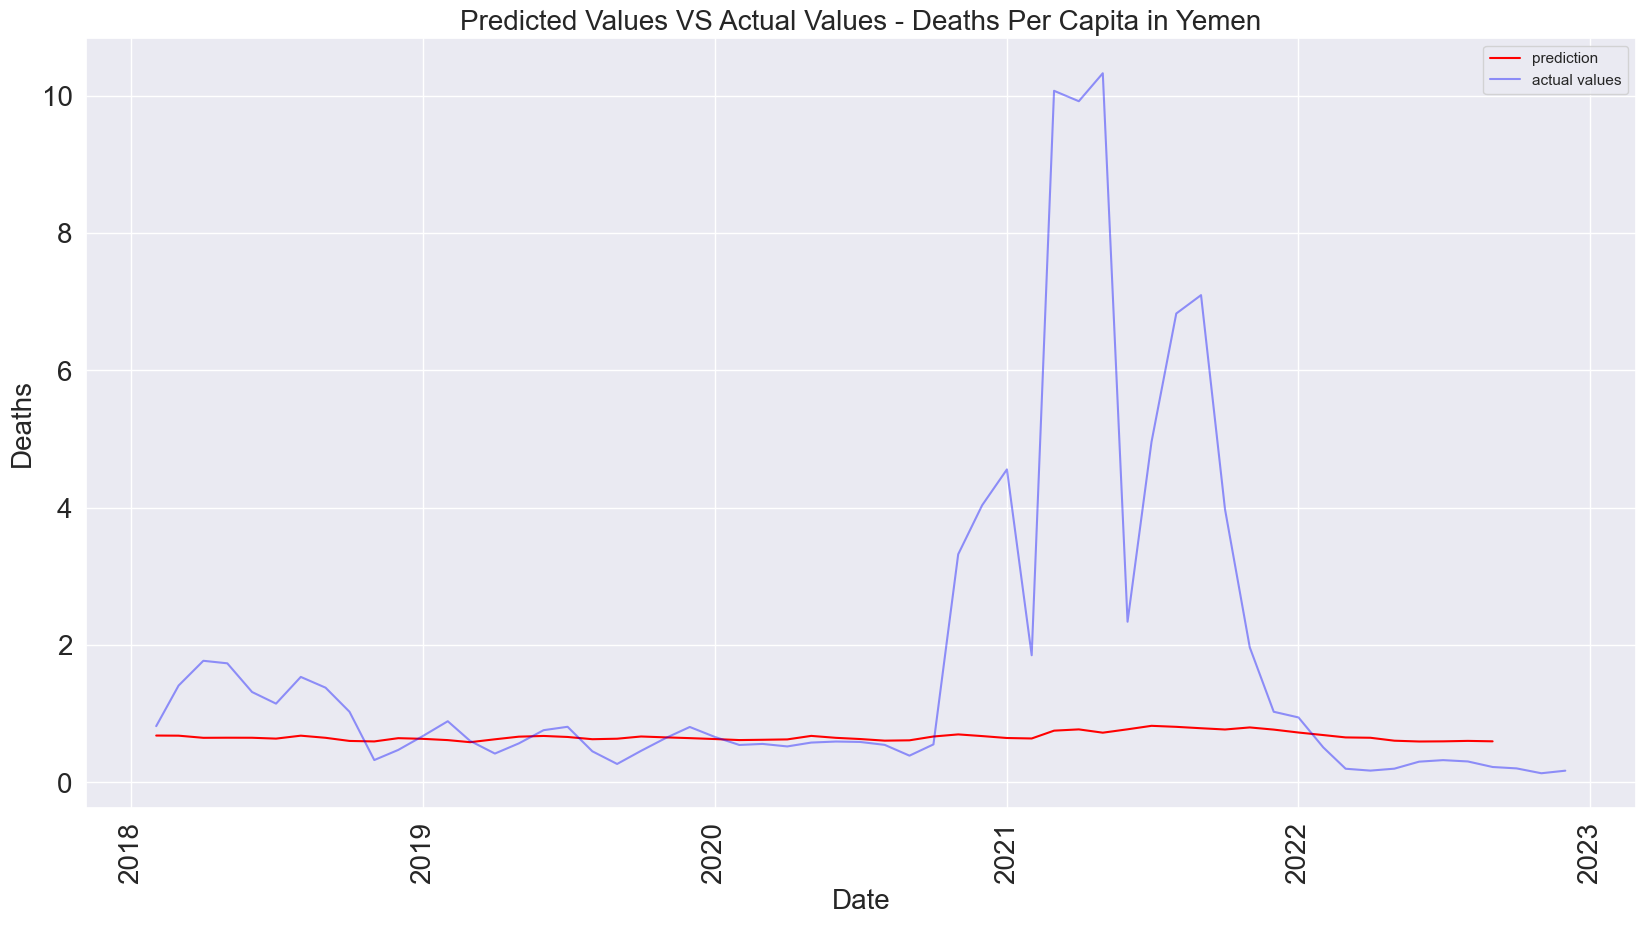

Sudan - Mean Absolute Error: 0.2833691131504941, Mean Squared Error: 0.09129657700793745


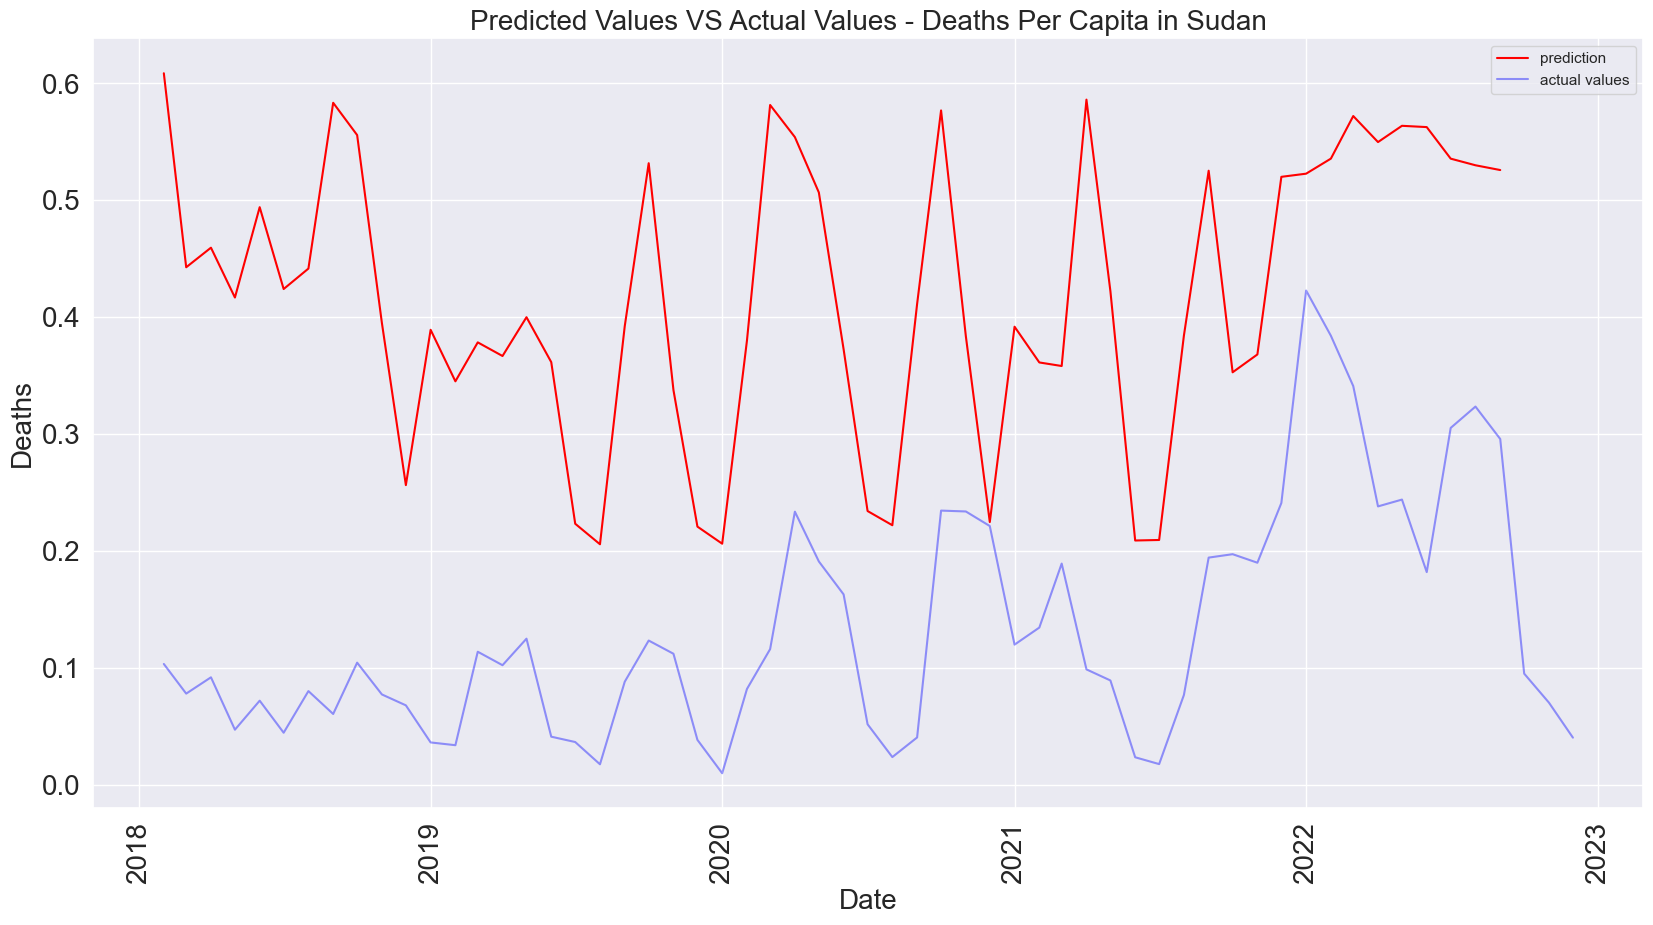

Ukraine - Mean Absolute Error: 2.2763483662495028, Mean Squared Error: 49.940963588571215


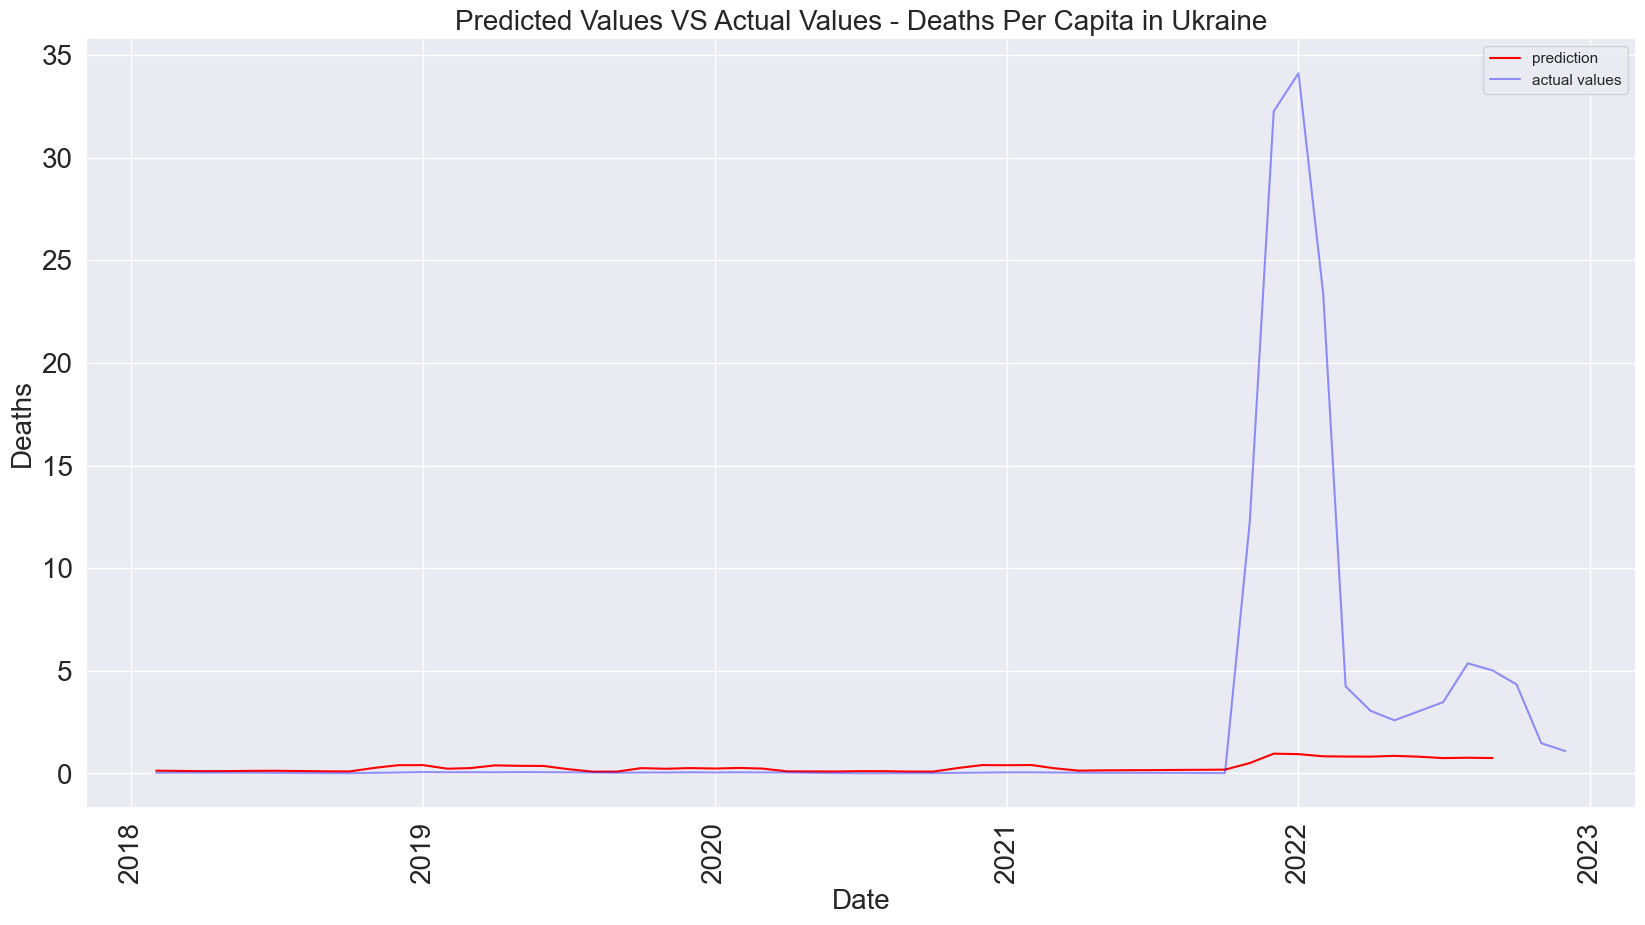

Sri Lanka - Mean Absolute Error: 0.05009065783323362, Mean Squared Error: 0.00441595548783276


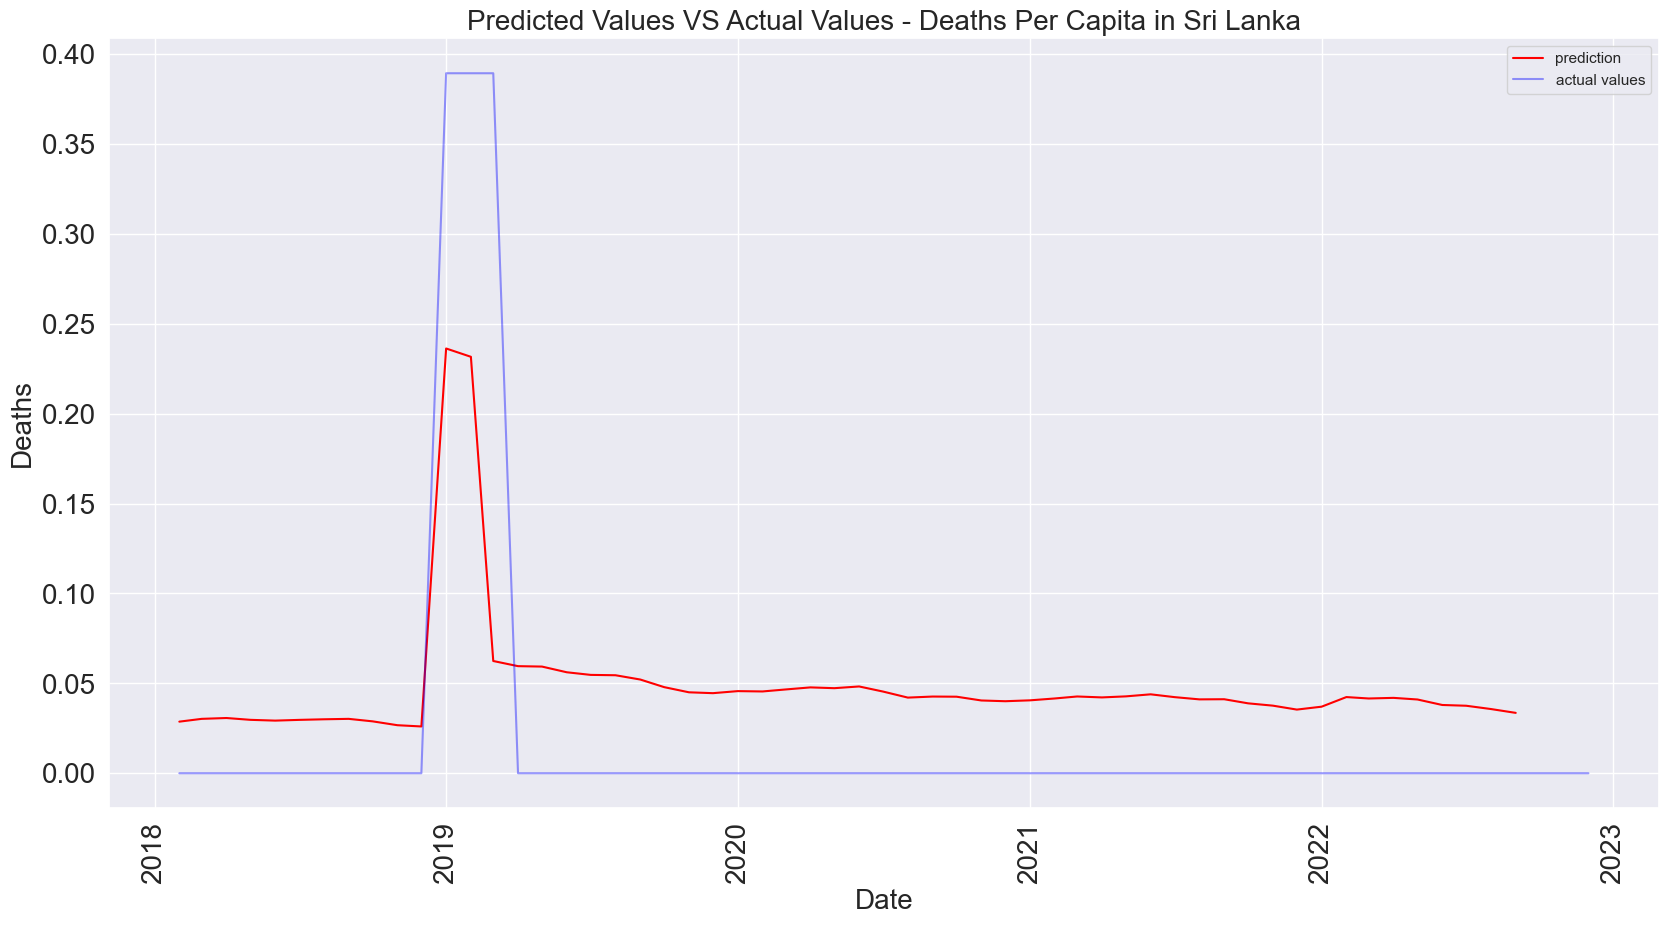

In [54]:
plot_country_data(('f3_target_regr', 'combined_vars'), top_10_country_names, -3)

Syrian Arab Republic - Mean Absolute Error: 1.959715217753874, Mean Squared Error: 4.783762279806759


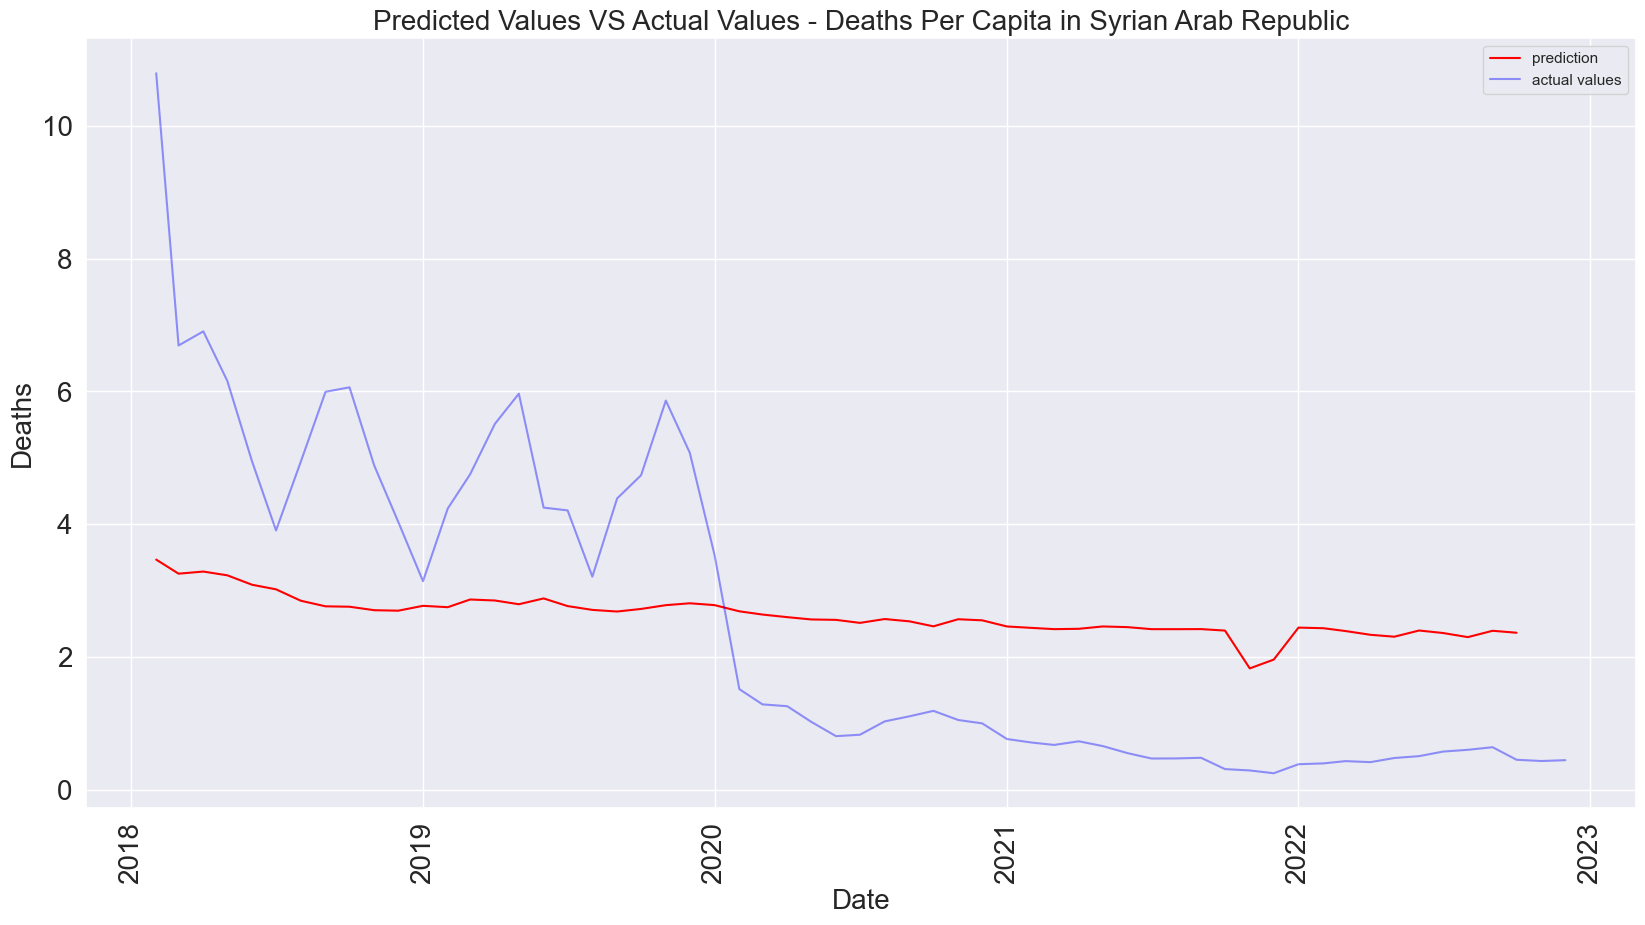

Afghanistan - Mean Absolute Error: 4.137727006716683, Mean Squared Error: 28.669012442824595


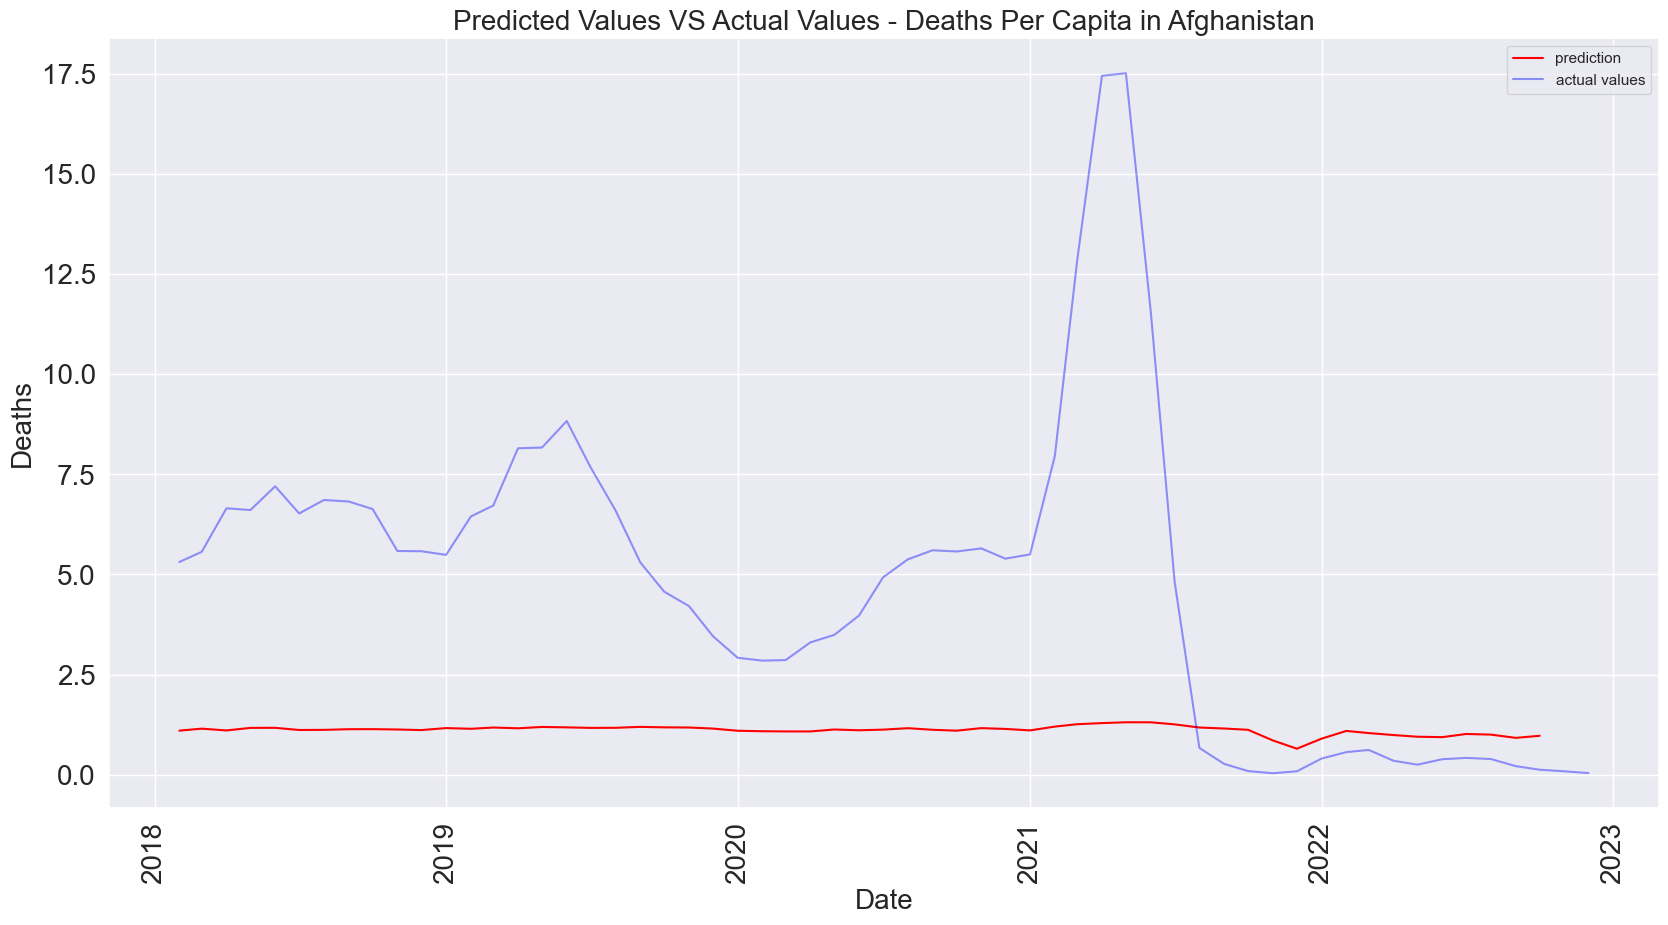

Central African Republic - Mean Absolute Error: 0.47488071974740803, Mean Squared Error: 0.47210672606801496


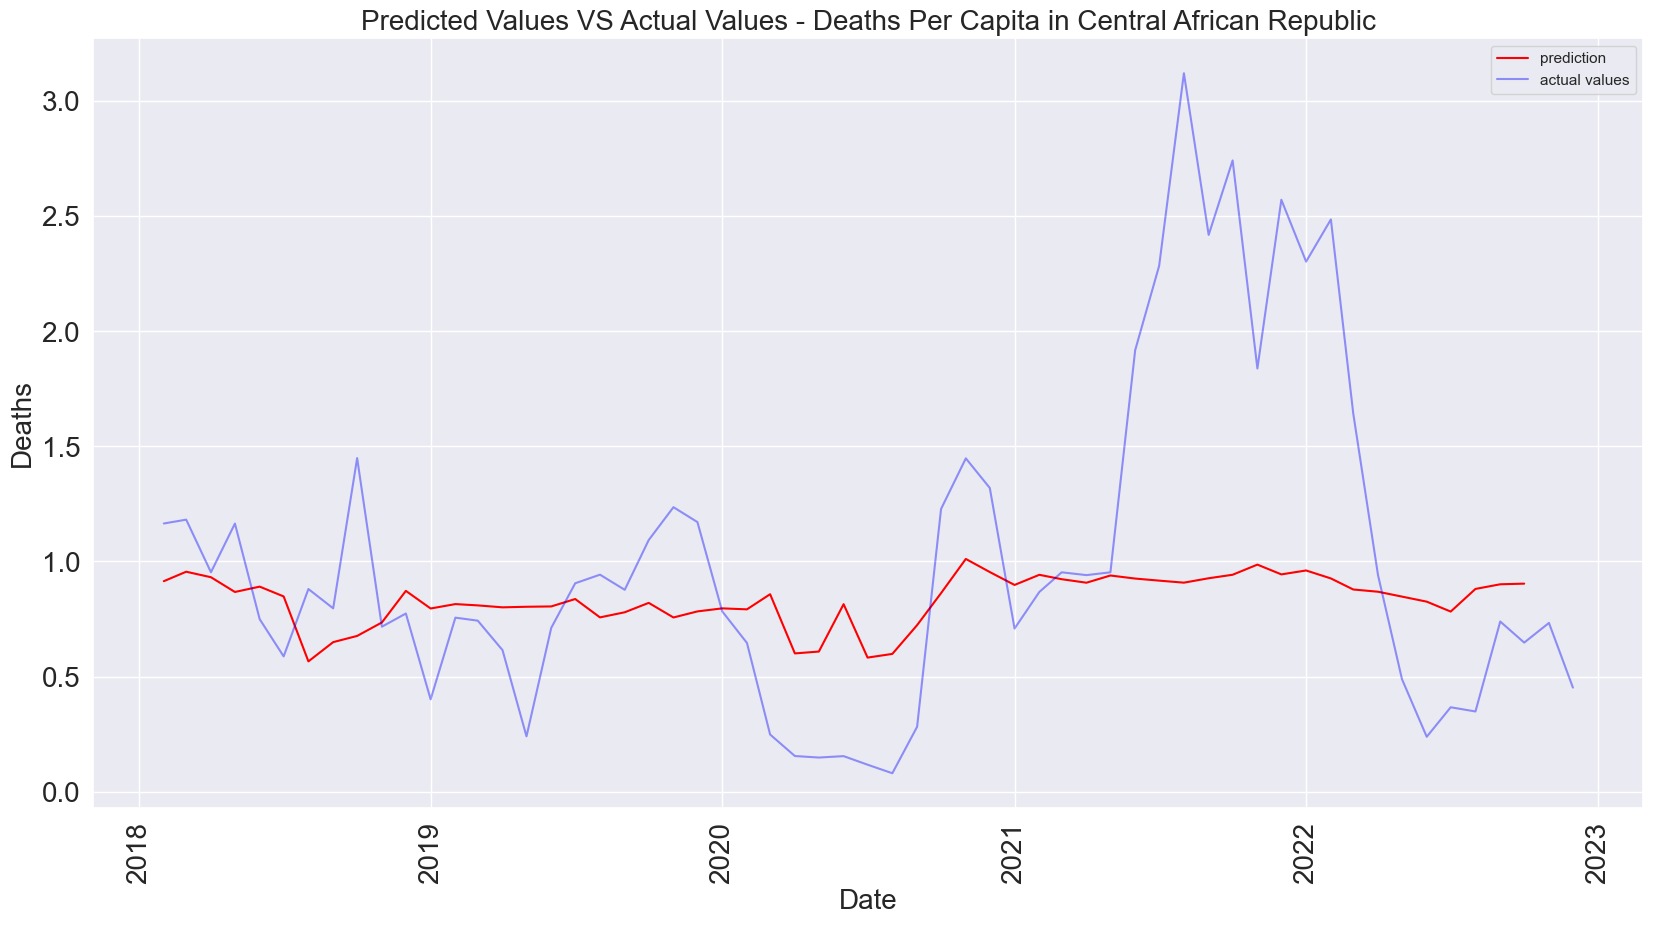

Somalia - Mean Absolute Error: 0.43090615112698777, Mean Squared Error: 0.34744402797573976


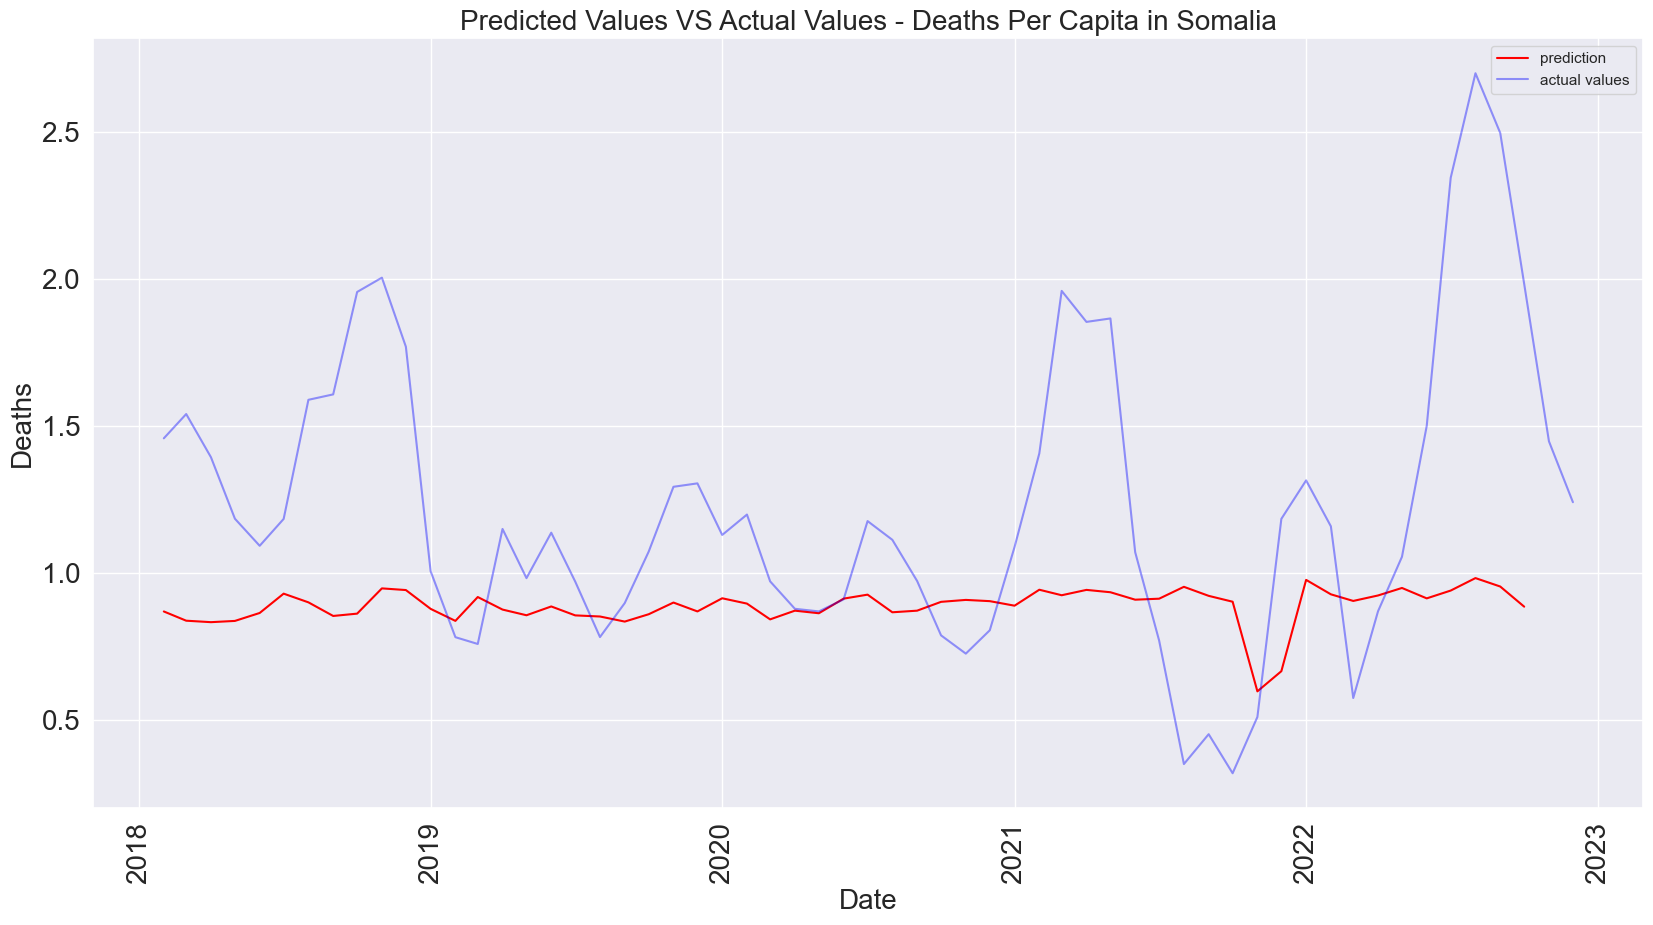

Iraq - Mean Absolute Error: 0.5489022731502328, Mean Squared Error: 0.30504335861641807


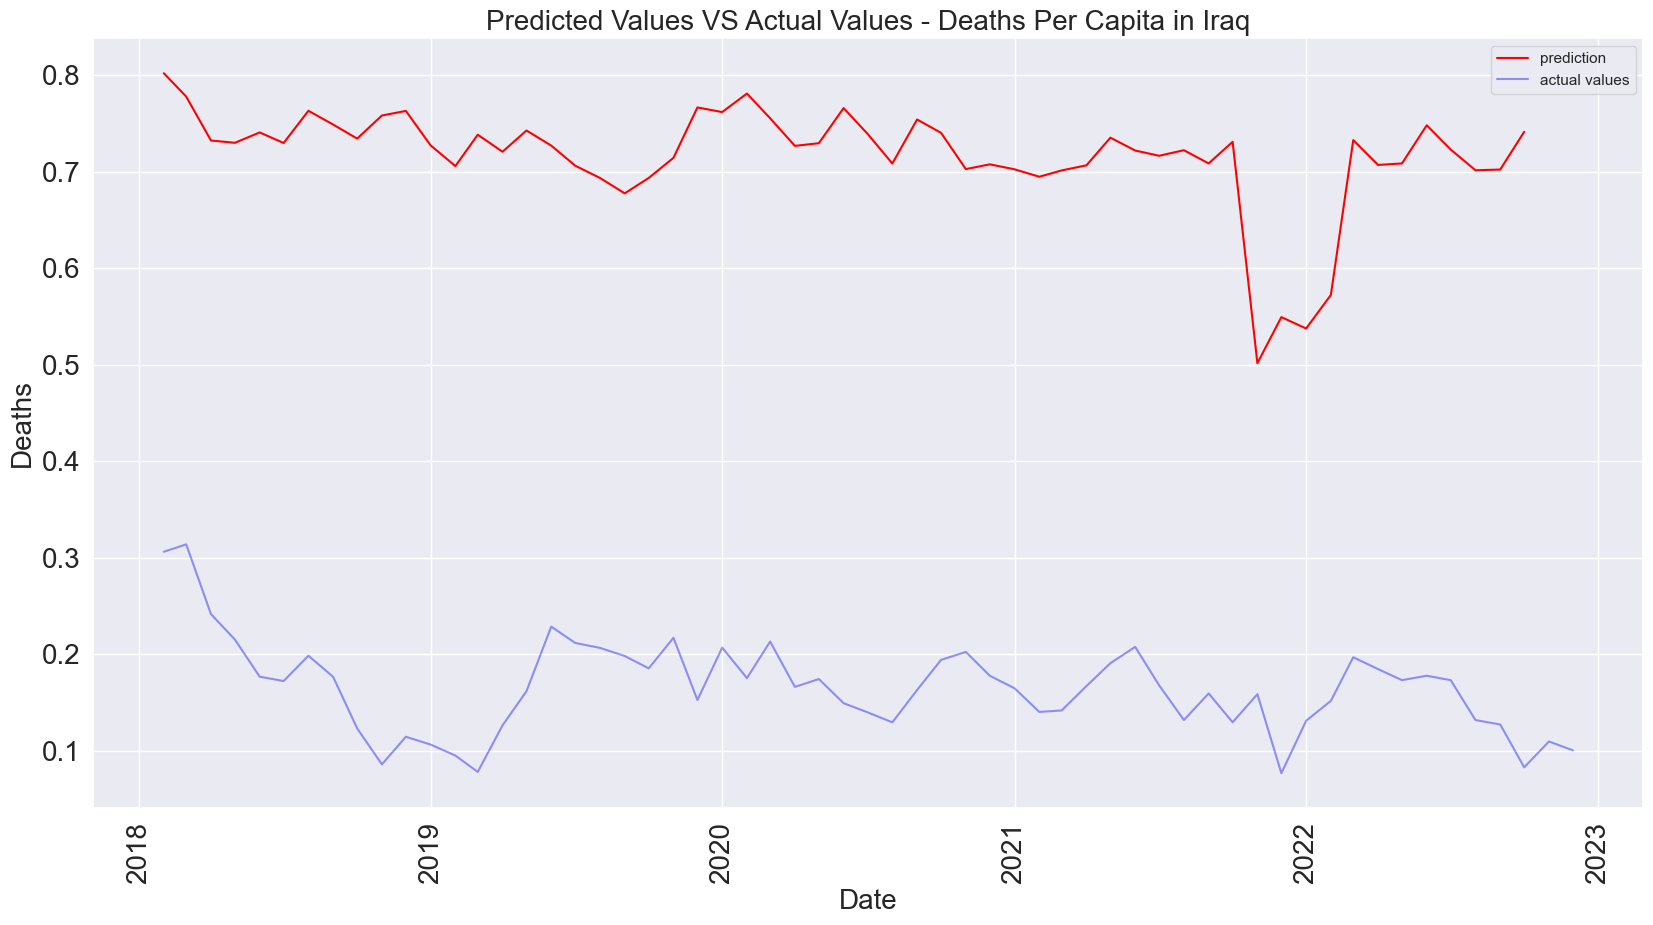

Libya - Mean Absolute Error: 0.6133756466742323, Mean Squared Error: 1.4041074308632577


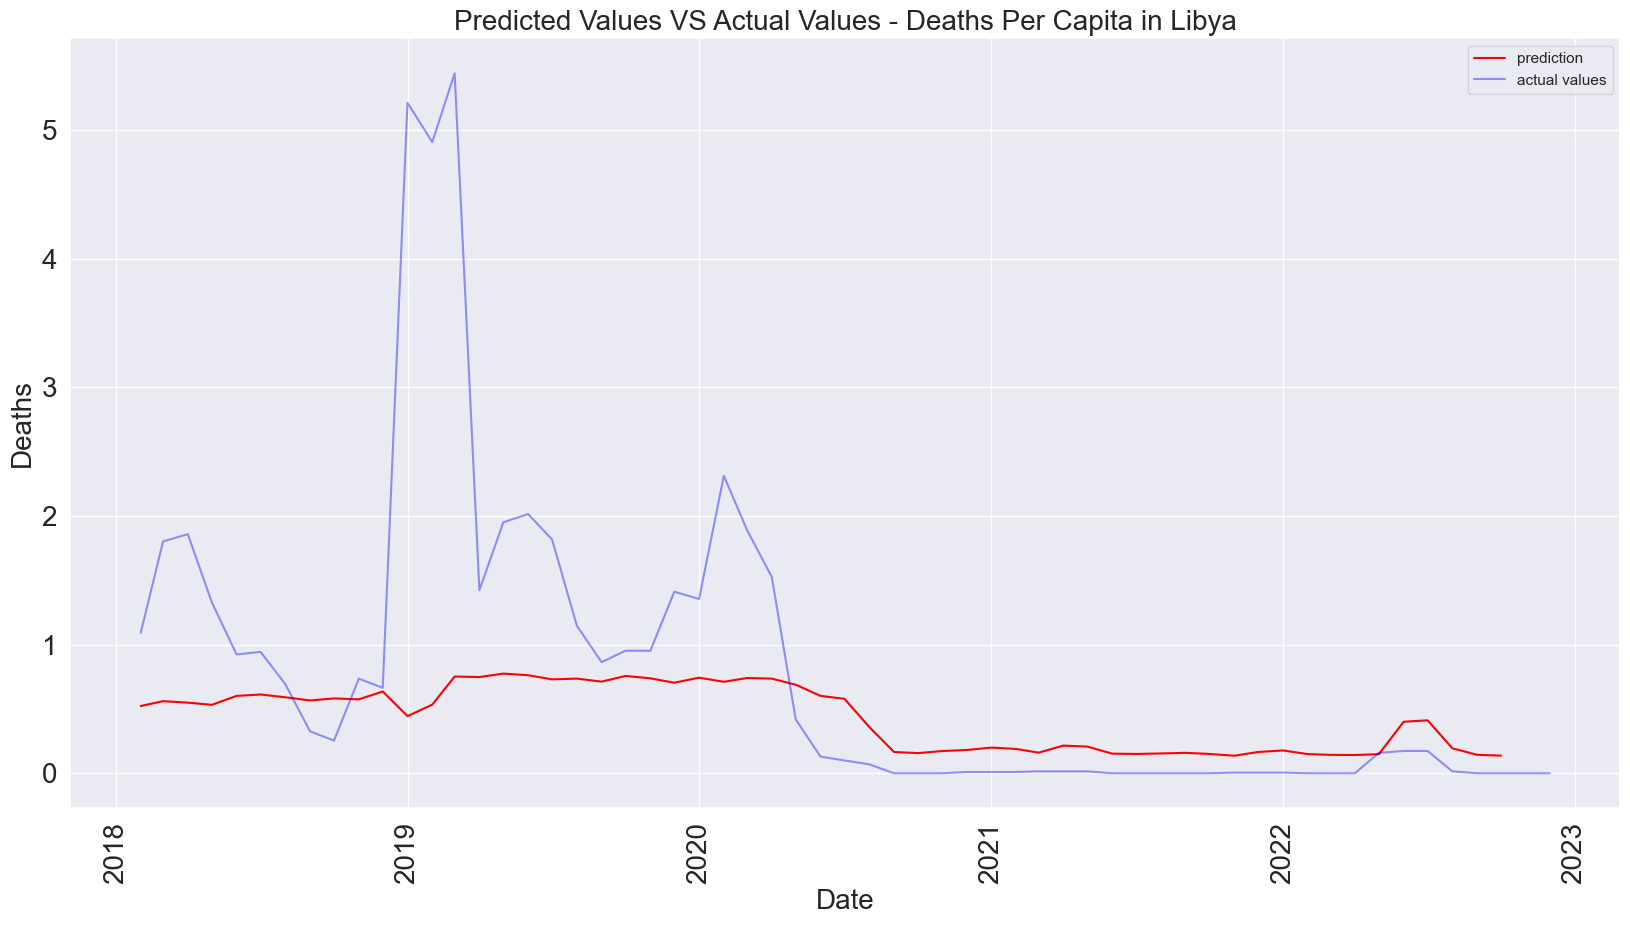

Liberia - Mean Absolute Error: 0.0019254360417650278, Mean Squared Error: 3.875498906764325e-05


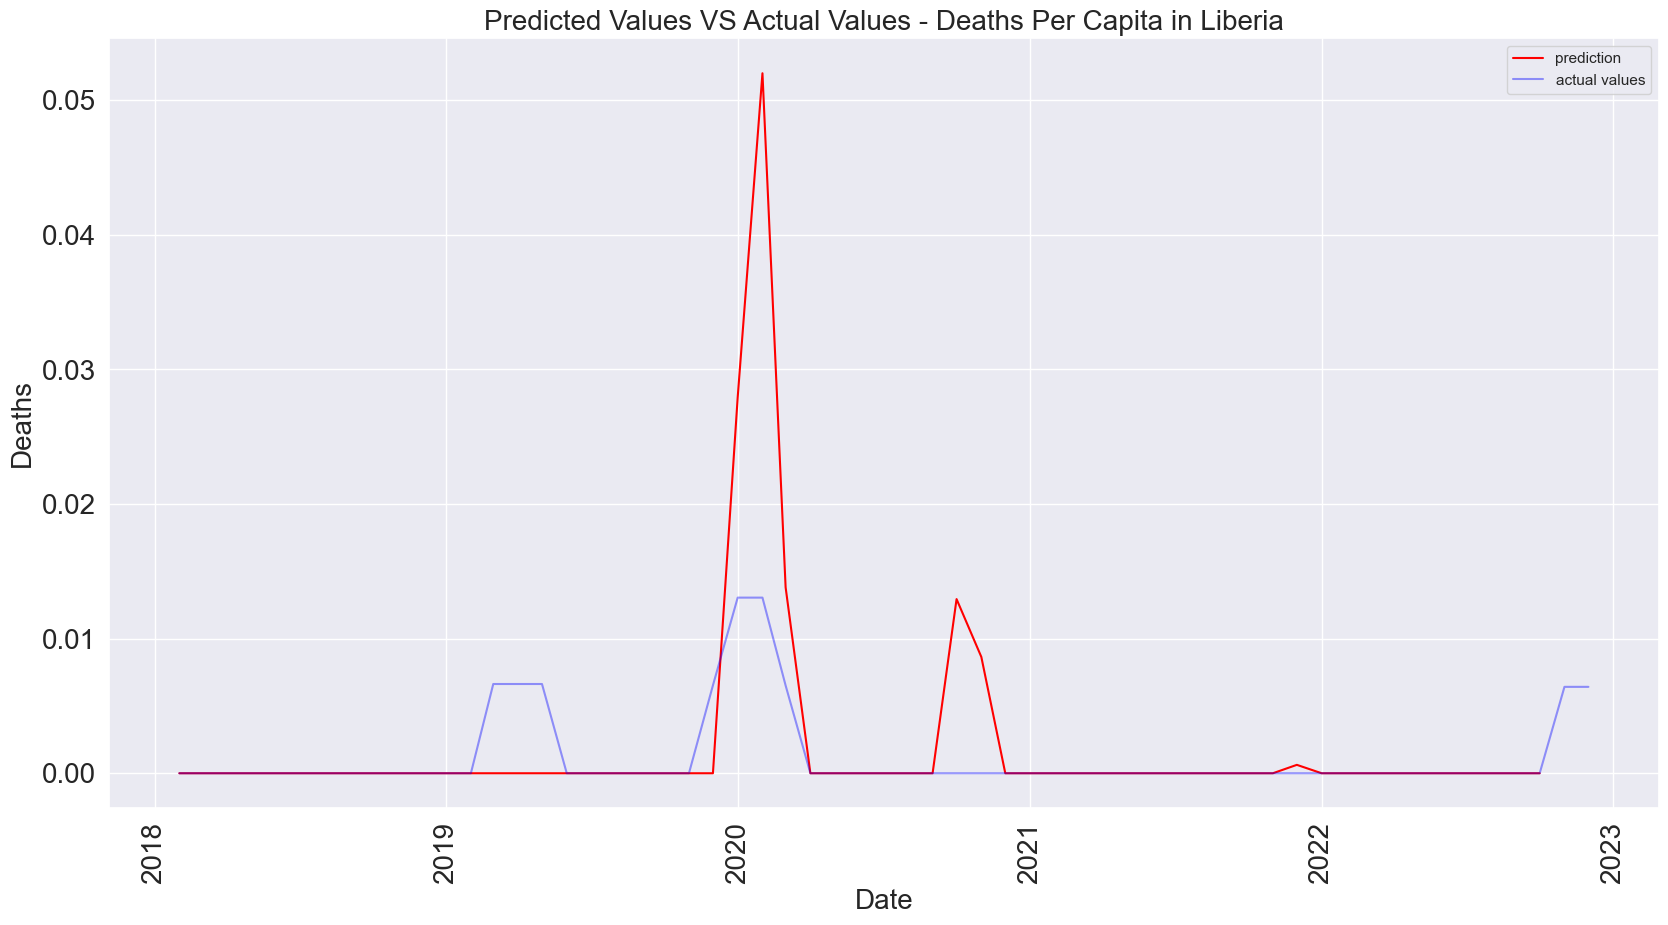

Yemen - Mean Absolute Error: 1.3069707194989697, Mean Squared Error: 7.24953706164278


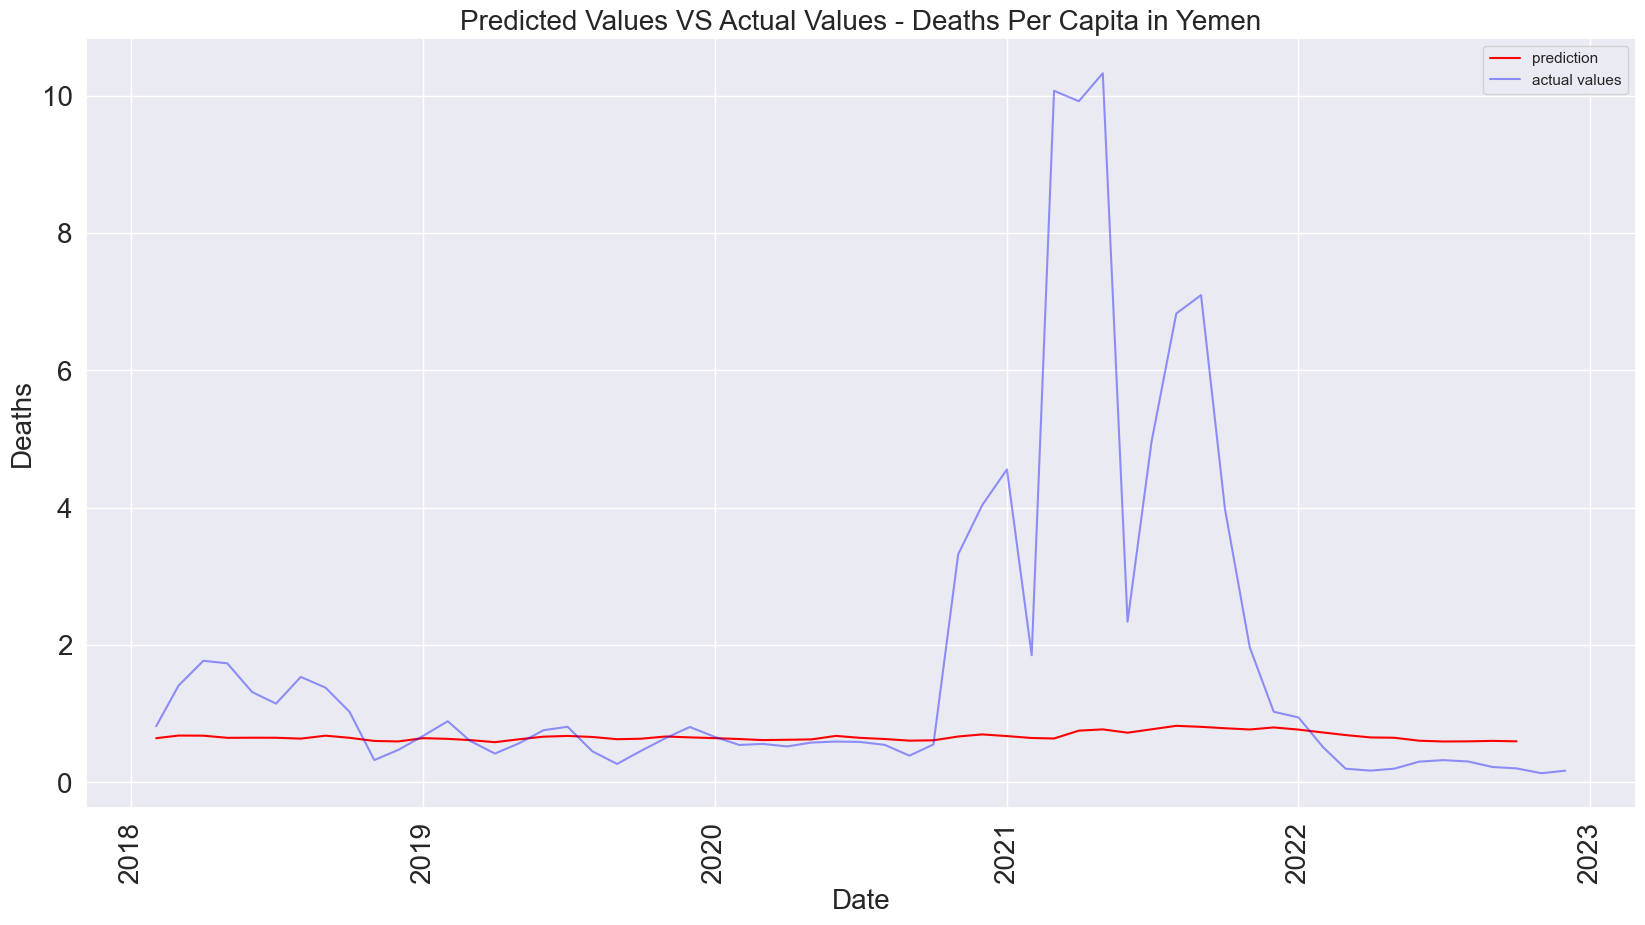

Sudan - Mean Absolute Error: 0.2866228946987751, Mean Squared Error: 0.09431000101109667


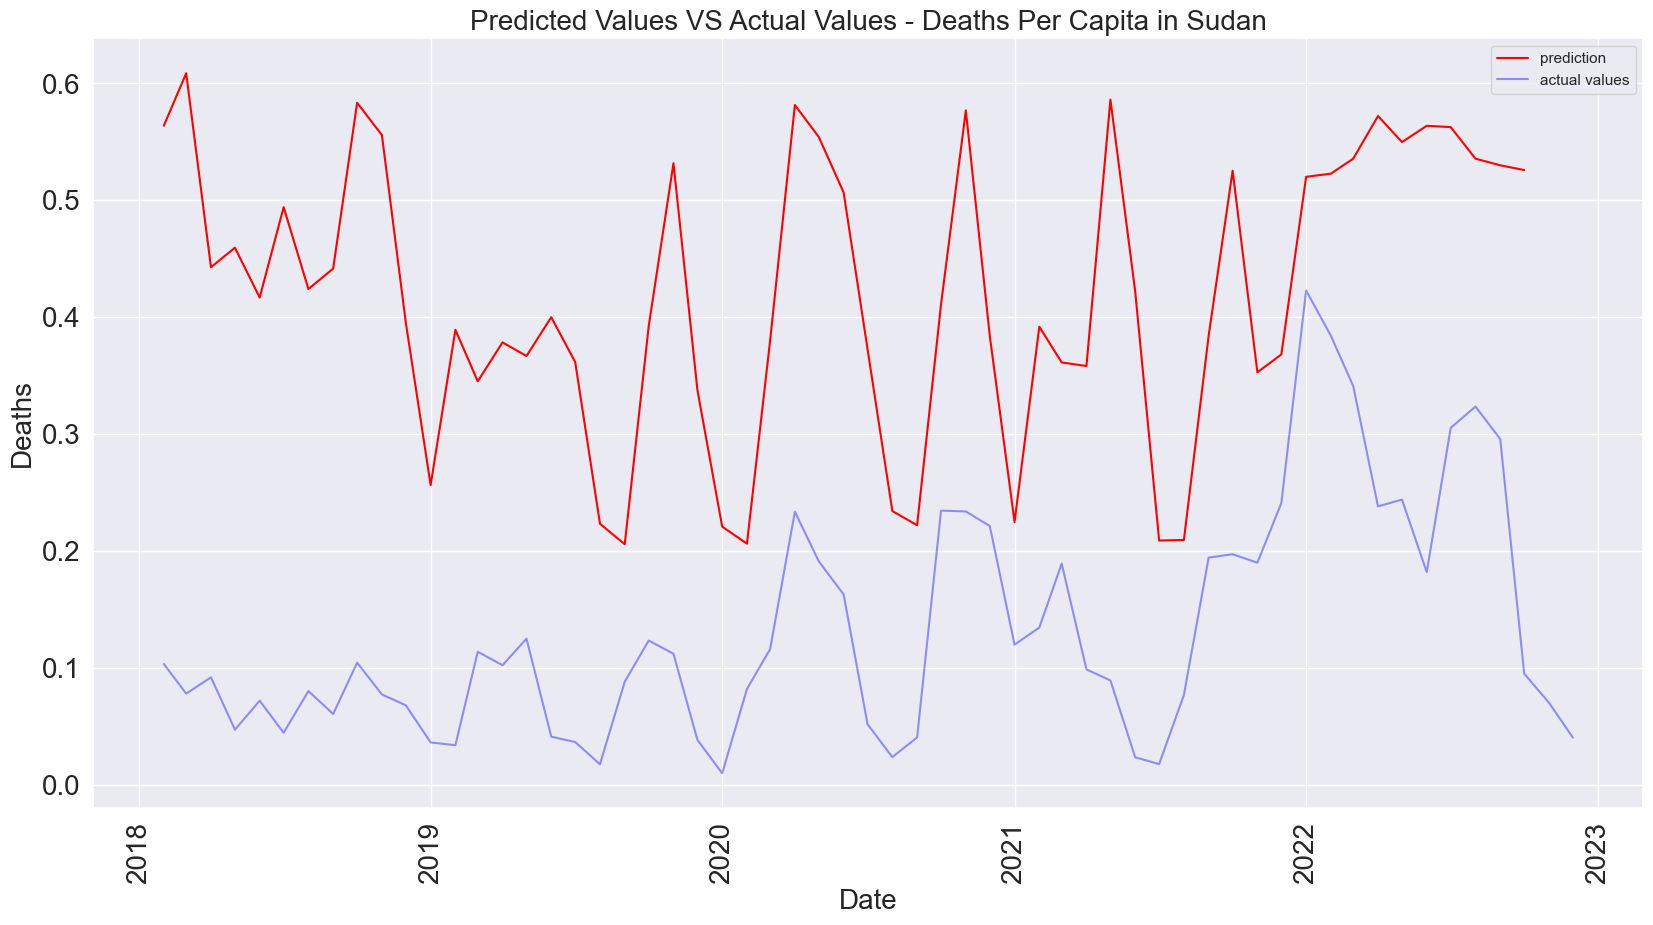

Ukraine - Mean Absolute Error: 2.3081215694305794, Mean Squared Error: 49.8114601087949


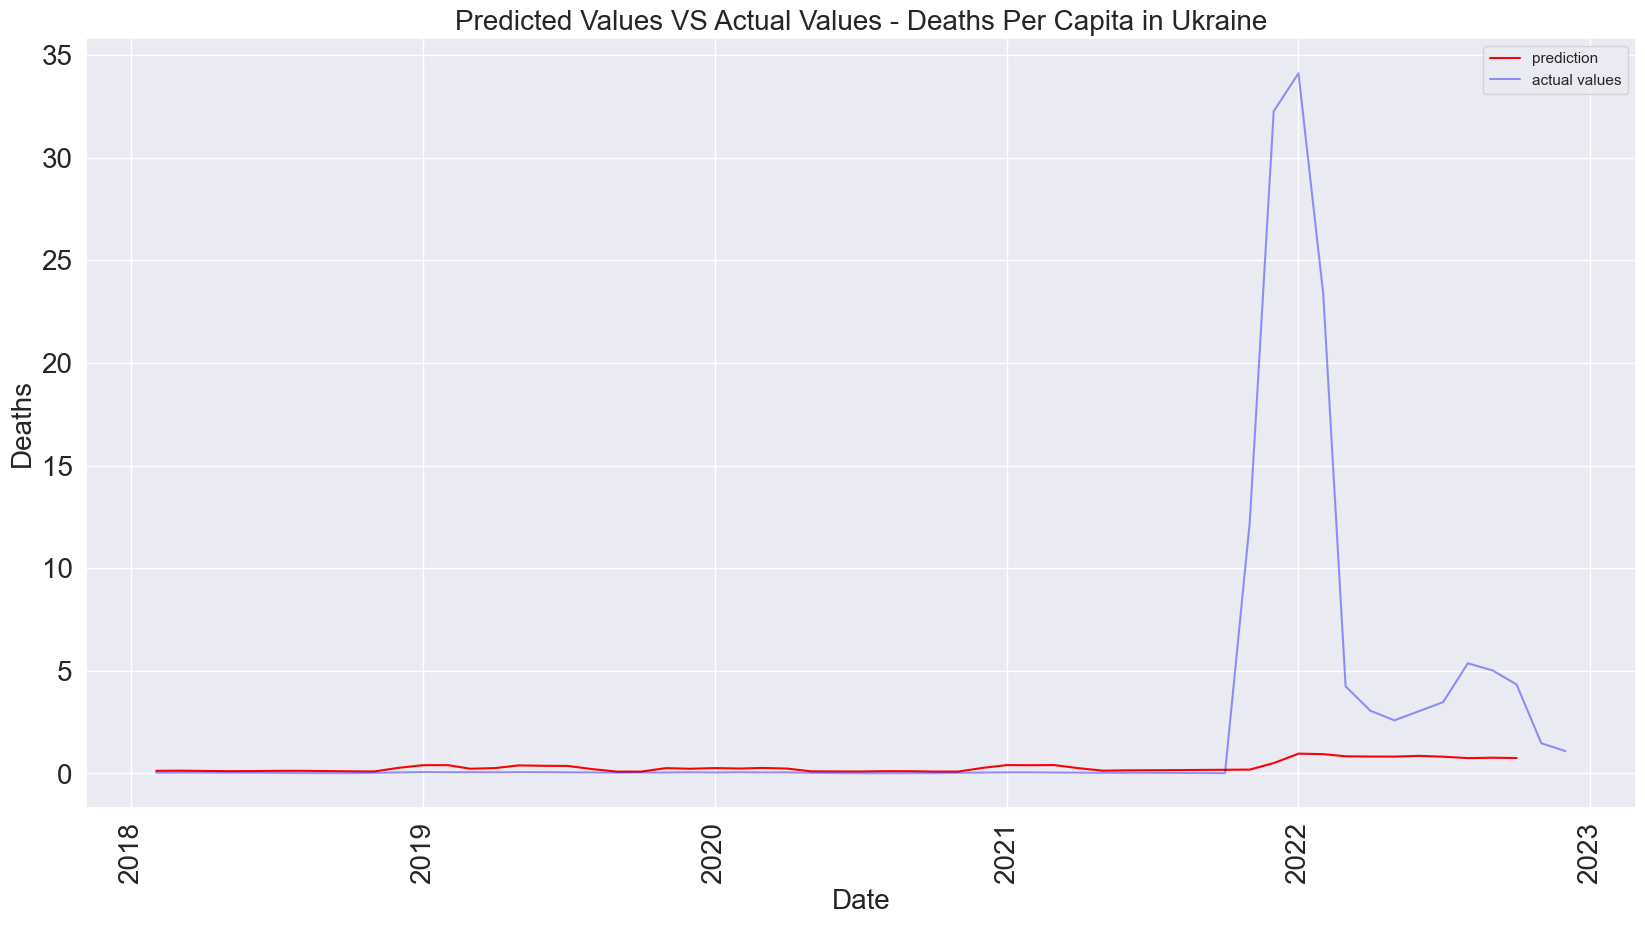

Sri Lanka - Mean Absolute Error: 0.05098251023320162, Mean Squared Error: 0.0048497151027667934


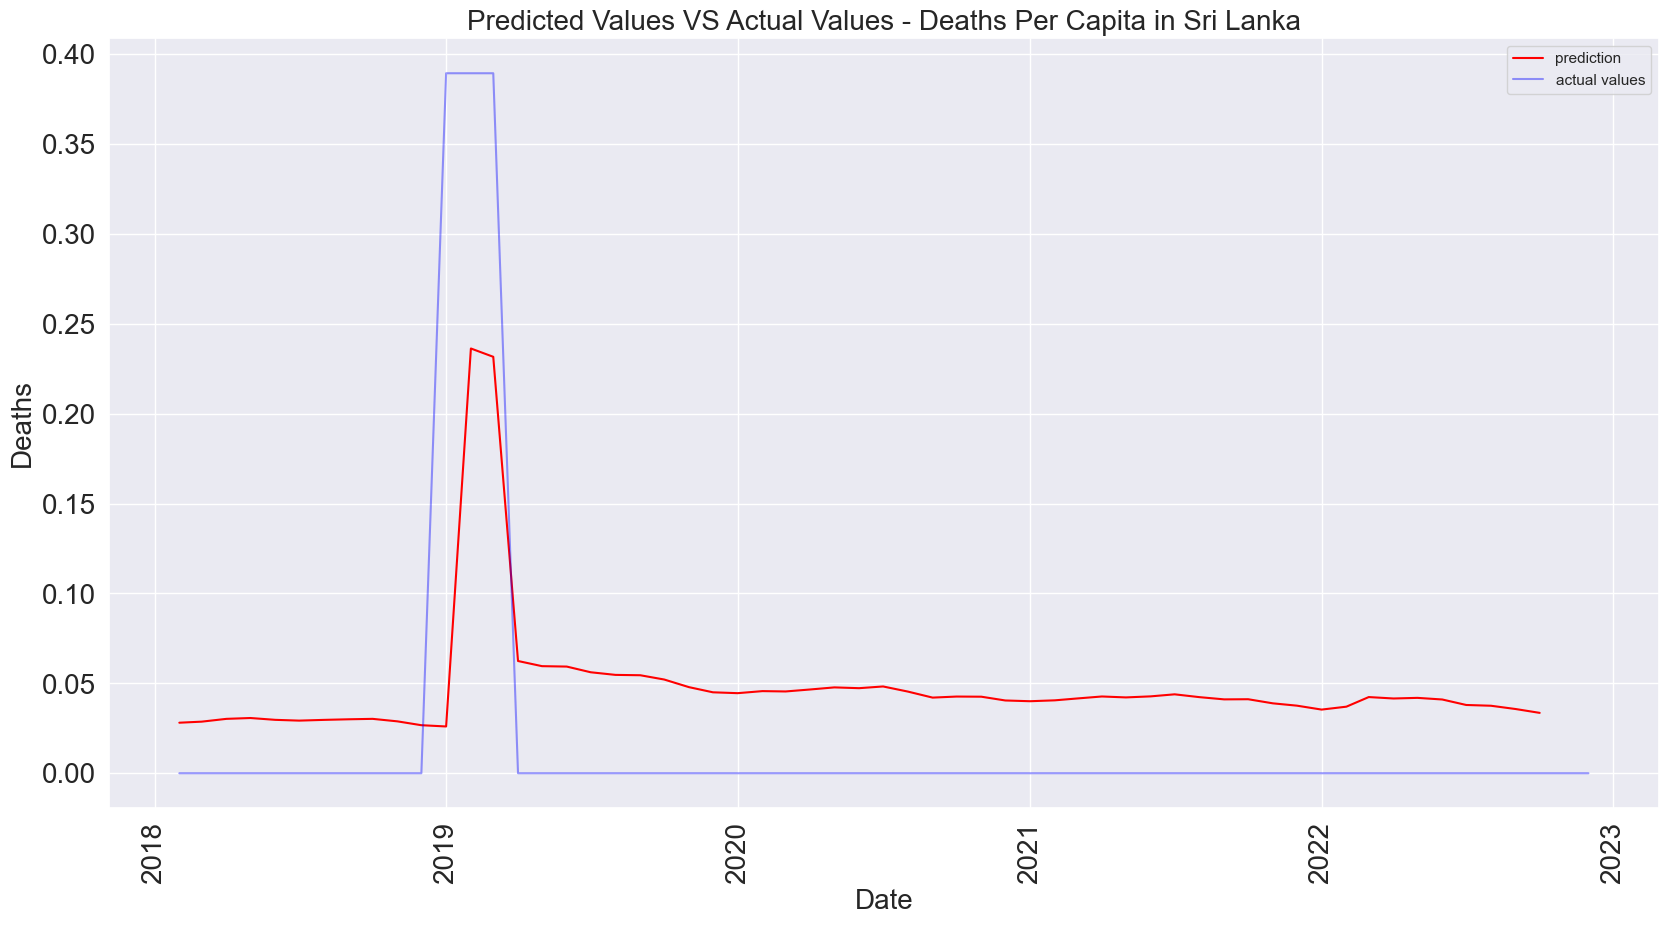

In [55]:
plot_country_data(('f3_target_regr', 'combined_vars'), top_10_country_names, -2)